<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Germany/Hugo/Hugo_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "boss.de"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close  Volume
Date                                                     
2009-01-02  17.25  17.60  16.32  17.50      10.91    3068
2009-01-05  17.10  17.50  16.66  17.45      10.88    1264
2009-01-06  18.28  18.28  17.32  17.49      10.90     239
2009-01-07  17.10  17.40  16.31  16.60      10.35    2715
2009-01-08  16.80  16.80  15.71  16.25      10.13     632
...           ...    ...    ...    ...        ...     ...
2018-12-19  53.64  54.86  53.40  53.86      51.34  491075
2018-12-20  53.00  53.76  52.54  52.96      50.48  361401
2018-12-21  52.62  54.00  52.60  53.32      50.82  543987
2018-12-27  53.72  54.28  52.90  53.22      50.73  273132
2018-12-28  53.50  53.94  53.16  53.92      51.40  166701

[2539 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2539.000000  2539.000000  2539.000000  2539.000000  2539.000000  2.539000e+03
mean     66.895108    67.639890    66.066187    66.880815    53.937420  1.727018e+05
std      27.741709    27.890531    27.549726    27.717598    23.490188  2.052188e+05
min       8.880000     9.200000     8.570000     8.820000     5.500000  0.000000e+00
25%      52.965000    53.720000    52.240000    53.135000    42.120000  1.160300e+04
50%      69.540000    70.280000    68.600000    69.490000    58.870000  1.288260e+05
75%      87.415000    88.100000    86.580000    87.325000    71.295000  2.585780e+05
max     119.900000   120.400000   118.900000   120.000000    96.260000  2.408300e+06

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close  Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-13  10.40  10.40   9.55   9.55       5.95     692   13          4         72             31             0               0               0                 0      3        1    11        4             0          11   9.513133  10.047039   8.764959   9.885378   9.883428   9.893521       9.735       9.675   8.999520   9.65625  10.145879   9.6625   9.868611   9.65625  10.283333  10.140030               10.966209                  9.65625                8.346291               11.621189                  9.65625                7.691311               12.276169                  9.65625                7.036331               12.931149                  9.65625                6.381351   9.883428   9.960114   9.999194               11.193388                 9.883428                8.573469               11.848367                 9.883428                7.918489               12.503347                 9.883428                7.263509               13.158327                 9.883428   
2009-03-16  10.09  10.40  10.09  10.37       6.46     292   16          0         75             31             0               0               0                 0      3        1    12        0             1          12   9.555976  10.034763   8.840361  10.077171   9.991555   9.914139       9.735       9.675   9.131558   9.78375  10.344856   9.9020  10.027222   9.78375   9.960000  10.088010               11.147126                  9.78375                8.420374               11.828814                  9.78375                7.738686               12.510502                  9.78375                7.056998               13.192190                  9.78375                6.375310   9.991555  10.206771   9.967903               11.354931                 9.991555                8.628179               12.036619                 9.991555                7.946492               12.718307                 9.991555                7.264804               13.399995                 9.991555   
2009-03-17  10.30  10.80  10.00  10.75       6.70

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2.489000e+03  2489.000000  2489.000000  2489.000000    2489.000000   2489.000000     2489.000000     2489.000000       2489.000000  2489.000000  2489.000000  2489.000000  2489.000000   2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000  2489.000000  2489.000000  2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000   
mean     67.981193    68.737654    67.144914    67.970478    54.862716  1.761123e+05    15.762555     2.002812   185.324628      30.459221      0.031338        0.028124        0.008437          0.008035     6.595822     2.531137    26.959020     2.002812      2.012455    26.959020    67.958243    67.837505    -0.063471    67.972884    67.907936    67.958365    67.885579    67.808174    67.648258    67.909205    67.970914    67.909402    67.929816    67.909205    67.958785    67.776070               70.335157                67.909205               65.483253               71.548132                67.909205               64.270278               72.761108                67.909205               63.057302               73.974084                67.909205               61.844326    67.907936    67.957791    67.796506               70.333888                67.907936               65.481985               71.546864                67.907936               64.269009               72.759840   
std      26.926316    27.058812    26.739742    26.893716    22.789027  2.058398e+05     8.711079     1.408087   103.325294       0.787286      0.174264        0.165360        0.091484          0.089297     3.387334     1.104259    14.776277     1.408087      1.413448    14.776277    26.945096    27.070219    73.091461    26.902184    26.919255    26.994317    26.921503    26.906970    27.098704    26.935370    26.900051    26.943712    26.913821    26.935370    26.905831    27.042164               27.450306                26.935370               26.519745               27.743330                26.935370               26.350687               28.059088                26.935370               26.208158               28.396821                26.935370               26.092591    26.919255    26.896815    27.026001               27.431116                26.919255               26.506874               27.722672                26.919255               26.339492               28.037010   
min      10.090000    10.400000     9.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close  Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2009-03-13  0.002823  0.000000  0.000000  0.000000   0.000000     692   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.000000  0.000116  0.545932  0.000000  0.000000  0.000000    0.000000    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.002954  0.000786                0.000000                 0.000000                0.000000                0.000425                 0.000000                0.000000                0.004233                 0.000000                0.000000                0.007583                 0.000000                0.000056  0.000000  0.000000  0.000349                0.000000                 0.000000                0.000000                0.003027                 0.000000                0.000000                0.006842                 0.000000                0.000000                0.010169                 0.000000   
2009-03-16  0.000000  0.000000  0.004938  0.007424   0.005647     292   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.000398  0.000000  0.546251  0.001763  0.001003  0.000193    0.000000    0.000000  0.001185  0.001176  0.001825  0.002208  0.001466  0.001176  0.000000  0.000298                0.001639                 0.001176                0.000686                0.002279                 0.001176                0.000440                0.006227                 0.001176                0.000192                0.009672                 0.001176                0.000000  0.001003  0.002257  0.000057                0.001458                 0.001003                0.000510                0.004693                 0.001003                0.000262                0.008700                 0.001003                0.000012                0.012147                 0.001003   
2009-03-17  0.001912  0.003636  0.004115  0.010865   0.0

140355

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpiqq1j6ob
  JVM stdout: /tmp/tmpiqq1j6ob/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpiqq1j6ob/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 9 days
H2O cluster name:           H2O_from_python_unknownUser_3qhk9p
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_144900_mod...  0.753419  0.611340              0.308323  0.457326  0.209147
1  DeepLearning_grid_1_AutoML_20190828_144900_mod...  0.747935  0.609802              0.312226  0.457750  0.209535
2  DeepLearning_grid_1_AutoML_20190828_144900_mod...  0.747613  0.603570              0.312161  0.454709  0.206760
3  DeepLearning_grid_1_AutoML_20190828_144900_mod...  0.735613  0.626984              0.312323  0.464472  0.215735
4  DeepLearning_grid_1_AutoML_20190828_144900_mod...  0.727581  0.634849              0.312484  0.471768  0.222565
5  DeepLearning_grid_1_AutoML_20190828_144900_mod...  0.720387  0.629929              0.316484  0.466021  0.217175
6  DeepLearning_grid_1_AutoML_20190828_144900_mod...  0.707516  1.848754              0.344548  0.560325  0.313964
7  DeepLearning_grid_1_AutoML_20190828_144900_mod...  0.697935  0.769506              0.416194  0.500600  0.250601
8  DeepLearning_grid_1_AutoML_20190828_144900_mod...  0.694065  0.927905              0.324677  0.520158  0.270564
9              DeepLearning_1_AutoML_20190828_144900  0.588258  3.381824              0.476065  0.663631  0.440406

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.005284
1                          SUB             0.531070           0.531070    0.002806
2                          DIV             0.522682           0.522682    0.002762
3                       TRANGE             0.474856           0.474856    0.002509
4                          COS             0.463805           0.463805    0.002451
...                        ...                  ...                ...         ...
1038  BBANDS_middleband_12_6_3             0.142482           0.142482    0.000753
1039               MIDPRICE_30             0.141296           0.141296    0.000747
1040                    MAX_14             0.141103           0.141103    0.000746
1041                    T3_8_1             0.139843           0.139843    0.000739
1042            CDL3LINESTRIKE             0.132604           0.132604    0.000701

[1043 rows x 4 columns]

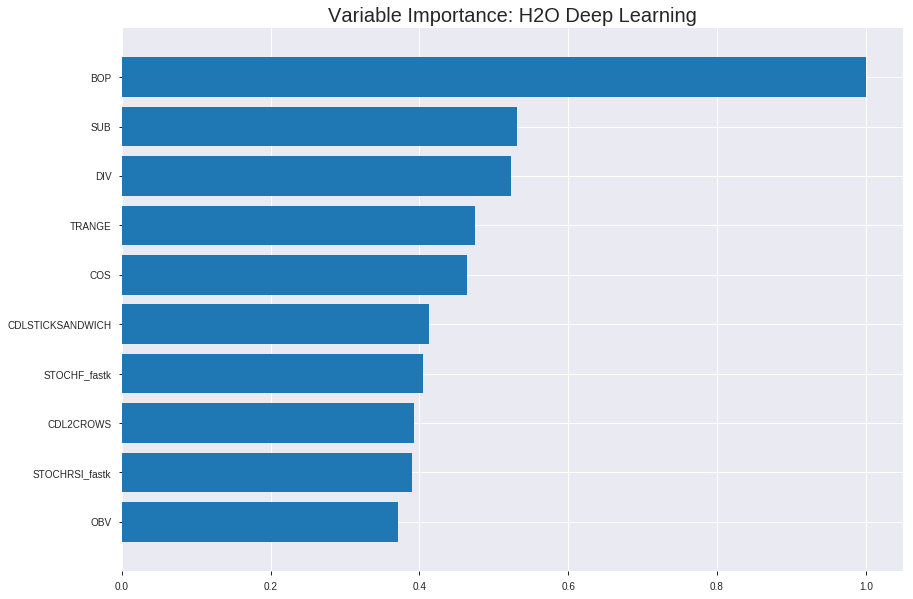

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_144900_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.21040916611276825
RMSE: 0.45870378907609677
LogLoss: 0.6100462342294489
Mean Per-Class Error: 0.320967443581206
AUC: 0.739699936578405
pr_auc: 0.7348992688597145
Gini: 0.4793998731568101
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4260653494677125: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      352  488   0.581    (488.0/840.0)
1      117  784   0.1299   (117.0/901.0)
Total  469  1272  0.3475   (605.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.426065     0.721583  255
max f2                       0.111912     0.84999   366
max f0point5                 0.673187     0.694706  142
max accuracy                 0.555599     0.681218  198
max precision                0.987408     1         0
max recall                   0.0471217    1         386
max specificity              0.987408     1         0
max absolute_mcc             0.549655     0.361608  201
max min_per_class_accuracy   0.603431     0.672619  176
max mean_per_class_accuracy  0.555599     0.679033  198

Gains/Lift Table: Avg response rate: 51.75 %, avg score: 56.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.95545            1.7176    1.7176             0.888889         0.966577  0.888889                    0.966577            0.017758        0.017758                   71.7598   71.7598
    2        0.0201034                   0.934564           1.81863   1.76667            0.941176         0.946699  0.914286                    0.956922            0.017758        0.0355161                  81.8633   76.6672
    3        0.0304423                   0.923525           1.5029    1.67709            0.777778         0.929301  0.867925                    0.947541            0.0155383       0.0510544                  50.2898   67.7088
    4        0.0402068                   0.914423           1.70497   1.68386            0.882353         0.919287  0.871429                    0.94068             0.0166482       0.0677026                  70.4968   68.3859
    5        0.0505457                   0.903754           1.39555   1.62489            0.722222         0.909049  0.840909                    0.93421             0.0144284       0.082131                   39.5548   62.4886
    6        0.100517                    0.862002           1.57693   1.60105            0.816092         0.881352  0.828571                    0.907932            0.0788013       0.160932                   57.6932   60.1046
    7        0.150488                    0.821679           1.53251   1.57829            0.793103         0.839149  0.816794                    0.885092            0.0765816       0.237514                   53.2512   57.8289
    8        0.20046                     0.791829           1.42146   1.53919            0.735632         0.805811  0.796562                    0.865328            0.0710322       0.308546                   42.146    53.9194
    9        0.300402                    0.73432            1.35483   1.47786            0.701149         0.76501   0.764818                    0.831953            0.135405        0.443951                   35.4829   47.7857
    10       0.400345                    0.675526           1.24378   1.41942            0.643678         0.70401   0.734577                    0.800013            0.124306        0.568257                   24.3778   41.9421
    11       0.500287                    0.607278           0.988359  1.33331            0.511494         0.638845  0.690011                    0.767817            0.0987791       0.667037                   -1.1641   33.3307
    12       0.60023                     0.531243           1.02167   1.28142            0.528736         0.569524  0.663158                    0.734799            0.102109        0.769145                   2.16745   28.1418
    13       0.700172                    0.453274           0.755151  1.2063             0.390805         0.493607  0.624282                    0.700372            0.0754717       0.844617                   -24.4849  20.6299
    14       0.800115                    0.329067           0.721835  1.14578            0.373563         0.393451  0.592965                    0.662034            0.0721421       0.916759                   -27.8165  14.5784
    15       0.900057                    0.189957           0.566363  1.08145            0.293103         0.263497  0.559668                    0.61778             0.0566038       0.973363                   -43.3637  8.14453
    16       1                           0.000646678        0.266524  1                  0.137931         0.100101  0.517519                    0.566042         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21127514346408924
RMSE: 0.45964675944043076
LogLoss: 0.6107706392778744
Mean Per-Class Error: 0.33232233604904415
AUC: 0.7276599177220294
pr_auc: 0.7143006624780995
Gini: 0.45531983544405885
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43327088773067196: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      110  135  0.551    (135.0/245.0)
1      37   216  0.1462   (37.0/253.0)
Total  147  351  0.3454   (172.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.433271     0.715232  267
max f2                       0.192966     0.847458  365
max f0point5                 0.628194     0.680128  133
max accuracy                 0.584408     0.666667  167
max precision                0.810602     0.882353  27
max recall                   0.086715     1         384
max specificity              0.97736      0.995918  0
max absolute_mcc             0.628194     0.343113  133
max min_per_class_accuracy   0.560208     0.656126  187
max mean_per_class_accuracy  0.584408     0.667678  167

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 53.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.90564            1.18103   1.18103            0.6              0.935174  0.6                         0.935174            0.0118577       0.0118577                  18.1028   18.1028
    2        0.0200803                   0.872389           1.96838   1.5747             1                0.889558  0.8                         0.912366            0.0197628       0.0316206                  96.8379   57.4704
    3        0.0301205                   0.864137           1.96838   1.70593            1                0.868113  0.866667                    0.897615            0.0197628       0.0513834                  96.8379   70.5929
    4        0.0401606                   0.834827           1.18103   1.5747             0.6              0.847108  0.8                         0.884988            0.0118577       0.0632411                  18.1028   57.4704
    5        0.0502008                   0.825842           1.96838   1.65344            1                0.829313  0.84                        0.873853            0.0197628       0.083004                   96.8379   65.3439
    6        0.100402                    0.772346           1.65344   1.65344            0.84             0.799924  0.84                        0.836889            0.083004        0.166008                   65.3439   65.3439
    7        0.150602                    0.738835           1.65344   1.65344            0.84             0.752961  0.84                        0.808913            0.083004        0.249012                   65.3439   65.3439
    8        0.200803                    0.710564           1.41723   1.59439            0.72             0.723562  0.81                        0.787575            0.0711462       0.320158                   41.7233   59.4387
    9        0.301205                    0.650654           1.14166   1.44348            0.58             0.680952  0.733333                    0.752034            0.114625        0.434783                   14.166    44.3478
    10       0.399598                    0.605294           1.2453    1.39468            0.632653         0.627474  0.708543                    0.721363            0.12253         0.557312                   24.5301   39.4681
    11       0.5                         0.559062           0.98419   1.31225            0.5              0.579491  0.666667                    0.692875            0.0988142       0.656126                   -1.58103  31.2253
    12       0.600402                    0.504202           0.905455  1.24423            0.46             0.532817  0.632107                    0.666109            0.0909091       0.747036                   -9.45455  24.4226
    13       0.698795                    0.43678            0.964104  1.20478            0.489796         0.475745  0.612069                    0.639305            0.0948617       0.841897                   -3.58958  20.4784
    14       0.799197                    0.363045           0.629881  1.13256            0.32             0.398458  0.575377                    0.609048            0.0632411       0.905138                   -37.0119  13.256
    15       0.899598                    0.250671           0.669249  1.08085            0.34             0.310988  0.549107                    0.575782            0.0671937       0.972332                   -33.0751  8.08512
    16       1                           2.43435e-05        0.275573  1                  0.14             0.136921  0.508032                    0.53172           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 14:50:26  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 14:50:27  1 min 21.626 sec  467 obs/sec       0.361287  1             629        0.698445         12.1864             -0.953702      0.561327        0.597576           1.5029           0.482481                         0.67044            9.15425               -0.798423        0.59053           0.586193             1.18103            0.491968
    2019-08-28 14:50:38  1 min 32.027 sec  426 obs/sec       2.64561   7             4606       0.528181         0.853464            -0.117271      0.658715        0.668441           1.5029           0.438254                         0.46378            0.622061              0.139412         0.721271          0.697617             0.787352           0.335341
    2019-08-28 14:50:48  1 min 41.796 sec  431 obs/sec       4.85985   13            8461       0.487945         0.683301            0.0464679      0.70133         0.71277            1.82495          0.415853                         0.478628           0.64701               0.0834231        0.69658           0.686691             1.5747             0.345382
    2019-08-28 14:50:58  1 min 52.410 sec  446 obs/sec       7.50316   20            13063      0.579819         1.03689             -0.346411      0.686066        0.691486           1.7176           0.39058                          0.499534           0.704787              0.00160403       0.707268          0.693863             1.5747             0.353414
    2019-08-28 14:51:08  2 min  2.354 sec  458 obs/sec       10.0603   27            17515      0.469529         0.640398            0.117086       0.720209        0.718594           1.7176           0.376795                         0.462743           0.616036              0.143255         0.717174          0.705357             1.5747             0.361446
    2019-08-28 14:51:18  2 min 12.476 sec  465 obs/sec       12.6841   34            22083      0.489218         0.676134            0.0414875      0.655768        0.661681           1.61025          0.433084                         0.473652           0.63946               0.102384         0.688376          0.68162              1.5747             0.369478
    2019-08-28 14:51:28  2 min 22.487 sec  472 obs/sec       15.2924   41            26624      0.487613         0.679993            0.0477649      0.687401        0.689802           1.82495          0.409535                         0.465031           0.622685              0.134762         0.717262          0.703849             1.18103            0.335341
    2019-08-28 14:51:39  2 min 33.203 sec  480 obs/sec       18.2372   49            31751      0.46083          0.613738            0.149499       0.726989        0.721624           1.61025          0.358989                         0.464671           0.622585              0.136101         0.716343          0.708673             1.18103            0.37751
    2019-08-28 14:51:49 

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.005284330333372867
SUB                       0.5310701131820679     0.5310701131820679   0.002806349908235763
DIV                       0.5226823091506958     0.5226823091506958   0.0027620259809623964
TRANGE                    0.47485628724098206    0.47485628724098206  0.0025092974826603407
COS                       0.46380457282066345    0.46380457282066345  0.002450896572913277
---                       ---                    ---                  ---
BBANDS_middleband_12_6_3  0.14248166978359222    0.14248166978359222  0.0007529202095870527
MIDPRICE_30               0.14129643142223358    0.14129643142223358  0.0007466570185618481
MAX_14                    0.14110322296619415    0.14110322296619415  0.0007456360412569348
T3_8_1                    0.13984274864196777    0.13984274864196777  0.0007389752785509876
CDL3LINESTRIKE            0.13260413706302643    0.13260413706302643  0.0007007240638128838


See the whole table with table.as_data_frame()


('accuracy', 0.6947791164658634)

('F1', 0.7475409836065573)

('auc', 0.7534193548387096)

('logloss', 0.6113397890143536)

('mean_per_class_error', 0.3048064516129032)

('rmse', 0.45732577390756973)

('mse', 0.20914686348015757)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


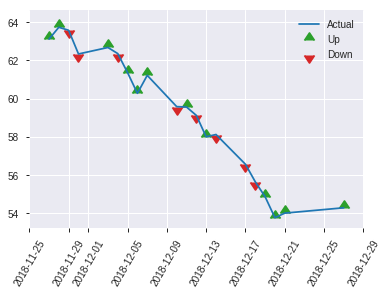


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20914686348015757
RMSE: 0.45732577390756973
LogLoss: 0.6113397890143536
Mean Per-Class Error: 0.3048064516129032
AUC: 0.7534193548387096
pr_auc: 0.7131972859483495
Gini: 0.5068387096774192
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46935806009029485: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      58   67   0.536    (67.0/125.0)
1      10   114  0.0806   (10.0/124.0)
Total  68   181  0.3092   (77.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.469358     0.747541  180
max f2                       0.302671     0.855728  210
max f0point5                 0.626322     0.689103  124
max accuracy                 0.567791     0.694779  147
max precision                0.989518     1         0
max recall                   0.0784658    1         242
max specificity              0.989518     1         0
max absolute_mcc             0.469358     0.430203  180
max min_per_class_accuracy   0.626322     0.688     124
max mean_per_class_accuracy  0.566644     0.695194  149

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 58.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.968762           2.00806   2.00806            1                0.98408   1                           0.98408             0.0241935       0.0241935                  100.806   100.806
    2        0.0200803                   0.943086           1.00403   1.60645            0.5              0.957465  0.8                         0.973434            0.00806452      0.0322581                  0.403226  60.6452
    3        0.0321285                   0.925414           2.00806   1.75706            1                0.932451  0.875                       0.958066            0.0241935       0.0564516                  100.806   75.7056
    4        0.0401606                   0.921056           1.00403   1.60645            0.5              0.924801  0.8                         0.951413            0.00806452      0.0645161                  0.403226  60.6452
    5        0.0522088                   0.90337            2.00806   1.69913            1                0.912982  0.846154                    0.942544            0.0241935       0.0887097                  100.806   69.9132
    6        0.100402                    0.857627           1.33871   1.52613            0.666667         0.879637  0.76                        0.912349            0.0645161       0.153226                   33.871    52.6129
    7        0.15261                     0.831318           1.8536    1.63816            0.923077         0.843444  0.815789                    0.888776            0.0967742       0.25                       85.3598   63.8158
    8        0.200803                    0.80521            1.50605   1.60645            0.75             0.823318  0.8                         0.873066            0.0725806       0.322581                   50.6048   60.6452
    9        0.301205                    0.754286           1.20484   1.47258            0.6              0.784098  0.733333                    0.84341             0.120968        0.443548                   20.4839   47.2581
    10       0.401606                    0.681315           1.28516   1.42573            0.64             0.714801  0.71                        0.811258            0.129032        0.572581                   28.5161   42.5726
    11       0.502008                    0.626322           1.20484   1.38155            0.6              0.65653   0.688                       0.780312            0.120968        0.693548                   20.4839   38.1548
    12       0.598394                    0.566818           1.00403   1.32074            0.5              0.597078  0.657718                    0.750798            0.0967742       0.790323                   0.403226  32.074
    13       0.698795                    0.477907           0.883548  1.25793            0.44             0.521107  0.626437                    0.717796            0.0887097       0.879032                   -11.6452  25.7925
    14       0.799197                    0.368612           0.722903  1.19071            0.36             0.436505  0.592965                    0.682458            0.0725806       0.951613                   -27.7097  19.0712
    15       0.899598                    0.236106           0.240968  1.08471            0.12             0.298023  0.540179                    0.639553            0.0241935       0.975806                   -75.9032  8.47134
    16       1                           0.0415203          0.240968  1                  0.12             0.140979  0.497992                    0.589495          

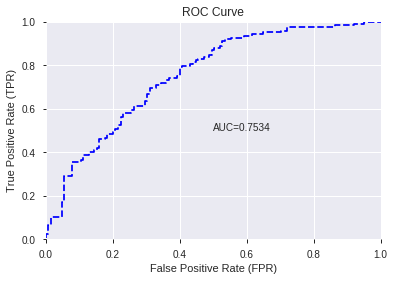

This function is available for GLM models only


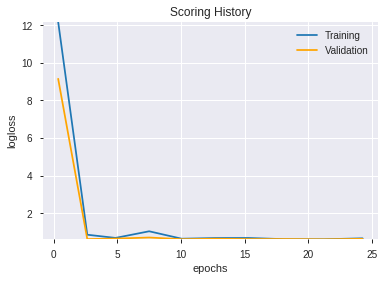

--2019-08-28 15:17:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  47.1MB/s    in 7.9s    

2019-08-28 15:18:08 (44.3 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_144900_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_144900_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_9b1a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_151817_model_6  0.768645  0.574766              0.308452  0.442255  0.195589
1  DeepLearning_grid_1_AutoML_20190828_151817_model_8  0.764194  0.599911              0.308484  0.454863  0.206900
2  DeepLearning_grid_1_AutoML_20190828_151817_model_9  0.762516  0.587392              0.300355  0.448901  0.201512
3  DeepLearning_grid_1_AutoML_20190828_151817_model_5  0.740581  0.620923              0.336419  0.465727  0.216902
4  DeepLearning_grid_1_AutoML_20190828_151817_model_1  0.736258  0.998755              0.300548  0.526598  0.277306
5  DeepLearning_grid_1_AutoML_20190828_151817_model_7  0.704000  1.180075              0.368677  0.575132  0.330777
6               DeepLearning_1_AutoML_20190828_151817  0.696258  0.747117              0.384419  0.515609  0.265853
7  DeepLearning_grid_1_AutoML_20190828_151817_model_4  0.680194  0.872381              0.332548  0.511415  0.261545
8  DeepLearning_grid_1_AutoML_20190828_151817_model_2  0.677419  0.725891              0.396290  0.501326  0.251328
9  DeepLearning_grid_1_AutoML_20190828_151817_model_3  0.669032  0.809034              0.372548  0.507703  0.257762

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.032792
1                TRANGE             0.735524           0.735524    0.024119
2                   DIV             0.727701           0.727701    0.023862
3    CDLCLOSINGMARUBOZU             0.716152           0.716152    0.023484
4                   SUB             0.684506           0.684506    0.022446
5            aroonup_30             0.673883           0.673883    0.022098
6          STOCHF_fastk             0.663454           0.663454    0.021756
7           CDLLONGLINE             0.652820           0.652820    0.021407
8                   day             0.647088           0.647088    0.021219
9          CDLSHORTLINE             0.639085           0.639085    0.020957
10              BETA_12             0.624676           0.624676    0.020484
11       STOCHRSI_fastk             0.623467           0.623467    0.020444
12              quarter             0.622066           0.622066    0.020399
13                  EXP             0.621776           0.621776    0.020389
14                 TANH             0.615063           0.615063    0.020169
15     CDLSTICKSANDWICH             0.614450           0.614450    0.020149
16                  OBV             0.612964           0.612964    0.020100
17                ADOSC             0.606058           0.606058    0.019874
18                 week             0.604547           0.604547    0.019824
19            CDLONNECK             0.598601           0.598601    0.019629
20            dayofweek             0.596638           0.596638    0.019565
21            aroonup_8             0.595972           0.595972    0.019543
22    CDLDARKCLOUDCOVER             0.594276           0.594276    0.019487
23                 SINH             0.593346           0.593346    0.019457
24         CDLENGULFING             0.589598           0.589598    0.019334
25       CDLSPINNINGTOP             0.589391           0.589391    0.019327
26               ULTOSC             0.589386           0.589386    0.019327
27            CDLHAMMER             0.588515           0.588515    0.019298
28            CDLINNECK             0.587733           0.587733    0.019273
29               SAREXT             0.584870           0.584870    0.019179
30          CDLPIERCING             0.584300           0.584300    0.019160
31         aroondown_14             0.582420           0.582420    0.019098
32          STOCH_slowd             0.581863           0.581863    0.019080
33          CDLBELTHOLD             0.581432           0.581432    0.019066
34       CDLMORNINGSTAR             0.580205           0.580205    0.019026
35    CDL3WHITESOLDIERS             0.578893           0.578893    0.018983
36  CDLGAPSIDESIDEWHITE             0.578202           0.578202    0.018960
37              weekday             0.577870           0.577870    0.018949
38             CORREL_8             0.572841           0.572841    0.018784
39         HT_TRENDMODE             0.568341           0.568341    0.018637
40                 DX_8             0.567964           0.567964    0.018624
41                  COS             0.562985           0.562985    0.018461
42            CDL2CROWS             0.562632           0.562632    0.018450
43                  SIN             0.560279           0.560279    0.018372
44      CDLLADDERBOTTOM             0.558826           0.558826    0.018325
45         weekday_name             0.551559           0.551559    0.018086
46          aroondown_8             0.550730           0.550730    0.018059
47   CDLUPSIDEGAP2CROWS             0.550666           0.550666    0.018057
48     is_quarter_start             0.548984           0.548984    0.018002
49   CDLEVENINGDOJISTAR             0.501081           0.501081    0.016431

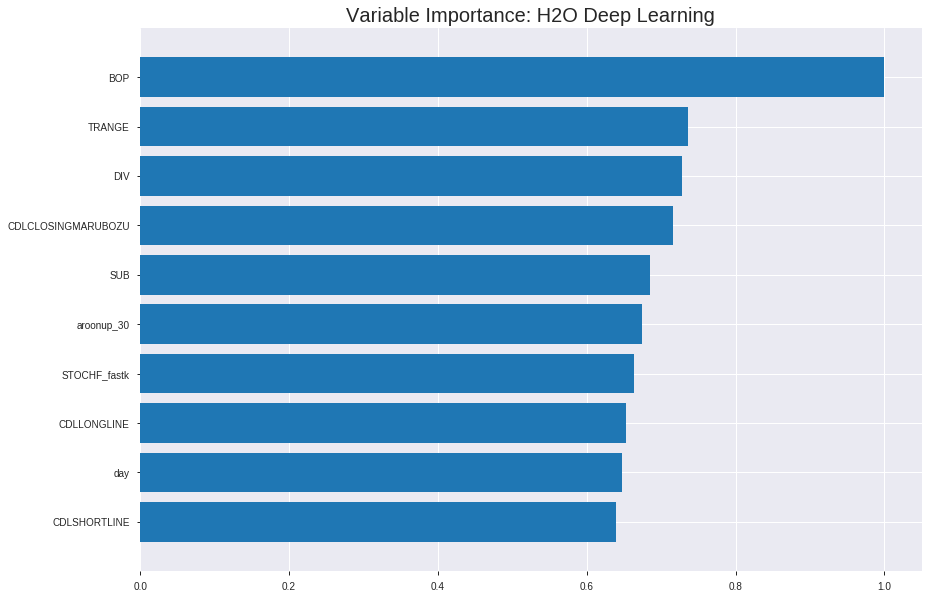

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_151817_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20991655826549246
RMSE: 0.4581665180537448
LogLoss: 0.6078583554419811
Mean Per-Class Error: 0.32241226679350987
AUC: 0.7333386184662544
pr_auc: 0.7403667780528012
Gini: 0.46667723693250873
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3306213029280562: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      330  510   0.6071   (510.0/840.0)
1      103  798   0.1143   (103.0/901.0)
Total  433  1308  0.3521   (613.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.330621     0.722499  279
max f2                       0.145302     0.852691  347
max f0point5                 0.494291     0.688224  195
max accuracy                 0.494291     0.678346  195
max precision                0.9613       1         0
max recall                   0.0129492    1         396
max specificity              0.9613       1         0
max absolute_mcc             0.494291     0.35551   195
max min_per_class_accuracy   0.508885     0.672586  187
max mean_per_class_accuracy  0.494291     0.677588  195

Gains/Lift Table: Avg response rate: 51.75 %, avg score: 47.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.893956           1.9323    1.9323             1                0.923227   1                           0.923227            0.0199778       0.0199778                  93.2297   93.2297
    2        0.0201034                   0.862041           1.9323    1.9323             1                0.879203   1                           0.901844            0.0188679       0.0388457                  93.2297   93.2297
    3        0.0304423                   0.84009            1.82495   1.89584            0.944444         0.850224   0.981132                    0.884312            0.0188679       0.0577137                  82.4948   89.5839
    4        0.0402068                   0.81136            1.70497   1.84948            0.882353         0.825641   0.957143                    0.870064            0.0166482       0.0743618                  70.4968   84.9485
    5        0.0505457                   0.791822           1.39555   1.75663            0.722222         0.80126    0.909091                    0.85599             0.0144284       0.0887902                  39.5548   75.6634
    6        0.100517                    0.738596           1.53251   1.64521            0.793103         0.762989   0.851429                    0.809755            0.0765816       0.165372                   53.2512   64.5213
    7        0.150488                    0.694697           1.46588   1.58566            0.758621         0.716104   0.820611                    0.778657            0.0732519       0.238624                   46.5881   58.5664
    8        0.20046                     0.655385           1.22157   1.4949             0.632184         0.67431    0.773639                    0.752645            0.0610433       0.299667                   22.1567   49.4901
    9        0.300402                    0.598823           1.2993    1.42983            0.672414         0.626489   0.739962                    0.710674            0.129856        0.429523                   29.9303   42.9826
    10       0.400345                    0.55228            1.22157   1.37784            0.632184         0.573957   0.713056                    0.676544            0.122087        0.551609                   22.1567   37.7836
    11       0.500287                    0.511258           1.14383   1.33109            0.591954         0.531974   0.688863                    0.647663            0.114317        0.665927                   14.3831   33.1089
    12       0.60023                     0.448057           0.943938  1.26663            0.488506         0.480261   0.655502                    0.619789            0.0943396       0.760266                   -5.60616  26.6626
    13       0.700172                    0.37796            0.810677  1.20154            0.41954          0.413719   0.621821                    0.590375            0.0810211       0.841287                   -18.9323  20.1543
    14       0.800115                    0.271101           0.721835  1.14162            0.373563         0.326526   0.590811                    0.557417            0.0721421       0.91343                    -27.8165  14.1623
    15       0.900057                    0.140836           0.644099  1.08638            0.333333         0.202312   0.562221                    0.517986            0.0643729       0.977802                   -35.5901  8.63778
    16       1                           0.00375589         0.222103  1                  0.114943         0.0680453  0.517519                   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2138289828113869
RMSE: 0.4624164603594761
LogLoss: 0.6167521080221676
Mean Per-Class Error: 0.3404452690166976
AUC: 0.7172703073324191
pr_auc: 0.6927378042238826
Gini: 0.4345406146648383
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2866339644681139: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      73   172  0.702    (172.0/245.0)
1      11   242  0.0435   (11.0/253.0)
Total  84   414  0.3675   (183.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.286634     0.725637  325
max f2                       0.275576     0.850245  328
max f0point5                 0.556341     0.665072  155
max accuracy                 0.483142     0.660643  215
max precision                0.821913     1         0
max recall                   0.044447     1         394
max specificity              0.821913     1         0
max absolute_mcc             0.286634     0.339749  325
max min_per_class_accuracy   0.512743     0.656126  190
max mean_per_class_accuracy  0.483142     0.659555  215

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 48.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.794308           1.18103   1.18103            0.6              0.809385  0.6                         0.809385            0.0118577       0.0118577                  18.1028   18.1028
    2        0.0200803                   0.776864           1.5747    1.37787            0.8              0.78728   0.7                         0.798333            0.0158103       0.027668                   57.4704   37.7866
    3        0.0301205                   0.757714           1.96838   1.5747             1                0.767621  0.8                         0.788095            0.0197628       0.0474308                  96.8379   57.4704
    4        0.0401606                   0.742429           1.96838   1.67312            1                0.752122  0.85                        0.779102            0.0197628       0.0671937                  96.8379   67.3123
    5        0.0502008                   0.73481            1.18103   1.5747             0.6              0.738008  0.8                         0.770883            0.0118577       0.0790514                  18.1028   57.4704
    6        0.100402                    0.699311           1.5747    1.5747             0.8              0.715861  0.8                         0.743372            0.0790514       0.158103                   57.4704   57.4704
    7        0.150602                    0.672463           1.49597   1.54846            0.76             0.68686   0.786667                    0.724535            0.0750988       0.233202                   49.5968   54.8458
    8        0.200803                    0.637168           1.41723   1.51565            0.72             0.65656   0.77                        0.707541            0.0711462       0.304348                   41.7233   51.5652
    9        0.301205                    0.59572            1.2204    1.41723            0.62             0.61203   0.72                        0.675704            0.12253         0.426877                   22.0395   41.7233
    10       0.399598                    0.554401           1.2453    1.3749             0.632653         0.576234  0.698492                    0.651211            0.12253         0.549407                   24.5301   37.4898
    11       0.5                         0.512972           1.02356   1.30435            0.52             0.535871  0.662651                    0.628051            0.102767        0.652174                   2.35573   30.4348
    12       0.600402                    0.459418           0.944822  1.24423            0.48             0.489871  0.632107                    0.604944            0.0948617       0.747036                   -5.51779  24.4226
    13       0.698795                    0.409625           0.923933  1.19913            0.469388         0.434617  0.609195                    0.580961            0.0909091       0.837945                   -7.60668  19.9128
    14       0.799197                    0.315003           0.905455  1.16223            0.46             0.368362  0.590452                    0.554252            0.0909091       0.928854                   -9.45455  16.2234
    15       0.899598                    0.204408           0.433043  1.08085            0.22             0.261815  0.549107                    0.521614            0.0434783       0.972332                   -56.6957  8.08512
    16       1                           0.00209517         0.275573  1                  0.14             0.128785  0.508032                    0.482174         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:22:01  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 15:22:04  1 min 55.862 sec  1128 obs/sec      2         1             3482       0.50766          0.748573            -0.0321435     0.669013        0.666143           1.61025          0.419299                         0.484632           0.674312              0.0602842        0.69195           0.681931             1.96838            0.361446
    2019-08-28 15:22:09  2 min  1.391 sec  2136 obs/sec      10        5             17410      0.458167         0.607858            0.159302       0.733339        0.740367           1.9323           0.352096                         0.462416           0.616752              0.144463         0.71727           0.692738             1.18103            0.36747
    2019-08-28 15:22:15  2 min  6.917 sec  2643 obs/sec      20        10            34820      0.450113         0.587496            0.188595       0.751681        0.761158           1.9323           0.371626                         0.464726           0.624041              0.135896         0.711495          0.671197             1.18103            0.343373
    2019-08-28 15:22:20  2 min 12.215 sec  2903 obs/sec      30        15            52230      0.443301         0.573485            0.212971       0.770564        0.783001           1.9323           0.332567                         0.468113           0.634409              0.123255         0.709494          0.671005             1.18103            0.337349
    2019-08-28 15:22:25  2 min 17.436 sec  3064 obs/sec      40        20            69640      0.437773         0.561615            0.232478       0.787824        0.797816           1.9323           0.301551                         0.476701           0.661652              0.0907912        0.696362          0.647728             0.787352           0.363454
    2019-08-28 15:22:31  2 min 22.669 sec  3167 obs/sec      50        25            87050      0.428651         0.541505            0.264129       0.80775         0.816457           1.9323           0.278576                         0.479231           0.664208              0.081112         0.694579          0.647504             0.787352           0.375502
    2019-08-28 15:22:31  2 min 23.165 sec  3165 obs/sec      50        25            87050      0.458167         0.607858            0.159302       0.733339        0.740367           1.9323           0.352096                         0.462416           0.616752              0.144463         0.71727           0.692738             1.18103            0.36747

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.03279153503549029
TRANGE              0.7355243563652039     0.7355243563652039   0.024118972701206026
DIV                 0.7277012467384338     0.7277012467384338   0.023862440927793313
CDLCLOSINGMARUBOZU  0.7161515951156616     0.7161515951156616   0.023483710121957473
SUB                 0.6845059394836426     0.6845059394836426   0.02244600049657906
---                 ---                    ---                  ---
weekday_name        0.5515587329864502     0.5515587329864502   0.018086457516855812
aroondown_8         0.5507296323776245     0.5507296323776245   0.01805927003519356
CDLUPSIDEGAP2CROWS  0.5506657958030701     0.5506657958030701   0.01805717673592251
is_quarter_start    0.5489842295646667     0.5489842295646667   0.018002035597701412
CDLEVENINGDOJISTAR  0.5010807514190674     0.5010807514190674   0.016431207015768147


See the whole table with table.as_data_frame()


('accuracy', 0.7188755020080321)

('F1', 0.7407407407407407)

('auc', 0.7686451612903226)

('logloss', 0.5747658531348225)

('mean_per_class_error', 0.28135483870967737)

('rmse', 0.44225472323506376)

('mse', 0.19558924022372287)

deeplearning prediction progress: |███████████████████████████████████████| 100%


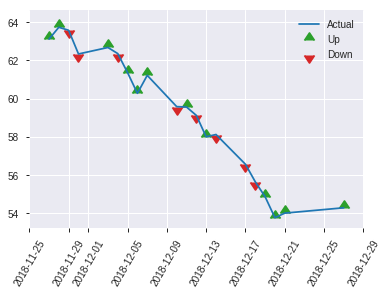


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19558924022372287
RMSE: 0.44225472323506376
LogLoss: 0.5747658531348225
Mean Per-Class Error: 0.28135483870967737
AUC: 0.7686451612903226
pr_auc: 0.7346084228198178
Gini: 0.5372903225806451
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39509226943245057: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   63   0.504    (63.0/125.0)
1      14   110  0.1129   (14.0/124.0)
Total  76   173  0.3092   (77.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.395092     0.740741  172
max f2                       0.26682      0.858369  202
max f0point5                 0.545124     0.72695   109
max accuracy                 0.545124     0.718876  109
max precision                0.899997     1         0
max recall                   0.0697444    1         240
max specificity              0.899997     1         0
max absolute_mcc             0.545124     0.440283  109
max min_per_class_accuracy   0.51394      0.696     124
max mean_per_class_accuracy  0.545124     0.718645  109

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 48.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.847841           2.00806   2.00806            1                0.871998  1                           0.871998            0.0241935       0.0241935                  100.806   100.806
    2        0.0200803                   0.843788           2.00806   2.00806            1                0.845951  1                           0.86158             0.016129        0.0403226                  100.806   100.806
    3        0.0321285                   0.816891           1.33871   1.75706            0.666667         0.833784  0.875                       0.851156            0.016129        0.0564516                  33.871    75.7056
    4        0.0401606                   0.802714           1.00403   1.60645            0.5              0.814932  0.8                         0.843911            0.00806452      0.0645161                  0.403226  60.6452
    5        0.0522088                   0.785782           1.33871   1.54467            0.666667         0.79701   0.769231                    0.833088            0.016129        0.0806452                  33.871    54.4665
    6        0.100402                    0.732936           1.84073   1.68677            0.916667         0.757925  0.84                        0.79701             0.0887097       0.169355                   84.0726   68.6774
    7        0.15261                     0.705101           1.54467   1.63816            0.769231         0.72134   0.815789                    0.771123            0.0806452       0.25                       54.4665   63.8158
    8        0.200803                    0.678944           1.33871   1.56629            0.666667         0.689549  0.78                        0.751545            0.0645161       0.314516                   33.871    56.629
    9        0.301205                    0.63003            1.44581   1.52613            0.72             0.655771  0.76                        0.719621            0.145161        0.459677                   44.5806   52.6129
    10       0.401606                    0.571455           1.36548   1.48597            0.68             0.597562  0.74                        0.689106            0.137097        0.596774                   36.5484   48.5968
    11       0.502008                    0.51394            1.04419   1.39761            0.52             0.538624  0.696                       0.659009            0.104839        0.701613                   4.41935   39.7613
    12       0.598394                    0.448348           0.920363  1.32074            0.458333         0.477943  0.657718                    0.629844            0.0887097       0.790323                   -7.96371  32.074
    13       0.698795                    0.391288           0.963871  1.26947            0.48             0.421753  0.632184                    0.599946            0.0967742       0.887097                   -3.6129   26.9466
    14       0.799197                    0.290752           0.722903  1.2008             0.36             0.349942  0.59799                     0.568539            0.0725806       0.959677                   -27.7097  20.0802
    15       0.899598                    0.16761            0.160645  1.08471            0.08             0.219032  0.540179                    0.529531            0.016129        0.975806                   -83.9355  8.47134
    16       1                           0.0153456          0.240968  1                  0.12             0.098253  0.497992                    0.48623            

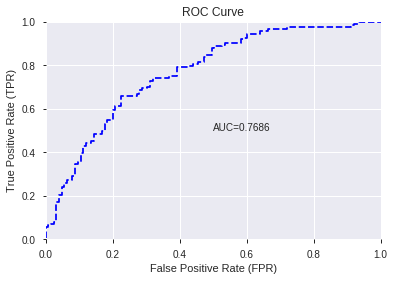

This function is available for GLM models only


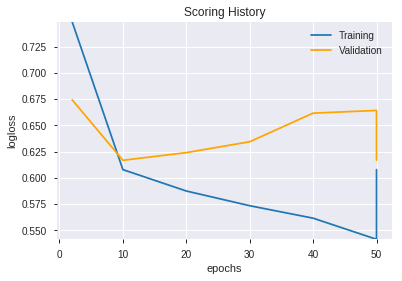

--2019-08-28 15:25:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.94.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.94.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_151817_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_151817_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_9b1a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'TRANGE',
 'DIV',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'aroonup_30',
 'STOCHF_fastk',
 'CDLLONGLINE',
 'day',
 'CDLSHORTLINE',
 'BETA_12',
 'STOCHRSI_fastk',
 'quarter',
 'EXP',
 'TANH',
 'CDLSTICKSANDWICH',
 'OBV',
 'ADOSC',
 'week',
 'CDLONNECK',
 'dayofweek',
 'aroonup_8',
 'CDLDARKCLOUDCOVER',
 'SINH',
 'CDLENGULFING',
 'CDLSPINNINGTOP',
 'ULTOSC',
 'CDLHAMMER',
 'CDLINNECK',
 'SAREXT',
 'CDLPIERCING',
 'aroondown_14',
 'STOCH_slowd',
 'CDLBELTHOLD',
 'CDLMORNINGSTAR',
 'CDL3WHITESOLDIERS',
 'CDLGAPSIDESIDEWHITE',
 'weekday',
 'CORREL_8',
 'HT_TRENDMODE',
 'DX_8',
 'COS',
 'CDL2CROWS',
 'SIN',
 'CDLLADDERBOTTOM',
 'weekday_name',
 'aroondown_8',
 'CDLUPSIDEGAP2CROWS',
 'is_quarter_start',
 'CDLEVENINGDOJISTAR']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_152540_model_1  0.769806  0.577612              0.308323  0.444086  0.197213

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.446075           1.000000    0.143873
1          STOCHF_fastk             0.151796           0.340292    0.048959
2                   DIV             0.142945           0.320450    0.046104
3                   SUB             0.133386           0.299021    0.043021
4                ULTOSC             0.123420           0.276680    0.039807
5           STOCH_slowd             0.123058           0.275868    0.039690
6             CDLHAMMER             0.101292           0.227074    0.032670
7                SAREXT             0.099062           0.222075    0.031951
8    CDLCLOSINGMARUBOZU             0.097482           0.218534    0.031441
9                  TANH             0.097426           0.218407    0.031423
10           aroonup_30             0.093840           0.210369    0.030266
11         CDLENGULFING             0.092988           0.208458    0.029991
12       STOCHRSI_fastk             0.075562           0.169392    0.024371
13            CDL2CROWS             0.071640           0.160600    0.023106
14      CDLLADDERBOTTOM             0.066086           0.148150    0.021315
15            aroonup_8             0.065736           0.147366    0.021202
16                  COS             0.065693           0.147270    0.021188
17                ADOSC             0.064670           0.144975    0.020858
18     CDLSTICKSANDWICH             0.064626           0.144877    0.020844
19   CDLUPSIDEGAP2CROWS             0.062407           0.139903    0.020128
20          CDLBELTHOLD             0.062021           0.139038    0.020004
21               TRANGE             0.057858           0.129706    0.018661
22                 week             0.055157           0.123649    0.017790
23    CDLDARKCLOUDCOVER             0.053854           0.120729    0.017370
24    CDL3WHITESOLDIERS             0.051669           0.115831    0.016665
25          aroondown_8             0.051553           0.115570    0.016627
26          CDLLONGLINE             0.051407           0.115243    0.016580
27   CDLEVENINGDOJISTAR             0.043922           0.098464    0.014166
28                 DX_8             0.042747           0.095830    0.013787
29       CDLSPINNINGTOP             0.041071           0.092071    0.013247
30     is_quarter_start             0.037710           0.084537    0.012163
31                  EXP             0.035501           0.079585    0.011450
32                 SINH             0.035351           0.079248    0.011402
33         weekday_name             0.035121           0.078734    0.011328
34                  SIN             0.028996           0.065002    0.009352
35          CDLPIERCING             0.028961           0.064924    0.009341
36                  OBV             0.025158           0.056398    0.008114
37  CDLGAPSIDESIDEWHITE             0.021965           0.049240    0.007084
38              BETA_12             0.019407           0.043506    0.006259
39              quarter             0.015759           0.035329    0.005083
40         HT_TRENDMODE             0.010648           0.023871    0.003434
41            CDLONNECK             0.010287           0.023061    0.003318
42         CDLSHORTLINE             0.007658           0.017167    0.002470
43             CORREL_8             0.007136           0.015998    0.002302
44            CDLINNECK             0.006876           0.015414    0.002218
45              weekday             0.006234           0.013975    0.002011
46            dayofweek             0.006211           0.013923    0.002003
47       CDLMORNINGSTAR             0.004828           0.010822    0.001557
48                  day             0.004532           0.010160    0.001462
49         aroondown_14             0.001700           0.003810    0.000548

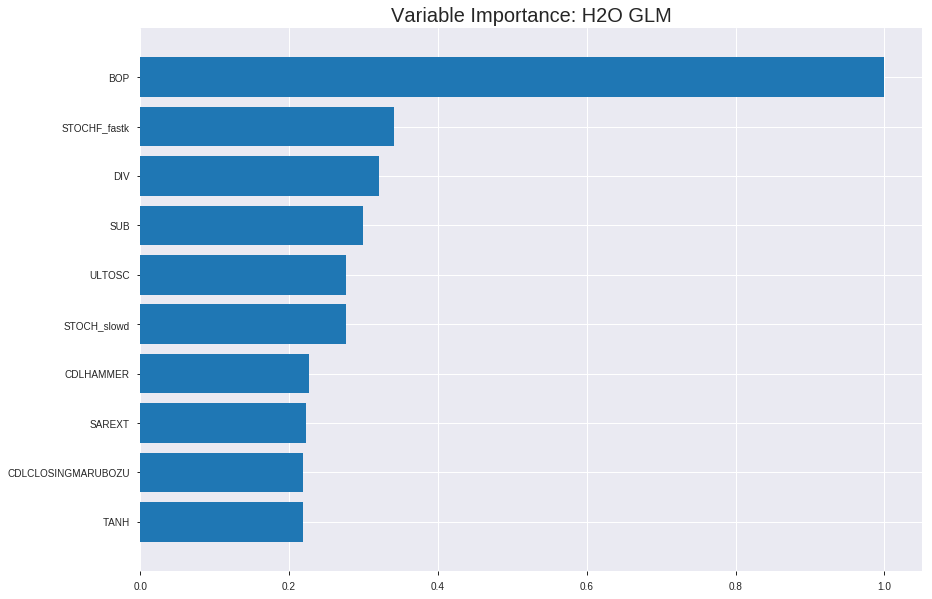

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_152540_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.21007753692520345
RMSE: 0.4583421614091414
LogLoss: 0.6075686291143457
Null degrees of freedom: 1740
Residual degrees of freedom: 1690
Null deviance: 2411.4007677758414
Residual deviance: 2115.5539665761517
AIC: 2217.5539665761517
AUC: 0.7287273399926009
pr_auc: 0.7156477473803365
Gini: 0.45745467998520173
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40705177146411414: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      366  474   0.5643   (474.0/840.0)
1      131  770   0.1454   (131.0/901.0)
Total  497  1244  0.3475   (605.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.407052     0.717949  256
max f2                       0.197885     0.853333  359
max f0point5                 0.531094     0.692049  183
max accuracy                 0.531094     0.680643  183
max precision                0.96153      1         0
max recall                   0.108633     1         389
max specificity              0.96153      1         0
max absolute_mcc             0.531094     0.360783  183
max min_per_class_accuracy   0.535872     0.675916  181
max mean_per_class_accuracy  0.531094     0.680452  183

Gains/Lift Table: Avg response rate: 51.75 %, avg score: 51.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.851753           1.61025   1.61025            0.833333         0.879032  0.833333                    0.879032            0.0166482       0.0166482                  61.0248   61.0248
    2        0.0201034                   0.832044           1.5913    1.60105            0.823529         0.841431  0.828571                    0.860769            0.0155383       0.0321865                  59.1304   60.1046
    3        0.0304423                   0.811427           1.5029    1.56771            0.777778         0.821625  0.811321                    0.847474            0.0155383       0.0477248                  50.2898   56.7713
    4        0.0402068                   0.793365           1.70497   1.60105            0.882353         0.803421  0.828571                    0.836776            0.0166482       0.0643729                  70.4968   60.1046
    5        0.0505457                   0.784802           1.39555   1.55901            0.722222         0.789523  0.806818                    0.82711             0.0144284       0.0788013                  39.5548   55.9013
    6        0.100517                    0.743646           1.48809   1.52375            0.770115         0.763965  0.788571                    0.795718            0.0743618       0.153163                   48.8091   52.3755
    7        0.150488                    0.709553           1.48809   1.51191            0.770115         0.726062  0.782443                    0.772588            0.0743618       0.227525                   48.8091   51.1912
    8        0.20046                     0.684248           1.35483   1.47275            0.701149         0.69595   0.762178                    0.753483            0.0677026       0.295228                   35.4829   47.2754
    9        0.300402                    0.635557           1.35483   1.43352            0.701149         0.659701  0.741874                    0.722282            0.135405        0.430633                   35.4829   43.3521
    10       0.400345                    0.590781           1.24378   1.38615            0.643678         0.611887  0.71736                     0.694723            0.124306        0.554939                   24.3778   38.6153
    11       0.500287                    0.536303           1.16604   1.34218            0.603448         0.563179  0.694604                    0.668445            0.116537        0.671476                   16.6042   34.2181
    12       0.60023                     0.47975            0.888413  1.26663            0.45977          0.510263  0.655502                    0.642106            0.0887902       0.760266                   -11.1587  26.6626
    13       0.700172                    0.416806           0.821782  1.20313            0.425287         0.447859  0.622642                    0.614379            0.082131        0.842397                   -17.8218  20.3129
    14       0.800115                    0.350861           0.68852   1.13885            0.356322         0.383727  0.589375                    0.585569            0.0688124       0.91121                    -31.148   13.8849
    15       0.900057                    0.260536           0.632994  1.08268            0.327586         0.304666  0.560306                    0.554377            0.063263        0.974473                   -36.7006  8.26785
    16       1                           0.0330596          0.255419  1                  0.132184         0.185581  0.517519                    0.517519         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21336648140962336
RMSE: 0.4619160978030787
LogLoss: 0.6141527884125699
Null degrees of freedom: 497
Residual degrees of freedom: 447
Null deviance: 690.4254926589902
Residual deviance: 611.6961772589195
AIC: 713.6961772589195
AUC: 0.7200451722190853
pr_auc: 0.7186952410449307
Gini: 0.4400903444381705
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36446670432583217: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      85   160  0.6531   (160.0/245.0)
1      17   236  0.0672   (17.0/253.0)
Total  102  396  0.3554   (177.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.364467     0.727273  311
max f2                       0.225815     0.845166  370
max f0point5                 0.625257     0.662589  137
max accuracy                 0.472542     0.660643  235
max precision                0.874869     1         0
max recall                   0.098674     1         390
max specificity              0.874869     1         0
max absolute_mcc             0.364467     0.346544  311
max min_per_class_accuracy   0.538211     0.640816  191
max mean_per_class_accuracy  0.472542     0.658974  235

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 52.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.841688           1.96838   1.96838            1                0.860938  1                           0.860938            0.0197628       0.0197628                  96.8379   96.8379
    2        0.0200803                   0.806              1.96838   1.96838            1                0.823705  1                           0.842321            0.0197628       0.0395257                  96.8379   96.8379
    3        0.0301205                   0.794214           1.96838   1.96838            1                0.800238  1                           0.828293            0.0197628       0.0592885                  96.8379   96.8379
    4        0.0401606                   0.790289           1.96838   1.96838            1                0.791954  1                           0.819209            0.0197628       0.0790514                  96.8379   96.8379
    5        0.0502008                   0.785358           0.393676  1.65344            0.2              0.788173  0.84                        0.813001            0.00395257      0.083004                   -60.6324  65.3439
    6        0.100402                    0.751459           1.73217   1.69281            0.88             0.767618  0.86                        0.79031             0.0869565       0.16996                    73.2174   69.2806
    7        0.150602                    0.718804           1.3385    1.5747             0.68             0.736402  0.8                         0.772341            0.0671937       0.237154                   33.8498   57.4704
    8        0.200803                    0.700897           1.25976   1.49597            0.64             0.709179  0.76                        0.75655             0.0632411       0.300395                   25.9763   49.5968
    9        0.301205                    0.652586           1.37787   1.4566             0.7              0.672781  0.74                        0.728627            0.13834         0.438735                   37.7866   45.6601
    10       0.399598                    0.608423           1.08462   1.36501            0.55102          0.630231  0.693467                    0.704399            0.106719        0.545455                   8.46172   36.5007
    11       0.5                         0.542057           0.905455  1.27273            0.46             0.572812  0.646586                    0.677976            0.0909091       0.636364                   -9.45455  27.2727
    12       0.600402                    0.475369           1.14166   1.25081            0.58             0.508441  0.635452                    0.649625            0.114625        0.750988                   14.166    25.081
    13       0.698795                    0.419928           1.00428   1.2161             0.510204         0.445447  0.617816                    0.620876            0.0988142       0.849802                   0.427523  21.6096
    14       0.799197                    0.359428           0.826719  1.16718            0.42             0.392952  0.592965                    0.592242            0.083004        0.932806                   -17.3281  16.718
    15       0.899598                    0.261463           0.314941  1.07206            0.16             0.312578  0.544643                    0.56103             0.0316206       0.964427                   -68.5059  7.20638
    16       1                           0.00358531         0.354308  1                  0.18             0.178926  0.508032                    0.522666           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 15:25:41  0.000 sec   2            17        51            1.37165           1.37278
    2019-08-28 15:25:41  0.076 sec   4            10        51            1.36453           1.36555
    2019-08-28 15:25:41  0.148 sec   6            6.5       51            1.35442           1.3553
    2019-08-28 15:25:41  0.222 sec   8            4         51            1.34091           1.34161
    2019-08-28 15:25:41  0.243 sec   10           2.5       51            1.32422           1.32471
    2019-08-28 15:25:41  0.266 sec   12           1.6       51            1.30541           1.30568
    2019-08-28 15:25:41  0.293 sec   14           0.97      51            1.28624           1.28636
    2019-08-28 15:25:41  0.315 sec   16           0.6       51            1.26853           1.26871
    2019-08-28 15:25:41  0.345 sec   18           0.37      51            1.25345           1.25409
    2019-08-28 15:25:41  0.371 sec   20           0.23      51            1.24138           1.24309
    2019-08-28 15:25:41  0.395 sec   22           0.14      51            1.23204           1.23555
    2019-08-28 15:25:41  0.422 sec   24           0.09      51            1.22483           1.23093
    2019-08-28 15:25:41  0.448 sec   26           0.056     51            1.21929           1.22867
    2019-08-28 15:25:41  0.473 sec   28           0.035     51            1.21514           1.22831
    2019-08-28 15:25:41  0.496 sec   30           0.021     51            1.2122            1.22943
    2019-08-28 15:25:41  0.515 sec   32           0.013     51            1.21027           1.2316
    2019-08-28 15:25:41  0.530 sec   34           0.0083    51            1.20908           1.23442
    2019-08-28 15:25:41  0.550 sec   36           0.0051    51            1.2084            1.23758
    2019-08-28 15:25:41  0.562 sec   37           0.0032    51            1.20804           1.24045

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7068273092369478)

('F1', 0.7475409836065573)

('auc', 0.7698064516129032)

('logloss', 0.5776122494833619)

('mean_per_class_error', 0.2925483870967742)

('rmse', 0.44408622299024614)

('mse', 0.1972125734497426)

glm prediction progress: |████████████████████████████████████████████████| 100%


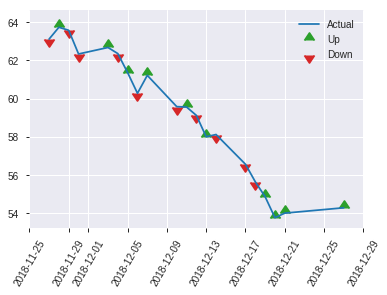


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1972125734497426
RMSE: 0.44408622299024614
LogLoss: 0.5776122494833619
Null degrees of freedom: 248
Residual degrees of freedom: 198
Null deviance: 345.5632631583502
Residual deviance: 287.6509002427142
AIC: 389.6509002427142
AUC: 0.7698064516129032
pr_auc: 0.7360437186204587
Gini: 0.5396129032258064
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3662452341698713: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      58   67   0.536    (67.0/125.0)
1      10   114  0.0806   (10.0/124.0)
Total  68   181  0.3092   (77.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.366245     0.747541  180
max f2                       0.249167     0.86014   218
max f0point5                 0.614165     0.702381  73
max accuracy                 0.408837     0.706827  162
max precision                0.872045     1         0
max recall                   0.212841     1         227
max specificity              0.872045     1         0
max absolute_mcc             0.408837     0.436284  162
max min_per_class_accuracy   0.504024     0.68      124
max mean_per_class_accuracy  0.408837     0.707452  162

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 48.77 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.82292            2.00806    2.00806            1                0.848903  1                           0.848903            0.0241935       0.0241935                  100.806   100.806
    2        0.0200803                   0.803992           2.00806    2.00806            1                0.809184  1                           0.833015            0.016129        0.0403226                  100.806   100.806
    3        0.0321285                   0.775652           2.00806    2.00806            1                0.790298  1                           0.816996            0.0241935       0.0645161                  100.806   100.806
    4        0.0401606                   0.750595           1.00403    1.80726            0.5              0.762349  0.9                         0.806067            0.00806452      0.0725806                  0.403226  80.7258
    5        0.0522088                   0.749051           0          1.3902             0                0.74967   0.692308                    0.793052            0               0.0725806                  -100      39.0199
    6        0.100402                    0.717046           1.84073    1.60645            0.916667         0.731542  0.8                         0.763527            0.0887097       0.16129                    84.0726   60.6452
    7        0.15261                     0.677299           1.69913    1.63816            0.846154         0.698074  0.815789                    0.741136            0.0887097       0.25                       69.9132   63.8158
    8        0.200803                    0.653734           1.84073    1.68677            0.916667         0.666253  0.84                        0.723164            0.0887097       0.33871                    84.0726   68.6774
    9        0.301205                    0.609843           1.36548    1.57968            0.68             0.630184  0.786667                    0.692171            0.137097        0.475806                   36.5484   57.9677
    10       0.401606                    0.551161           0.963871   1.42573            0.48             0.577475  0.71                        0.663497            0.0967742       0.572581                   -3.6129   42.5726
    11       0.502008                    0.504024           1.12452    1.36548            0.56             0.52946   0.68                        0.636689            0.112903        0.685484                   12.4516   36.5484
    12       0.598394                    0.448279           1.00403    1.30726            0.5              0.474297  0.651007                    0.610532            0.0967742       0.782258                   0.403226  30.7263
    13       0.698795                    0.382072           1.04419    1.26947            0.52             0.414721  0.632184                    0.582398            0.104839        0.887097                   4.41935   26.9466
    14       0.799197                    0.32369            0.722903   1.2008             0.36             0.35611   0.59799                     0.55397             0.0725806       0.959677                   -27.7097  20.0802
    15       0.899598                    0.227879           0.32129    1.10264            0.16             0.275804  0.549107                    0.522925            0.0322581       0.991935                   -67.871   10.2643
    16       1                           0.0625566          0.0803226  1                  0.04             0.171768  0.497992                   

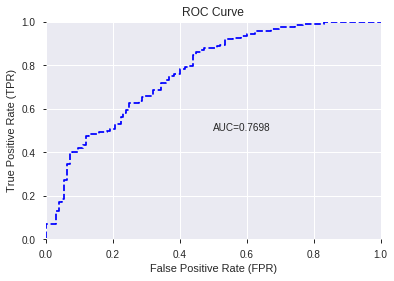

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


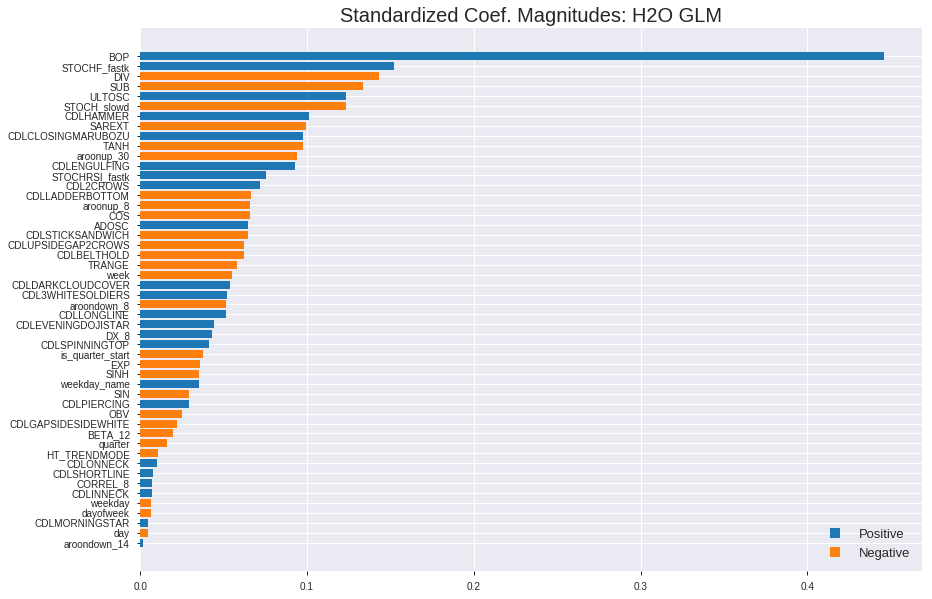

'log_likelihood'
--2019-08-28 15:25:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.238.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.238.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_152540_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_152540_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_9b1a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'STOCHF_fastk',
 'DIV',
 'SUB',
 'ULTOSC',
 'STOCH_slowd',
 'CDLHAMMER',
 'SAREXT',
 'CDLCLOSINGMARUBOZU',
 'TANH',
 'aroonup_30',
 'CDLENGULFING',
 'STOCHRSI_fastk',
 'CDL2CROWS',
 'CDLLADDERBOTTOM',
 'aroonup_8',
 'COS',
 'ADOSC',
 'CDLSTICKSANDWICH',
 'CDLUPSIDEGAP2CROWS',
 'CDLBELTHOLD',
 'TRANGE',
 'week',
 'CDLDARKCLOUDCOVER',
 'CDL3WHITESOLDIERS',
 'aroondown_8',
 'CDLLONGLINE',
 'CDLEVENINGDOJISTAR',
 'DX_8',
 'CDLSPINNINGTOP',
 'is_quarter_start',
 'EXP',
 'SINH',
 'weekday_name',
 'SIN',
 'CDLPIERCING',
 'OBV',
 'CDLGAPSIDESIDEWHITE',
 'BETA_12',
 'quarter',
 'HT_TRENDMODE',
 'CDLONNECK',
 'CDLSHORTLINE',
 'CORREL_8',
 'CDLINNECK',
 'weekday',
 'dayofweek',
 'CDLMORNINGSTAR',
 'day',
 'aroondown_14']

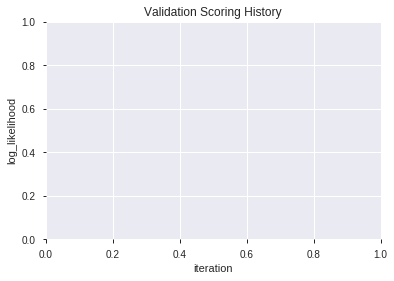

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_152552_model_4  0.761419  0.589369              0.332097  0.448864  0.201479
1  XGBoost_grid_1_AutoML_20190828_152552_model_2  0.759097  0.594209              0.288581  0.450678  0.203111
2               XGBoost_3_AutoML_20190828_152552  0.758839  0.593326              0.304387  0.450456  0.202911
3               XGBoost_2_AutoML_20190828_152552  0.756903  0.591314              0.296516  0.449526  0.202074
4  XGBoost_grid_1_AutoML_20190828_152552_model_6  0.756323  0.595100              0.304258  0.452031  0.204332
5  XGBoost_grid_1_AutoML_20190828_152552_model_7  0.745806  0.597046              0.276871  0.452892  0.205111
6  XGBoost_grid_1_AutoML_20190828_152552_model_3  0.745032  0.600388              0.332387  0.454271  0.206362
7  XGBoost_grid_1_AutoML_20190828_152552_model_1  0.744323  0.597780              0.360129  0.453733  0.205874
8               XGBoost_1_AutoML_20190828_152552  0.739742  0.599915              0.352129  0.454709  0.206760
9  XGBoost_grid_1_AutoML_20190828_152552_model_5  0.713032  0.623459              0.320516  0.465814  0.216983

variable  relative_importance  scaled_importance  percentage
0              BOP          1537.168213           1.000000    0.356355
1              DIV           331.482819           0.215645    0.076846
2              COS           237.697845           0.154634    0.055104
3              SUB           217.845032           0.141718    0.050502
4     STOCHF_fastk           211.697784           0.137719    0.049077
5             DX_8           184.784683           0.120211    0.042838
6   STOCHRSI_fastk           172.330795           0.112109    0.039951
7           SAREXT           156.838409           0.102031    0.036359
8         CORREL_8           150.677231           0.098023    0.034931
9            ADOSC           125.262909           0.081489    0.029039
10             OBV           120.433998           0.078348    0.027920
11      aroonup_30           117.486061           0.076430    0.027236
12         BETA_12           103.976524           0.067642    0.024104
13          TRANGE            82.800606           0.053866    0.019195
14       aroonup_8            79.073692           0.051441    0.018331
15             EXP            77.865784           0.050655    0.018051
16            week            71.879913           0.046761    0.016664
17     STOCH_slowd            70.740730           0.046020    0.016399
18          ULTOSC            68.512009           0.044570    0.015883
19             SIN            59.171059           0.038494    0.013717
20             day            58.456245           0.038029    0.013552
21    aroondown_14            35.275772           0.022949    0.008178
22     aroondown_8            25.849464           0.016816    0.005993
23    weekday_name             9.819901           0.006388    0.002277
24       dayofweek             3.888525           0.002530    0.000901
25         quarter             2.576296           0.001676    0.000597

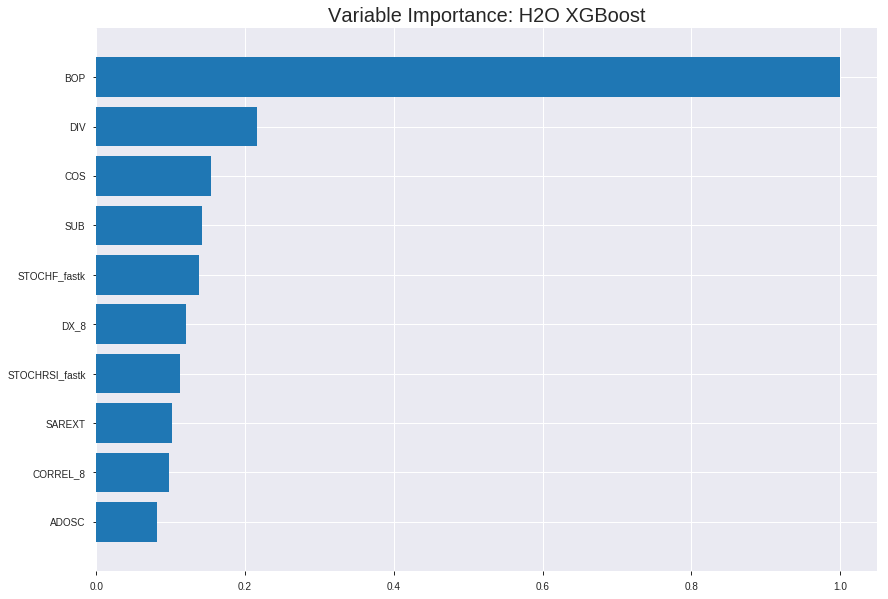

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_152552_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19027456536913967
RMSE: 0.4362047287331256
LogLoss: 0.5645702907974127
Mean Per-Class Error: 0.276730881031658
AUC: 0.7948978648062999
pr_auc: 0.8000741242557472
Gini: 0.5897957296125997
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4084552973508835: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      409  431   0.5131   (431.0/840.0)
1      103  798   0.1143   (103.0/901.0)
Total  512  1229  0.3067   (534.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.408455     0.749296  261
max f2                       0.32418      0.860151  308
max f0point5                 0.572196     0.742951  159
max accuracy                 0.553999     0.721999  172
max precision                0.846826     1         0
max recall                   0.152011     1         388
max specificity              0.846826     1         0
max absolute_mcc             0.564406     0.447397  165
max min_per_class_accuracy   0.534215     0.719201  183
max mean_per_class_accuracy  0.553999     0.723269  172

Gains/Lift Table: Avg response rate: 51.75 %, avg score: 51.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.806393           1.82495   1.82495            0.944444         0.821022  0.944444                    0.821022            0.0188679       0.0188679                  82.4948   82.4948
    2        0.0201034                   0.795376           1.9323    1.87709            1                0.801532  0.971429                    0.811556            0.0188679       0.0377358                  93.2297   87.7089
    3        0.0304423                   0.788124           1.82495   1.85938            0.944444         0.791622  0.962264                    0.804786            0.0188679       0.0566038                  82.4948   85.9381
    4        0.0402068                   0.77962            1.9323    1.87709            1                0.783927  0.971429                    0.79972             0.0188679       0.0754717                  93.2297   87.7089
    5        0.0505457                   0.771205           1.9323    1.88838            1                0.775241  0.977273                    0.794713            0.0199778       0.0954495                  93.2297   88.8382
    6        0.100517                    0.746864           1.68798   1.78876            0.873563         0.757906  0.925714                    0.776415            0.0843507       0.1798                     68.7984   78.8755
    7        0.150488                    0.719457           1.42146   1.66679            0.735632         0.731934  0.862595                    0.761644            0.0710322       0.250832                   42.146    66.6791
    8        0.20046                     0.691855           1.64356   1.661              0.850575         0.707424  0.859599                    0.748128            0.082131        0.332963                   64.3563   66.1001
    9        0.300402                    0.641734           1.47699   1.59978            0.764368         0.66677   0.827916                    0.721061            0.147614        0.480577                   47.6986   59.978
    10       0.400345                    0.587362           1.24378   1.51091            0.643678         0.616474  0.781923                    0.694952            0.124306        0.604883                   24.3778   51.0907
    11       0.500287                    0.536385           1.0661    1.42205            0.551724         0.564074  0.735936                    0.668806            0.106548        0.711432                   6.60951   42.2047
    12       0.60023                     0.479989           0.899518  1.33504            0.465517         0.509193  0.690909                    0.642229            0.0899001       0.801332                   -10.0482  33.5042
    13       0.700172                    0.411046           0.788466  1.25702            0.408046         0.44737   0.650533                    0.614415            0.0788013       0.880133                   -21.1534  25.7024
    14       0.800115                    0.343675           0.655204  1.18185            0.33908          0.378064  0.61163                     0.584893            0.0654828       0.945616                   -34.4796  18.185
    15       0.900057                    0.247247           0.34426   1.08884            0.178161         0.293959  0.563497                    0.552587            0.0344062       0.980022                   -65.574   8.88441
    16       1                           0.123009           0.199893  1                  0.103448         0.194058  0.517519                    0.516755           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2157807086102772
RMSE: 0.4645220216634269
LogLoss: 0.621205377112486
Mean Per-Class Error: 0.3346858110833266
AUC: 0.7164152617568766
pr_auc: 0.7066019558162726
Gini: 0.4328305235137533
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4129258692264557: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      98   147  0.6      (147.0/245.0)
1      28   225  0.1107   (28.0/253.0)
Total  126  372  0.3514   (175.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.412926     0.72      291
max f2                       0.266541     0.844595  371
max f0point5                 0.583525     0.674264  156
max accuracy                 0.554563     0.664659  179
max precision                0.812533     1         0
max recall                   0.137294     1         397
max specificity              0.812533     1         0
max absolute_mcc             0.412926     0.332719  291
max min_per_class_accuracy   0.532983     0.660079  195
max mean_per_class_accuracy  0.554563     0.665314  179

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 52.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.791048           1.96838   1.96838            1                0.798606  1                           0.798606            0.0197628       0.0197628                  96.8379   96.8379
    2        0.0200803                   0.778042           1.5747    1.77154            0.8              0.783689  0.9                         0.791148            0.0158103       0.0355731                  57.4704   77.1542
    3        0.0301205                   0.776983           1.96838   1.83715            1                0.77737   0.933333                    0.786555            0.0197628       0.055336                   96.8379   83.7154
    4        0.0401606                   0.764136           1.18103   1.67312            0.6              0.770742  0.85                        0.782602            0.0118577       0.0671937                  18.1028   67.3123
    5        0.0502008                   0.760917           1.5747    1.65344            0.8              0.76259   0.84                        0.7786              0.0158103       0.083004                   57.4704   65.3439
    6        0.100402                    0.733592           1.49597   1.5747             0.76             0.745204  0.8                         0.761902            0.0750988       0.158103                   49.5968   57.4704
    7        0.150602                    0.706068           1.49597   1.54846            0.76             0.72094   0.786667                    0.748248            0.0750988       0.233202                   49.5968   54.8458
    8        0.200803                    0.677165           1.02356   1.41723            0.52             0.692041  0.72                        0.734196            0.0513834       0.284585                   2.35573   41.7233
    9        0.301205                    0.628415           1.4566    1.43036            0.74             0.655478  0.726667                    0.707957            0.146245        0.43083                    45.6601   43.0356
    10       0.399598                    0.583512           1.28547   1.39468            0.653061         0.606443  0.708543                    0.682961            0.126482        0.557312                   28.5472   39.4681
    11       0.5                         0.532766           1.02356   1.32016            0.52             0.560416  0.670683                    0.658353            0.102767        0.660079                   2.35573   32.0158
    12       0.600402                    0.491675           0.866087  1.24423            0.44             0.515525  0.632107                    0.634469            0.0869565       0.747036                   -13.3913  24.4226
    13       0.698795                    0.436798           0.763249  1.1765             0.387755         0.463152  0.597701                    0.610347            0.0750988       0.822134                   -23.6751  17.6503
    14       0.799197                    0.382763           0.944822  1.1474             0.48             0.411257  0.582915                    0.585335            0.0948617       0.916996                   -5.51779  14.7397
    15       0.899598                    0.317897           0.551146  1.08085            0.28             0.354452  0.549107                    0.559567            0.055336        0.972332                   -44.8854  8.08512
    16       1                           0.119398           0.275573  1                  0.14             0.233634  0.508032                    0.526843         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:26:04  4.069 sec   0                  0.5              0.693147            0.5             0                  1                0.482481                         0.5                0.693147              0.5               0                    1                  0.491968
    2019-08-28 15:26:04  4.186 sec   5                  0.484589         0.662673            0.743071        0.733497           1.85798          0.359563                         0.488728           0.670775              0.699718          0.675556             1.5747             0.385542
    2019-08-28 15:26:04  4.265 sec   10                 0.473545         0.640968            0.751235        0.744132           1.7176           0.324526                         0.480943           0.655328              0.704388          0.697138             1.96838            0.36747
    2019-08-28 15:26:04  4.338 sec   15                 0.464855         0.623772            0.760695        0.747767           1.7176           0.333716                         0.475399           0.644163              0.710866          0.706863             1.96838            0.39759
    2019-08-28 15:26:04  4.432 sec   20                 0.459355         0.612746            0.764749        0.75666            1.7176           0.341758                         0.47178            0.636783              0.711245          0.702619             1.96838            0.393574
    2019-08-28 15:26:04  4.505 sec   25                 0.454848         0.603502            0.767664        0.763019           1.9323           0.314187                         0.469511           0.632065              0.713947          0.705468             1.5747             0.373494
    2019-08-28 15:26:04  4.586 sec   30                 0.451183         0.595794            0.770567        0.765859           1.9323           0.337737                         0.467991           0.628739              0.713624          0.705855             1.96838            0.361446
    2019-08-28 15:26:04  4.667 sec   35                 0.448164         0.58946             0.774478        0.775467           1.9323           0.325101                         0.466644           0.62591               0.715649          0.703869             1.96838            0.35743
    2019-08-28 15:26:04  4.747 sec   40                 0.445515         0.58387             0.778281        0.780808           1.9323           0.330844                         0.466502           0.625461              0.714157          0.706815             1.96838            0.371486
    2019-08-28 15:26:04  4.833 sec   45                 0.442624         0.577877            0.782957        0.78266            1.9323           0.330844                         0.465373           0.62302               0.716286          0.707589             1.96838            0.355422
    2019-08-28 15:26:04  4.934 sec   50                 0.44026          0.572913            0.786989        0.791042           1.82495          0.31189                          0.465109           0.622321              0.714673          0.706804             1.96838            0.369478
    2019-08-28 15:26:05  5.022 sec   55                 0.438175         0.568518            0.790432        0.794829           1.9323           0.307295                         0.464748           0.62153               0.714729          0.70

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ---------------------
BOP           1537.168212890625      1.0                    0.3563545429184111
DIV           331.4828186035156      0.21564511666564223    0.07684611698197238
COS           237.69784545898438     0.1546335940762115     0.055104383736859476
SUB           217.84503173828125     0.1417184078563702     0.05050199845478176
STOCHF_fastk  211.69778442382812     0.13771933523510296    0.04907691075873255
---           ---                    ---                    ---
aroondown_14  35.27577209472656      0.02294854382162309    0.008177817844197625
aroondown_8   25.849464416503906     0.0168162886792294     0.005992560865870845
weekday_name  9.819900512695312      0.006388305736708617   0.0022765017708278627
dayofweek     3.8885254859924316     0.002529668160831995   0.0009014587411885432
quarter       2.576296329498291      0.0016760015643659447  0.0005972507714001683


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7068273092369478)

('F1', 0.7446153846153847)

('auc', 0.7614193548387096)

('logloss', 0.589369200775294)

('mean_per_class_error', 0.2931290322580645)

('rmse', 0.4488644771373465)

('mse', 0.2014793188357835)

xgboost prediction progress: |████████████████████████████████████████████| 100%


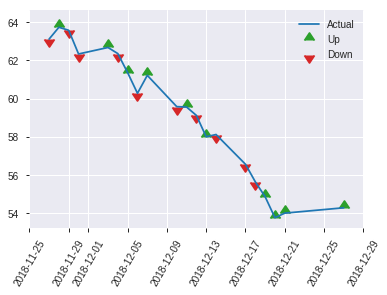


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2014793188357835
RMSE: 0.4488644771373465
LogLoss: 0.589369200775294
Mean Per-Class Error: 0.2931290322580645
AUC: 0.7614193548387096
pr_auc: 0.7246713275647904
Gini: 0.5228387096774192
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3563995659351349: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      45   80   0.64     (80.0/125.0)
1      3    121  0.0242   (3.0/124.0)
Total  48   201  0.3333   (83.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.3564       0.744615  200
max f2                       0.3564       0.868006  200
max f0point5                 0.506249     0.704114  126
max accuracy                 0.506249     0.706827  126
max precision                0.850845     1         0
max recall                   0.203268     1         240
max specificity              0.850845     1         0
max absolute_mcc             0.3564       0.425634  200
max min_per_class_accuracy   0.516967     0.696     124
max mean_per_class_accuracy  0.506249     0.706871  126

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 51.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.811662           2.00806   2.00806            1                0.831031  1                           0.831031            0.0241935       0.0241935                  100.806   100.806
    2        0.0200803                   0.794977           1.00403   1.60645            0.5              0.801596  0.8                         0.819257            0.00806452      0.0322581                  0.403226  60.6452
    3        0.0321285                   0.786417           2.00806   1.75706            1                0.791608  0.875                       0.808889            0.0241935       0.0564516                  100.806   75.7056
    4        0.0401606                   0.771328           2.00806   1.80726            1                0.778949  0.9                         0.802901            0.016129        0.0725806                  100.806   80.7258
    5        0.0522088                   0.761186           2.00806   1.8536             1                0.769199  0.923077                    0.795124            0.0241935       0.0967742                  100.806   85.3598
    6        0.100402                    0.724729           1.33871   1.60645            0.666667         0.743345  0.8                         0.77027             0.0645161       0.16129                    33.871    60.6452
    7        0.15261                     0.7001             1.54467   1.58531            0.769231         0.712999  0.789474                    0.750677            0.0806452       0.241935                   54.4665   58.5314
    8        0.200803                    0.682836           1.50605   1.56629            0.75             0.691044  0.78                        0.736365            0.0725806       0.314516                   50.6048   56.629
    9        0.301205                    0.63441            1.44581   1.52613            0.72             0.658113  0.76                        0.710281            0.145161        0.459677                   44.5806   52.6129
    10       0.401606                    0.576028           0.963871  1.38556            0.48             0.60523   0.69                        0.684018            0.0967742       0.556452                   -3.6129   38.5565
    11       0.502008                    0.516967           1.44581   1.39761            0.72             0.543923  0.696                       0.655999            0.145161        0.701613                   44.5806   39.7613
    12       0.598394                    0.464389           0.836694  1.30726            0.416667         0.489016  0.651007                    0.629103            0.0806452       0.782258                   -16.3306  30.7263
    13       0.698795                    0.418203           0.963871  1.25793            0.48             0.440561  0.626437                    0.602013            0.0967742       0.879032                   -3.6129   25.7925
    14       0.799197                    0.365061           0.883548  1.21089            0.44             0.398319  0.603015                    0.576424            0.0887097       0.967742                   -11.6452  21.0893
    15       0.899598                    0.29318            0.160645  1.09368            0.08             0.325727  0.544643                    0.548444            0.016129        0.983871                   -83.9355  9.3678
    16       1                           0.148298           0.160645  1                  0.08             0.215858  0.497992                    0.515052           

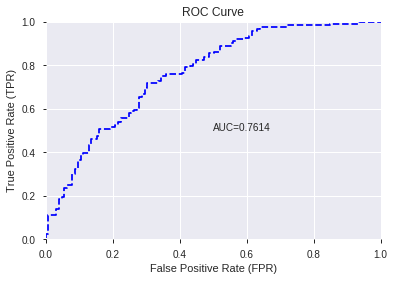

This function is available for GLM models only


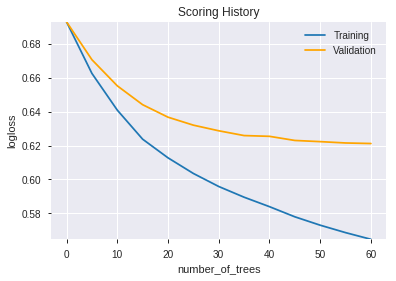

--2019-08-28 15:26:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_152552_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_152552_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_9b1a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'COS',
 'SUB',
 'STOCHF_fastk',
 'DX_8',
 'STOCHRSI_fastk',
 'SAREXT',
 'CORREL_8',
 'ADOSC',
 'OBV',
 'aroonup_30',
 'BETA_12',
 'TRANGE',
 'aroonup_8',
 'EXP',
 'week',
 'STOCH_slowd',
 'ULTOSC',
 'SIN',
 'day',
 'aroondown_14',
 'aroondown_8',
 'weekday_name',
 'dayofweek',
 'quarter']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_152625_model_1  0.752903  0.596717              0.284258  0.452547  0.204799

variable  relative_importance  scaled_importance    percentage
0                          BOP             0.268984           1.000000  3.643679e-02
1                          SUB             0.138639           0.515417  1.878012e-02
2                          DIV             0.126285           0.469489  1.710666e-02
3                 STOCHF_fastk             0.100163           0.372378  1.356824e-02
4                       TRANGE             0.099423           0.369626  1.346800e-02
...                        ...                  ...                ...           ...
1038  BBANDS_middleband_30_5_5             0.000007           0.000025  9.048737e-07
1039   BBANDS_upperband_20_3_2             0.000007           0.000024  8.916967e-07
1040  BBANDS_middleband_12_2_2             0.000006           0.000023  8.260061e-07
1041                   DEMA_20             0.000004           0.000013  4.854747e-07
1042  BBANDS_middleband_12_2_3             0.000003           0.000010  3.515518e-07

[1043 rows x 4 columns]

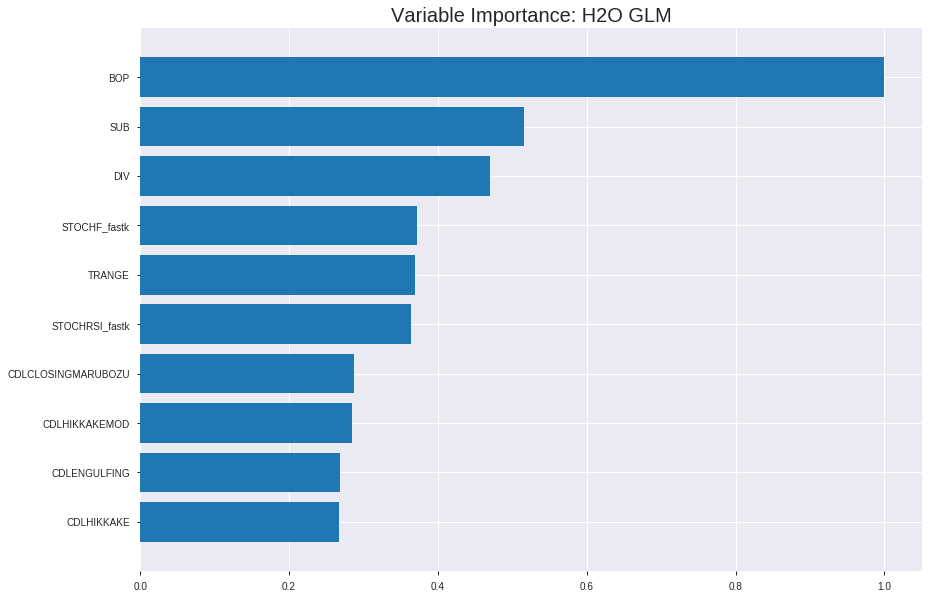

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_152625_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.20168343458610982
RMSE: 0.44909178859795446
LogLoss: 0.5895215364755887
Null degrees of freedom: 1740
Residual degrees of freedom: 697
Null deviance: 2411.4007677758414
Residual deviance: 2052.7139900079997
AIC: 4140.713990008
AUC: 0.7583524919401723
pr_auc: 0.7427402785114888
Gini: 0.5167049838803446
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37243917684072825: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      321  519   0.6179   (519.0/840.0)
1      85   816   0.0943   (85.0/901.0)
Total  406  1335  0.3469   (604.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.372439     0.729875  281
max f2                       0.22865      0.85466   353
max f0point5                 0.543328     0.71864   178
max accuracy                 0.543328     0.703619  178
max precision                0.911838     1         0
max recall                   0.179236     1         370
max specificity              0.911838     1         0
max absolute_mcc             0.543328     0.40891   178
max min_per_class_accuracy   0.530122     0.698113  186
max mean_per_class_accuracy  0.543328     0.704463  178

Gains/Lift Table: Avg response rate: 51.75 %, avg score: 51.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.846239           1.2882    1.2882             0.666667         0.870087  0.666667                    0.870087            0.0133185       0.0133185                  28.8198   28.8198
    2        0.0201034                   0.821241           1.81863   1.54584            0.941176         0.832028  0.8                         0.851601            0.017758        0.0310766                  81.8633   54.5838
    3        0.0304423                   0.809824           1.82495   1.64063            0.944444         0.815605  0.849057                    0.839376            0.0188679       0.0499445                  82.4948   64.063
    4        0.0402068                   0.794671           1.9323    1.71146            1                0.802721  0.885714                    0.830474            0.0188679       0.0688124                  93.2297   71.1463
    5        0.0505457                   0.785617           1.61025   1.69076            0.833333         0.790777  0.875                       0.822354            0.0166482       0.0854606                  61.0248   69.076
    6        0.100517                    0.739532           1.5103    1.60105            0.781609         0.761201  0.828571                    0.791952            0.0754717       0.160932                   51.0301   60.1046
    7        0.150488                    0.711007           1.55472   1.58566            0.804598         0.725595  0.820611                    0.769917            0.0776915       0.238624                   55.4722   58.5664
    8        0.20046                     0.686654           1.59914   1.58902            0.827586         0.698363  0.82235                     0.75208             0.0799112       0.318535                   59.9143   58.9024
    9        0.300402                    0.633847           1.34372   1.50741            0.695402         0.658775  0.780115                    0.721038            0.134295        0.45283                    34.3724   50.7414
    10       0.400345                    0.586111           1.24378   1.4416             0.643678         0.610761  0.746055                    0.693508            0.124306        0.577137                   24.3778   44.1599
    11       0.500287                    0.531838           1.14383   1.38211            0.591954         0.559436  0.71527                     0.666724            0.114317        0.691454                   14.3831   38.2114
    12       0.60023                     0.478434           0.877307  1.29806            0.454023         0.504471  0.67177                     0.639708            0.0876804       0.779134                   -12.2693  29.806
    13       0.700172                    0.413769           0.744046  1.21898            0.385057         0.448964  0.630845                    0.612481            0.0743618       0.853496                   -25.5954  21.898
    14       0.800115                    0.34559            0.699625  1.15411            0.362069         0.381811  0.597272                    0.583668            0.0699223       0.923418                   -30.0375  15.4107
    15       0.900057                    0.265506           0.533048  1.08514            0.275862         0.308366  0.561583                    0.553099            0.0532741       0.976693                   -46.6952  8.51447
    16       1                           0.0255536          0.233208  1                  0.12069          0.197096  0.517519                    0.517519            0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21484459149987817
RMSE: 0.4635133131851535
LogLoss: 0.6179850796263999
Null degrees of freedom: 497
Residual degrees of freedom: -546
Null deviance: 690.4254926589902
Residual deviance: 615.5131393078943
AIC: 2703.5131393078946
AUC: 0.7156328143905784
pr_auc: 0.6987796009308931
Gini: 0.4312656287811567
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2982756416273288: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      63   182  0.7429   (182.0/245.0)
1      13   240  0.0514   (13.0/253.0)
Total  76   422  0.3916   (195.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.298276     0.711111  337
max f2                       0.188082     0.847855  384
max f0point5                 0.554627     0.679522  173
max accuracy                 0.554627     0.666667  173
max precision                0.959211     1         0
max recall                   0.188082     1         384
max specificity              0.959211     1         0
max absolute_mcc             0.554627     0.340378  173
max min_per_class_accuracy   0.515973     0.636735  205
max mean_per_class_accuracy  0.554627     0.668     173

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 49.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.829901           1.5747    1.5747             0.8              0.887315  0.8                         0.887315            0.0158103       0.0158103                  57.4704   57.4704
    2        0.0200803                   0.803778           1.18103   1.37787            0.6              0.818504  0.7                         0.85291             0.0118577       0.027668                   18.1028   37.7866
    3        0.0301205                   0.784012           1.96838   1.5747             1                0.788944  0.8                         0.831588            0.0197628       0.0474308                  96.8379   57.4704
    4        0.0401606                   0.772311           1.96838   1.67312            1                0.778424  0.85                        0.818297            0.0197628       0.0671937                  96.8379   67.3123
    5        0.0502008                   0.763645           1.5747    1.65344            0.8              0.76899   0.84                        0.808435            0.0158103       0.083004                   57.4704   65.3439
    6        0.100402                    0.726386           1.5747    1.61407            0.8              0.741639  0.82                        0.775037            0.0790514       0.162055                   57.4704   61.4071
    7        0.150602                    0.683112           1.5747    1.60095            0.8              0.703332  0.813333                    0.751136            0.0790514       0.241107                   57.4704   60.0949
    8        0.200803                    0.655664           1.3385    1.53534            0.68             0.670049  0.78                        0.730864            0.0671937       0.3083                     33.8498   53.5336
    9        0.301205                    0.620896           1.25976   1.44348            0.64             0.637031  0.733333                    0.699586            0.126482        0.434783                   25.9763   44.3478
    10       0.399598                    0.565505           1.20513   1.38479            0.612245         0.592851  0.703518                    0.673305            0.118577        0.55336                    20.513    38.479
    11       0.5                         0.516774           0.787352  1.26482            0.4              0.538312  0.64257                     0.646198            0.0790514       0.632411                   -21.2648  26.4822
    12       0.600402                    0.460343           1.10229   1.23764            0.56             0.48784   0.628763                    0.619717            0.110672        0.743083                   10.2292   23.7643
    13       0.698795                    0.389322           0.923933  1.19347            0.469388         0.423645  0.606322                    0.592109            0.0909091       0.833992                   -7.60668  19.3471
    14       0.799197                    0.333521           0.787352  1.14245            0.4              0.366892  0.580402                    0.563815            0.0790514       0.913043                   -21.2648  14.2451
    15       0.899598                    0.258413           0.590514  1.08085            0.3              0.29897   0.549107                    0.534257            0.0592885       0.972332                   -40.9486  8.08512
    16       1                           0.00697327         0.275573  1                  0.14             0.188336  0.508032                    0.499526          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 15:26:28  0.000 sec   2            .17E2     1043          1.3626418142803007  1.366272538244029
     2019-08-28 15:26:30  2.112 sec   4            .12E2     1043          1.3568156965974618  1.3608106909898863
     2019-08-28 15:26:33  4.252 sec   6            .9E1      1043          1.3496756836642052  1.3540312731729665
     2019-08-28 15:26:35  6.391 sec   8            .65E1     1043          1.3410906017437745  1.3459029064613246
     2019-08-28 15:26:37  8.658 sec   10           .47E1     1044          1.3309970601243613  1.336437766670504
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 15:27:05  36.561 sec  36           .76E-1    1044          1.170638883367629   1.2370916710126798
     2019-08-28 15:27:07  38.680 sec  38           .56E-1    1044          1.1630934630011682  1.2397391820575934
     2019-08-28 15:27:09  40.809 sec  40           .4E-1     1044          1.1563015592433559  1.2439283475313077
     2019-08-28 15:27:11  42.923 sec  42           .29E-1    1044          1.1501850316611704  1.2493412445799206
     2019-08-28 15:27:13  45.056 sec  44           .21E-1    1044          1.1445959338074845  1.255822081464872


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.714859437751004)

('F1', 0.7656765676567655)

('auc', 0.7529032258064516)

('logloss', 0.5967171980199825)

('mean_per_class_error', 0.284258064516129)

('rmse', 0.4525474680048727)

('mse', 0.2047992107976213)

glm prediction progress: |████████████████████████████████████████████████| 100%


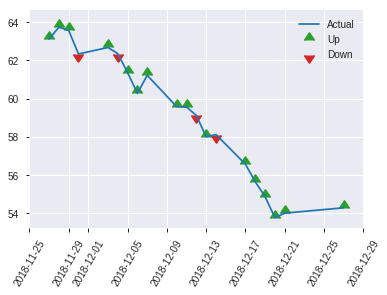


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2047992107976213
RMSE: 0.4525474680048727
LogLoss: 0.5967171980199825
Null degrees of freedom: 248
Residual degrees of freedom: -795
Null deviance: 345.5632631583502
Residual deviance: 297.1651646139513
AIC: 2385.165164613951
AUC: 0.7529032258064516
pr_auc: 0.7222158100920258
Gini: 0.5058064516129033
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43476963963049986: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   63   0.504    (63.0/125.0)
1      8    116  0.0645   (8.0/124.0)
Total  70   179  0.2851   (71.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.43477      0.765677  178
max f2                       0.415016     0.863836  186
max f0point5                 0.43477      0.690476  178
max accuracy                 0.43477      0.714859  178
max precision                0.893599     1         0
max recall                   0.190298     1         241
max specificity              0.893599     1         0
max absolute_mcc             0.43477      0.479905  178
max min_per_class_accuracy   0.58155      0.66129   122
max mean_per_class_accuracy  0.43477      0.715742  178

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 54.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.877231           2.00806   2.00806            1                0.891903  1                           0.891903            0.0241935       0.0241935                  100.806   100.806
    2        0.0200803                   0.854078           1.00403   1.60645            0.5              0.862798  0.8                         0.880261            0.00806452      0.0322581                  0.403226  60.6452
    3        0.0321285                   0.81809            2.00806   1.75706            1                0.833618  0.875                       0.86277             0.0241935       0.0564516                  100.806   75.7056
    4        0.0401606                   0.796811           1.00403   1.60645            0.5              0.807397  0.8                         0.851695            0.00806452      0.0645161                  0.403226  60.6452
    5        0.0522088                   0.783131           2.00806   1.69913            1                0.791997  0.846154                    0.837919            0.0241935       0.0887097                  100.806   69.9132
    6        0.100402                    0.75338            2.00806   1.84742            1                0.766808  0.92                        0.803786            0.0967742       0.185484                   100.806   84.7419
    7        0.15261                     0.729433           1.23573   1.63816            0.615385         0.74134   0.815789                    0.782423            0.0645161       0.25                       23.5732   63.8158
    8        0.200803                    0.704123           1.17137   1.52613            0.583333         0.717151  0.76                        0.766757            0.0564516       0.306452                   17.1371   52.6129
    9        0.301205                    0.656609           1.36548   1.47258            0.68             0.67864   0.733333                    0.737385            0.137097        0.443548                   36.5484   47.2581
    10       0.401606                    0.61355            1.04419   1.36548            0.52             0.632986  0.68                        0.711285            0.104839        0.548387                   4.41935   36.5484
    11       0.502008                    0.578189           1.12452   1.31729            0.56             0.596684  0.656                       0.688365            0.112903        0.66129                    12.4516   31.729
    12       0.598394                    0.51373            1.25504   1.30726            0.625            0.548479  0.651007                    0.665833            0.120968        0.782258                   25.504    30.7263
    13       0.698795                    0.451267           1.20484   1.29255            0.6              0.486055  0.643678                    0.640003            0.120968        0.903226                   20.4839   29.2547
    14       0.799197                    0.38514            0.562258  1.2008             0.28             0.416256  0.59799                     0.611894            0.0564516       0.959677                   -43.7742  20.0802
    15       0.899598                    0.293806           0.160645  1.08471            0.08             0.340168  0.540179                    0.581567            0.016129        0.975806                   -83.9355  8.47134
    16       1                           0.11531            0.240968  1                  0.12             0.226584  0.497992                    0.545927          

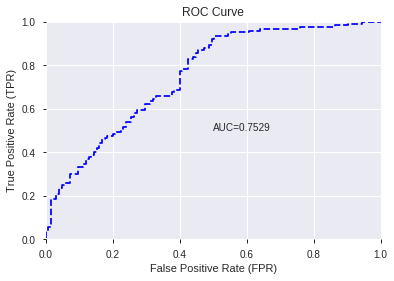

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


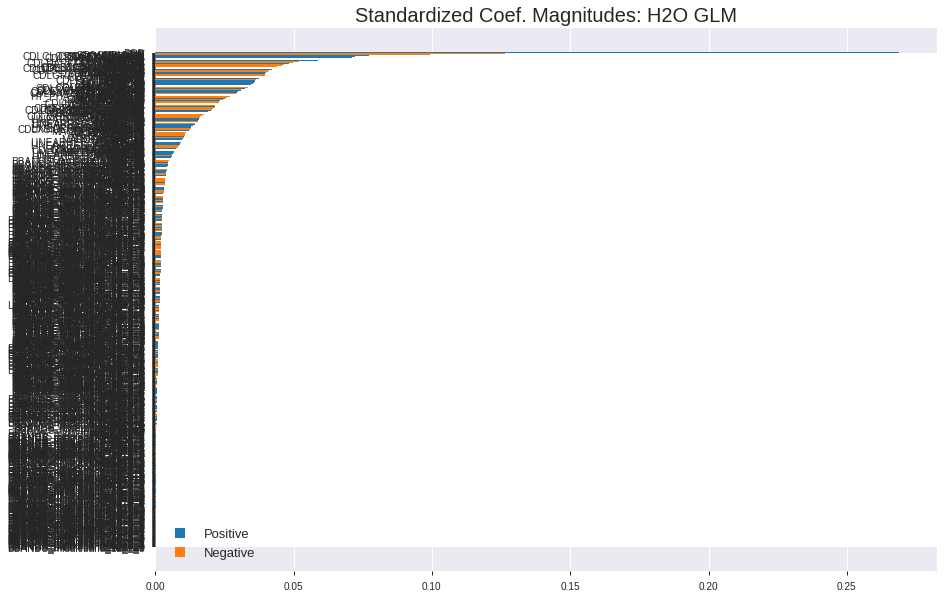

'log_likelihood'
--2019-08-28 15:27:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.227.112
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.227.112|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_152625_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_152625_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_9b1a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

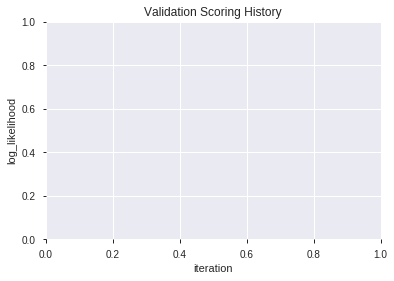

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190828_152743  0.765677  0.591845              0.276548  0.449543  0.202089
1  XGBoost_grid_1_AutoML_20190828_152743_model_3  0.764516  0.589216              0.288419  0.448735  0.201363
2  XGBoost_grid_1_AutoML_20190828_152743_model_2  0.759677  0.598252              0.276581  0.452509  0.204765
3               XGBoost_3_AutoML_20190828_152743  0.757613  0.594277              0.280710  0.451292  0.203665
4  XGBoost_grid_1_AutoML_20190828_152743_model_7  0.752903  0.591698              0.304484  0.449864  0.202378
5               XGBoost_2_AutoML_20190828_152743  0.752581  0.593254              0.264806  0.450796  0.203217
6  XGBoost_grid_1_AutoML_20190828_152743_model_4  0.747161  0.598447              0.296516  0.453217  0.205406
7  XGBoost_grid_1_AutoML_20190828_152743_model_1  0.746774  0.601550              0.272903  0.454750  0.206798
8  XGBoost_grid_1_AutoML_20190828_152743_model_6  0.740258  0.602599              0.344129  0.455472  0.207455
9  XGBoost_grid_1_AutoML_20190828_152743_model_5  0.734194  0.610177              0.304548  0.458601  0.210315

variable  relative_importance  scaled_importance  percentage
0                        BOP          1241.409546           1.000000    0.118180
1                        DIV           376.892487           0.303600    0.035879
2               STOCHF_fastk           334.421173           0.269388    0.031836
3                        SUB           217.648285           0.175324    0.020720
4             STOCHRSI_fastk           198.271988           0.159715    0.018875
..                       ...                  ...                ...         ...
326                   ATR_20             0.676713           0.000545    0.000064
327  BBANDS_upperband_20_6_2             0.619888           0.000499    0.000059
328  BBANDS_upperband_12_1_5             0.355996           0.000287    0.000034
329  BBANDS_upperband_12_4_5             0.316843           0.000255    0.000030
330               MACDFIX_12             0.143559           0.000116    0.000014

[331 rows x 4 columns]

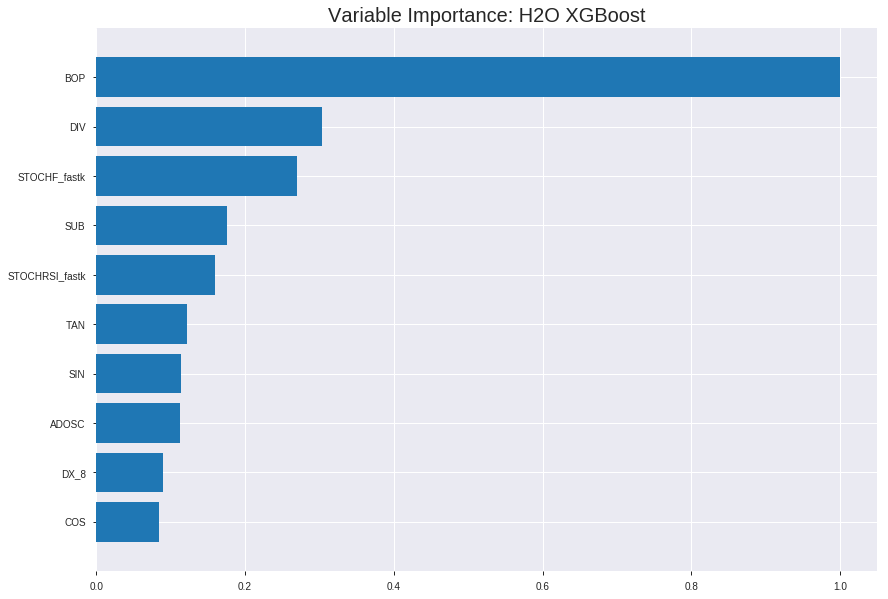

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190828_152743


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11192176218563817
RMSE: 0.3345471001004764
LogLoss: 0.3898442458674381
Mean Per-Class Error: 0.08653612388351561
AUC: 0.9742244067438297
pr_auc: 0.976178977217166
Gini: 0.9484488134876594
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5284012407064438: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      770  70   0.0833   (70.0/840.0)
1      81   820  0.0899   (81.0/901.0)
Total  851  890  0.0867   (151.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.528401     0.91569   195
max f2                       0.434542     0.938372  241
max f0point5                 0.594746     0.940771  162
max accuracy                 0.530702     0.913268  194
max precision                0.905341     1         0
max recall                   0.251556     1         334
max specificity              0.905341     1         0
max absolute_mcc             0.530702     0.826551  194
max min_per_class_accuracy   0.525754     0.91121   196
max mean_per_class_accuracy  0.530702     0.913464  194

Gains/Lift Table: Avg response rate: 51.75 %, avg score: 51.88 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.87331            1.9323     1.9323             1                0.888586  1                           0.888586            0.0199778       0.0199778                  93.2297   93.2297
    2        0.0201034                   0.85777            1.9323     1.9323             1                0.864485  1                           0.87688             0.0188679       0.0388457                  93.2297   93.2297
    3        0.0304423                   0.846288           1.9323     1.9323             1                0.852042  1                           0.868444            0.0199778       0.0588235                  93.2297   93.2297
    4        0.0402068                   0.839058           1.9323     1.9323             1                0.842687  1                           0.862189            0.0188679       0.0776915                  93.2297   93.2297
    5        0.0505457                   0.83539            1.9323     1.9323             1                0.83726   1                           0.85709             0.0199778       0.0976693                  93.2297   93.2297
    6        0.100517                    0.807199           1.9323     1.9323             1                0.819817  1                           0.83856             0.0965594       0.194229                   93.2297   93.2297
    7        0.150488                    0.7835             1.9323     1.9323             1                0.796235  1                           0.824505            0.0965594       0.290788                   93.2297   93.2297
    8        0.20046                     0.756071           1.9323     1.9323             1                0.770345  1                           0.811004            0.0965594       0.387347                   93.2297   93.2297
    9        0.300402                    0.700699           1.9323     1.9323             1                0.729804  1                           0.783989            0.193119        0.580466                   93.2297   93.2297
    10       0.400345                    0.627              1.83235    1.90735            0.948276         0.666371  0.987088                    0.754627            0.18313         0.763596                   83.2351   90.7347
    11       0.500287                    0.53679            1.33262    1.79253            0.689655         0.580562  0.927669                    0.719854            0.133185        0.896781                   33.2619   79.2533
    12       0.60023                     0.437623           0.699625   1.61056            0.362069         0.486797  0.833493                    0.681048            0.0699223       0.966704                   -30.0375  61.0556
    13       0.700172                    0.358411           0.199893   1.4092             0.103448         0.3948    0.729286                    0.640189            0.0199778       0.986681                   -80.0107  40.9198
    14       0.800115                    0.277174           0.122157   1.24843            0.0632184        0.313867  0.646088                    0.599428            0.0122087       0.99889                    -87.7843  24.8433
    15       0.900057                    0.196583           0.0111052  1.11104            0.00574713       0.237529  0.574984                    0.559243            0.00110988      1                          -98.8895  11.104
    16       1                           0.0867841          0          1                  0                0.154189  0.517519                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.21437521127376694
RMSE: 0.46300670759046997
LogLoss: 0.6182300841130812
Mean Per-Class Error: 0.3220779220779221
AUC: 0.7209002177946277
pr_auc: 0.6999785554374706
Gini: 0.4418004355892553
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4410024434328079: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      114  131  0.5347   (131.0/245.0)
1      37   216  0.1462   (37.0/253.0)
Total  151  347  0.3373   (168.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.441002     0.72      267
max f2                       0.269502     0.847458  364
max f0point5                 0.508474     0.67997   213
max accuracy                 0.508474     0.678715  213
max precision                0.839959     1         0
max recall                   0.141156     1         394
max specificity              0.839959     1         0
max absolute_mcc             0.484284     0.36434   239
max min_per_class_accuracy   0.536434     0.660079  195
max mean_per_class_accuracy  0.508474     0.677922  213

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 52.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.802794           1.5747    1.5747             0.8              0.825759  0.8                         0.825759            0.0158103       0.0158103                  57.4704   57.4704
    2        0.0200803                   0.784065           1.5747    1.5747             0.8              0.797127  0.8                         0.811443            0.0158103       0.0316206                  57.4704   57.4704
    3        0.0301205                   0.776616           1.96838   1.70593            1                0.781342  0.866667                    0.801409            0.0197628       0.0513834                  96.8379   70.5929
    4        0.0401606                   0.768521           1.96838   1.77154            1                0.774171  0.9                         0.7946              0.0197628       0.0711462                  96.8379   77.1542
    5        0.0502008                   0.76307            1.18103   1.65344            0.6              0.765679  0.84                        0.788816            0.0118577       0.083004                   18.1028   65.3439
    6        0.100402                    0.724752           1.49597   1.5747             0.76             0.742695  0.8                         0.765756            0.0750988       0.158103                   49.5968   57.4704
    7        0.150602                    0.693359           1.5747    1.5747             0.8              0.709636  0.8                         0.747049            0.0790514       0.237154                   57.4704   57.4704
    8        0.200803                    0.67209            1.18103   1.47628            0.6              0.684343  0.75                        0.731373            0.0592885       0.296443                   18.1028   47.6285
    9        0.301205                    0.618794           1.25976   1.40411            0.64             0.644235  0.713333                    0.702327            0.126482        0.422925                   25.9763   40.4111
    10       0.399598                    0.574279           1.2453    1.36501            0.632653         0.596461  0.693467                    0.676259            0.12253         0.545455                   24.5301   36.5007
    11       0.5                         0.536761           1.10229   1.31225            0.56             0.556559  0.666667                    0.652223            0.110672        0.656126                   10.2292   31.2253
    12       0.600402                    0.493638           1.06292   1.27056            0.54             0.511793  0.645485                    0.62874             0.106719        0.762846                   6.29249   27.0559
    13       0.698795                    0.439726           0.923933  1.22175            0.469388         0.470571  0.62069                     0.606469            0.0909091       0.853755                   -7.60668  22.1753
    14       0.799197                    0.362469           0.590514  1.14245            0.3              0.399752  0.580402                    0.580499            0.0592885       0.913043                   -40.9486  14.2451
    15       0.899598                    0.296763           0.433043  1.06328            0.22             0.332976  0.540179                    0.552874            0.0434783       0.956522                   -56.6957  6.32764
    16       1                           0.105639           0.433043  1                  0.22             0.225501  0.508032                    0.520005         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:27:44  0.010 sec   0                  0.5              0.693147            0.5             0                  1                0.482481                         0.5                0.693147              0.5               0                    1                  0.491968
    2019-08-28 15:27:45  1.503 sec   5                  0.474558         0.643339            0.868448        0.867366           1.9323           0.217691                         0.491904           0.677025              0.65173           0.649439             1.5747             0.453815
    2019-08-28 15:27:45  1.838 sec   10                 0.452143         0.600708            0.886669        0.897737           1.9323           0.205055                         0.483235           0.659782              0.684028          0.676965             1.5747             0.339357
    2019-08-28 15:27:46  2.163 sec   15                 0.434346         0.567451            0.904112        0.912904           1.9323           0.188397                         0.476989           0.647261              0.69904           0.689948             1.96838            0.409639
    2019-08-28 15:27:46  2.507 sec   20                 0.418697         0.53835             0.913787        0.922543           1.9323           0.179207                         0.472656           0.638439              0.704703          0.693759             1.96838            0.36747
    2019-08-28 15:27:46  2.865 sec   25                 0.40404          0.511517            0.927386        0.936353           1.9323           0.151637                         0.470023           0.632918              0.70868           0.698435             1.96838            0.369478
    2019-08-28 15:27:47  3.204 sec   30                 0.391514         0.488691            0.93653         0.945032           1.9323           0.148765                         0.46916            0.631056              0.709422          0.693884             1.96838            0.36747
    2019-08-28 15:27:47  3.545 sec   35                 0.380283         0.468375            0.944523        0.952834           1.9323           0.133831                         0.466763           0.626209              0.714278          0.69457              1.96838            0.351406
    2019-08-28 15:27:47  3.860 sec   40                 0.370156         0.450447            0.951977        0.959309           1.9323           0.123492                         0.465753           0.623923              0.717512          0.698412             1.96838            0.365462
    2019-08-28 15:27:48  4.172 sec   45                 0.361605         0.435591            0.957958        0.964425           1.9323           0.114877                         0.465137           0.622614              0.717722          0.699874             1.96838            0.341365
    2019-08-28 15:27:48  4.517 sec   50                 0.352021         0.419032            0.963519        0.968891           1.9323           0.10741                          0.463052           0.618609              0.722973          0.702281             1.96838            0.333333
    2019-08-28 15:27:48  4.827 sec   55                 0.34306          0.403989            0.969349        0.973676           1.9323           0.0970706                        0.462989           0.618394              0.72261           0.6

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      1241.4095458984375     1.0                     0.11817964107946193
DIV                      376.8924865722656      0.30360044178611467     0.03587939124184911
STOCHF_fastk             334.4211730957031      0.2693882725492292      0.031836209360884174
SUB                      217.64828491210938     0.17532351481524347     0.020719670053655197
STOCHRSI_fastk           198.27198791503906     0.159715211285527       0.018875086344654006
---                      ---                    ---                     ---
ATR_20                   0.6767134666442871     0.0005451170154765754   6.442173323532918e-05
BBANDS_upperband_20_6_2  0.6198883056640625     0.0004993423062615767   5.901209452978389e-05
BBANDS_upperband_12_1_5  0.35599613189697266    0.0002867676771724273   3.389010116142846e-05
BBANDS_upperband_12_4_5  0.31684303283691406    0.00025522844889001335  3.0162806483089573e-05
MACDFIX_12               0.14355850219726562    0.00011564153237871949  1.3666474790396044e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7349397590361446)

('F1', 0.7561837455830388)

('auc', 0.7656774193548387)

('logloss', 0.5918445375715143)

('mean_per_class_error', 0.2648387096774194)

('rmse', 0.4495434405927508)

('mse', 0.20208930497996808)

xgboost prediction progress: |████████████████████████████████████████████| 100%


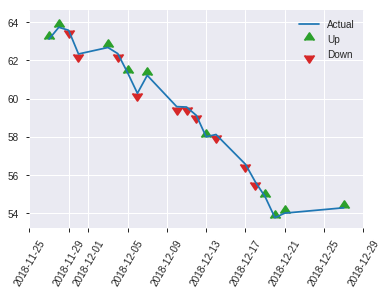


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20208930497996808
RMSE: 0.4495434405927508
LogLoss: 0.5918445375715143
Mean Per-Class Error: 0.2648387096774194
AUC: 0.7656774193548387
pr_auc: 0.719739974403754
Gini: 0.5313548387096774
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46930715441703796: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      73   52   0.416    (52.0/125.0)
1      17   107  0.1371   (17.0/124.0)
Total  90   159  0.2771   (69.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.469307     0.756184  158
max f2                       0.402374     0.847953  187
max f0point5                 0.527663     0.728528  131
max accuracy                 0.527663     0.73494   131
max precision                0.860213     1         0
max recall                   0.161864     1         242
max specificity              0.860213     1         0
max absolute_mcc             0.517675     0.473108  137
max min_per_class_accuracy   0.544264     0.717742  122
max mean_per_class_accuracy  0.517675     0.735161  137

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 53.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.840898           1.33871   1.33871            0.666667         0.849909  0.666667                    0.849909            0.016129        0.016129                   33.871    33.871
    2        0.0200803                   0.832933           2.00806   1.60645            1                0.838417  0.8                         0.845312            0.016129        0.0322581                  100.806   60.6452
    3        0.0321285                   0.824672           2.00806   1.75706            1                0.829534  0.875                       0.839395            0.0241935       0.0564516                  100.806   75.7056
    4        0.0401606                   0.811682           2.00806   1.80726            1                0.822256  0.9                         0.835967            0.016129        0.0725806                  100.806   80.7258
    5        0.0522088                   0.79531            2.00806   1.8536             1                0.806568  0.923077                    0.829183            0.0241935       0.0967742                  100.806   85.3598
    6        0.100402                    0.760577           1.17137   1.52613            0.583333         0.773214  0.76                        0.802318            0.0564516       0.153226                   17.1371   52.6129
    7        0.15261                     0.726734           1.3902    1.47963            0.692308         0.743352  0.736842                    0.782146            0.0725806       0.225806                   39.0199   47.9626
    8        0.200803                    0.710272           1.50605   1.48597            0.75             0.718395  0.74                        0.766845            0.0725806       0.298387                   50.6048   48.5968
    9        0.301205                    0.645414           1.44581   1.47258            0.72             0.678722  0.733333                    0.737471            0.145161        0.443548                   44.5806   47.2581
    10       0.401606                    0.580147           1.36548   1.44581            0.68             0.608734  0.72                        0.705287            0.137097        0.580645                   36.5484   44.5806
    11       0.502008                    0.543222           1.36548   1.42974            0.68             0.561284  0.712                       0.676486            0.137097        0.717742                   36.5484   42.9742
    12       0.598394                    0.491278           1.0877    1.37465            0.541667         0.516456  0.684564                    0.650709            0.104839        0.822581                   8.77016   37.4648
    13       0.698795                    0.432577           0.562258  1.25793            0.28             0.463933  0.626437                    0.623874            0.0564516       0.879032                   -43.7742  25.7925
    14       0.799197                    0.376162           0.562258  1.17053            0.28             0.405108  0.582915                    0.596391            0.0564516       0.935484                   -43.7742  17.053
    15       0.899598                    0.278704           0.401613  1.08471            0.2              0.342146  0.540179                    0.568015            0.0403226       0.975806                   -59.8387  8.47134
    16       1                           0.114598           0.240968  1                  0.12             0.21431   0.497992                    0.532503           

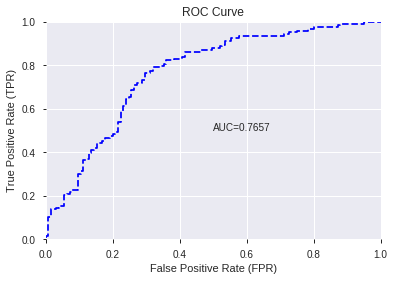

This function is available for GLM models only


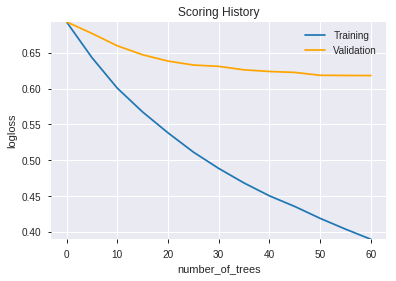

--2019-08-28 15:28:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.133.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.133.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190828_152743',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190828_152743',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_9b1a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_9b1a',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_152856_model_8  0.758774  0.590147              0.288710  0.450441  0.202897
1  DeepLearning_grid_1_AutoML_20190828_152856_model_6  0.750903  0.615841              0.316387  0.464417  0.215684
2  DeepLearning_grid_1_AutoML_20190828_152856_model_9  0.749323  0.596540              0.312258  0.453790  0.205925
3  DeepLearning_grid_1_AutoML_20190828_152856_model_5  0.745419  0.600649              0.324194  0.454184  0.206283
4  DeepLearning_grid_1_AutoML_20190828_152856_model_7  0.711806  0.732919              0.400065  0.500464  0.250464
5               DeepLearning_1_AutoML_20190828_152856  0.700581  0.802206              0.384452  0.534195  0.285364
6  DeepLearning_grid_1_AutoML_20190828_152856_model_3  0.696065  0.750561              0.388258  0.491282  0.241358
7  DeepLearning_grid_1_AutoML_20190828_152856_model_2  0.691677  0.734132              0.360419  0.492974  0.243024
8  DeepLearning_grid_1_AutoML_20190828_152856_model_1  0.652452  0.861003              0.384258  0.531538  0.282533
9  DeepLearning_grid_1_AutoML_20190828_152856_model_4  0.610129  0.836654              0.492032  0.528969  0.279808

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.035808
1                SAREXT             0.706840           0.706840    0.025310
2                   DIV             0.702829           0.702829    0.025167
3                   day             0.650860           0.650860    0.023306
4                   SIN             0.648077           0.648077    0.023206
5           STOCH_slowd             0.631910           0.631910    0.022627
6                TRANGE             0.625404           0.625404    0.022394
7          STOCHF_fastk             0.620983           0.620983    0.022236
8              CORREL_8             0.615703           0.615703    0.022047
9                   COS             0.610868           0.610868    0.021874
10                  SUB             0.606583           0.606583    0.021720
11          aroondown_8             0.605622           0.605622    0.021686
12         weekday_name             0.604320           0.604320    0.021639
13   CDLCLOSINGMARUBOZU             0.598877           0.598877    0.021445
14         HT_TRENDMODE             0.595495           0.595495    0.021323
15         aroondown_14             0.592789           0.592789    0.021227
16         CDLSHORTLINE             0.590077           0.590077    0.021129
17       CDLSPINNINGTOP             0.588342           0.588342    0.021067
18              weekday             0.588103           0.588103    0.021059
19            dayofweek             0.585855           0.585855    0.020978
20          CDLLONGLINE             0.580993           0.580993    0.020804
21            aroonup_8             0.577151           0.577151    0.020667
22                 DX_8             0.577001           0.577001    0.020661
23       STOCHRSI_fastk             0.575889           0.575889    0.020621
24           aroonup_30             0.574851           0.574851    0.020584
25              quarter             0.562916           0.562916    0.020157
26                 TANH             0.558682           0.558682    0.020005
27               ULTOSC             0.547970           0.547970    0.019622
28              BETA_12             0.541022           0.541022    0.019373
29         CDLENGULFING             0.532043           0.532043    0.019051
30                 week             0.530765           0.530765    0.019006
31                  OBV             0.522750           0.522750    0.018719
32            CDLHAMMER             0.513416           0.513416    0.018384
33          CDLBELTHOLD             0.513252           0.513252    0.018378
34                  EXP             0.511749           0.511749    0.018325
35                ADOSC             0.503319           0.503319    0.018023
36     CDLSTICKSANDWICH             0.503117           0.503117    0.018016
37                 SINH             0.501352           0.501352    0.017952
38  CDLGAPSIDESIDEWHITE             0.486427           0.486427    0.017418
39    CDL3WHITESOLDIERS             0.480693           0.480693    0.017213
40   CDLUPSIDEGAP2CROWS             0.467820           0.467820    0.016752
41       CDLMORNINGSTAR             0.465004           0.465004    0.016651
42      CDLLADDERBOTTOM             0.464946           0.464946    0.016649
43            CDLONNECK             0.460458           0.460458    0.016488
44            CDL2CROWS             0.454530           0.454530    0.016276
45          CDLPIERCING             0.447389           0.447389    0.016020
46            CDLINNECK             0.438116           0.438116    0.015688
47   CDLEVENINGDOJISTAR             0.428106           0.428106    0.015330
48     is_quarter_start             0.422911           0.422911    0.015144
49    CDLDARKCLOUDCOVER             0.412616           0.412616    0.014775

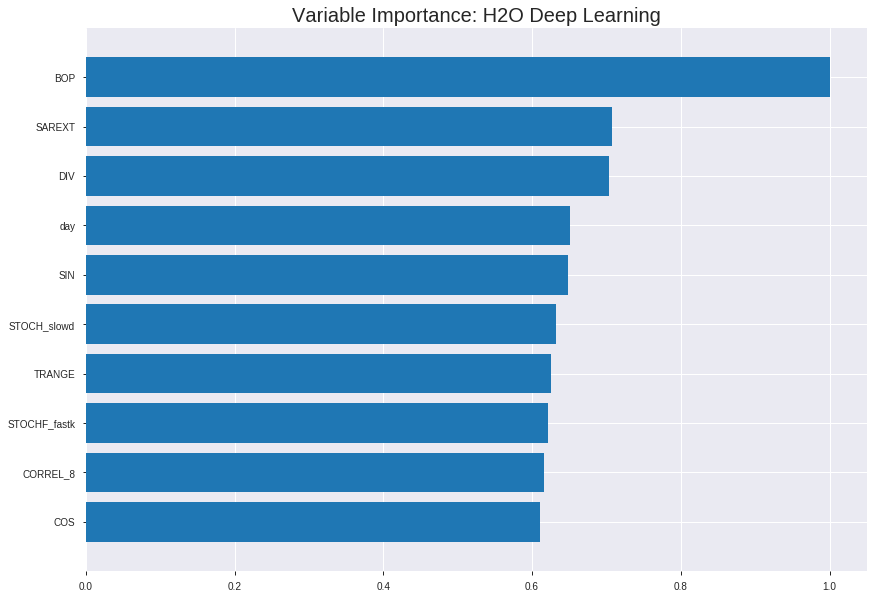

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_152856_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20669394516369669
RMSE: 0.45463605792292444
LogLoss: 0.5986006639661565
Mean Per-Class Error: 0.30710652185402465
AUC: 0.7468467575709529
pr_auc: 0.7385477209238923
Gini: 0.49369351514190574
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40690302053084226: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      326  514   0.6119   (514.0/840.0)
1      85   816   0.0943   (85.0/901.0)
Total  411  1330  0.3441   (599.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.406903     0.731511  248
max f2                       0.159287     0.855605  348
max f0point5                 0.501674     0.70229   183
max accuracy                 0.500603     0.693854  184
max precision                0.882732     1         0
max recall                   0.0555485    1         387
max specificity              0.882732     1         0
max absolute_mcc             0.500603     0.386454  184
max min_per_class_accuracy   0.507574     0.686905  178
max mean_per_class_accuracy  0.500603     0.692893  184

Gains/Lift Table: Avg response rate: 51.75 %, avg score: 48.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.781405           1.9323    1.9323             1                0.807463  1                           0.807463            0.0199778       0.0199778                  93.2297   93.2297
    2        0.0201034                   0.75909            1.36397   1.65625            0.705882         0.769395  0.857143                    0.788973            0.0133185       0.0332963                  36.3975   65.6255
    3        0.0304423                   0.747644           1.5029    1.60417            0.777778         0.752032  0.830189                    0.776427            0.0155383       0.0488346                  50.2898   60.4171
    4        0.0402068                   0.737503           1.81863   1.65625            0.941176         0.742496  0.857143                    0.768187            0.017758        0.0665927                  81.8633   65.6255
    5        0.0505457                   0.728387           1.5029    1.62489            0.777778         0.732729  0.840909                    0.760934            0.0155383       0.082131                   50.2898   62.4886
    6        0.100517                    0.68832            1.64356   1.63417            0.850575         0.706407  0.845714                    0.733826            0.082131        0.164262                   64.3563   63.4172
    7        0.150488                    0.658242           1.44367   1.57091            0.747126         0.673288  0.812977                    0.713724            0.0721421       0.236404                   44.3671   57.0914
    8        0.20046                     0.631727           1.48809   1.55027            0.770115         0.644036  0.802292                    0.696352            0.0743618       0.310766                   48.8091   55.0267
    9        0.300402                    0.579226           1.26599   1.45569            0.655172         0.603124  0.753346                    0.665335            0.126526        0.437292                   26.5988   45.5689
    10       0.400345                    0.541232           1.23267   1.40001            0.637931         0.558163  0.724534                    0.638581            0.123196        0.560488                   23.2673   40.0015
    11       0.500287                    0.508419           1.22157   1.36437            0.632184         0.524837  0.706085                    0.615858            0.122087        0.682575                   22.1567   36.4366
    12       0.60023                     0.487362           0.910623  1.28881            0.471264         0.496965  0.666986                    0.596061            0.09101         0.773585                   -8.93771  28.8815
    13       0.700172                    0.454212           0.810677  1.22057            0.41954          0.475514  0.631665                    0.578854            0.0810211       0.854606                   -18.9323  22.0565
    14       0.800115                    0.350748           0.755151  1.16243            0.390805         0.414333  0.601579                    0.558304            0.0754717       0.930078                   -24.4849  16.243
    15       0.900057                    0.192507           0.510837  1.09008            0.264368         0.271409  0.564135                    0.526447            0.0510544       0.981132                   -48.9163  9.00772
    16       1                           0.0106865          0.188788  1                  0.0977011        0.109749  0.517519                    0.484801          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.215990508363098
RMSE: 0.4647477900572503
LogLoss: 0.6228145039149968
Mean Per-Class Error: 0.33305638460917963
AUC: 0.7158102766798419
pr_auc: 0.6913823411240091
Gini: 0.43162055335968375
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4003077086058534: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      76   169  0.6898   (169.0/245.0)
1      12   241  0.0474   (12.0/253.0)
Total  88   410  0.3635   (181.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.400308     0.726998  315
max f2                       0.361393     0.847872  326
max f0point5                 0.505103     0.667984  199
max accuracy                 0.489945     0.668675  235
max precision                0.844138     1         0
max recall                   0.0483498    1         393
max specificity              0.844138     1         0
max absolute_mcc             0.400308     0.344422  315
max min_per_class_accuracy   0.505342     0.657143  198
max mean_per_class_accuracy  0.489945     0.666944  235

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 49.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.728057           1.5747    1.5747             0.8              0.771246  0.8                         0.771246            0.0158103       0.0158103                  57.4704   57.4704
    2        0.0200803                   0.717824           1.5747    1.5747             0.8              0.726275  0.8                         0.748761            0.0158103       0.0316206                  57.4704   57.4704
    3        0.0301205                   0.713657           1.5747    1.5747             0.8              0.716121  0.8                         0.737881            0.0158103       0.0474308                  57.4704   57.4704
    4        0.0401606                   0.70554            1.96838   1.67312            1                0.710273  0.85                        0.730979            0.0197628       0.0671937                  96.8379   67.3123
    5        0.0502008                   0.699504           1.18103   1.5747             0.6              0.703584  0.8                         0.7255              0.0118577       0.0790514                  18.1028   57.4704
    6        0.100402                    0.669175           1.49597   1.53534            0.76             0.687239  0.78                        0.70637             0.0750988       0.15415                    49.5968   53.5336
    7        0.150602                    0.651835           1.41723   1.49597            0.72             0.660281  0.76                        0.691007            0.0711462       0.225296                   41.7233   49.5968
    8        0.200803                    0.620867           1.3385    1.4566             0.68             0.634242  0.74                        0.676816            0.0671937       0.29249                    33.8498   45.6601
    9        0.301205                    0.576209           1.2204    1.37787            0.62             0.595945  0.7                         0.649859            0.12253         0.41502                    22.0395   37.7866
    10       0.399598                    0.534839           1.12479   1.31555            0.571429         0.556062  0.668342                    0.626763            0.110672        0.525692                   12.4788   31.555
    11       0.5                         0.505759           1.29913   1.31225            0.66             0.520596  0.666667                    0.605444            0.130435        0.656126                   29.913    31.2253
    12       0.600402                    0.490309           1.02356   1.26398            0.52             0.497241  0.64214                     0.58735             0.102767        0.758893                   2.35573   26.3976
    13       0.698795                    0.472246           0.923933  1.2161             0.469388         0.483526  0.617816                    0.572731            0.0909091       0.849802                   -7.60668  21.6096
    14       0.799197                    0.413289           0.826719  1.16718            0.42             0.446968  0.592965                    0.556932            0.083004        0.932806                   -17.3281  16.718
    15       0.899598                    0.252611           0.393676  1.08085            0.2              0.347251  0.549107                    0.53353             0.0395257       0.972332                   -60.6324  8.08512
    16       1                           0.00287893         0.275573  1                  0.14             0.150328  0.508032                    0.495056           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:33:36  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 15:33:38  53.306 sec        722 obs/sec       0.58185   1             1013       0.614859         1.17879             -0.514065      0.70405         0.690635           1.61025          0.386559                         0.612871           1.17346               -0.502829        0.674276          0.656273             1.5747             0.393574
    2019-08-28 15:33:46  1 min  1.698 sec  1164 obs/sec      5.99598   10            10439      0.465087         0.6246              0.133711       0.732232        0.719116           1.7176           0.351522                         0.470099           0.631598              0.115799         0.714326          0.705436             1.96838            0.371486
    2019-08-28 15:33:55  1 min 10.258 sec  1263 obs/sec      12.0994   20            21065      0.454636         0.598601            0.172208       0.746847        0.738548           1.9323           0.344055                         0.464748           0.622815              0.135815         0.71581           0.691382             1.5747             0.363454
    2019-08-28 15:34:04  1 min 19.227 sec  1360 obs/sec      19.3894   32            33757      0.451929         0.591561            0.182038       0.762005        0.761155           1.9323           0.324526                         0.469234           0.632992              0.119051         0.710188          0.679405             1.5747             0.353414
    2019-08-28 15:34:12  1 min 27.652 sec  1432 obs/sec      26.6617   44            46418      0.436982         0.559003            0.235249       0.790515        0.801494           1.9323           0.313613                         0.476084           0.648973              0.0931402        0.690764          0.640586             1.18103            0.389558
    2019-08-28 15:34:21  1 min 36.563 sec  1482 obs/sec      34.4733   57            60018      0.417197         0.509788            0.30293        0.816981        0.822394           1.9323           0.290063                         0.477453           0.663034              0.0879188        0.684609          0.647691             1.5747             0.363454
    2019-08-28 15:34:30  1 min 45.420 sec  1521 obs/sec      42.3619   70            73752      0.400223         0.472719            0.358497       0.843213        0.842817           1.9323           0.247559                         0.484424           0.702303              0.0610908        0.668863          0.628043             1.18103            0.373494
    2019-08-28 15:34:31  1 min 46.300 sec  1520 obs/sec      42.3619   70            73752      0.454636         0.598601            0.172208       0.746847        0.738548           1.9323           0.344055                         0.464748           0.622815              0.135815         0.71581           0.691382             1.5747             0.363454

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.03580790839693008
SAREXT              0.7068403959274292     0.7068403959274292   0.02531047614861917
DIV                 0.7028287649154663     0.7028287649154663   0.02516682803282052
day                 0.6508604884147644     0.6508604884147644   0.023305952748337053
SIN                 0.6480768322944641     0.6480768322944641   0.023206275844972788
---                 ---                    ---                  ---
CDLPIERCING         0.44738876819610596    0.44738876819610596  0.016020056029381547
CDLINNECK           0.4381164312362671     0.4381164312362671   0.015688033036898166
CDLEVENINGDOJISTAR  0.4281059801578522     0.4281059801578522   0.015329579721670336
is_quarter_start    0.4229109585285187     0.4229109585285187   0.015143556863047091
CDLDARKCLOUDCOVER   0.4126163423061371     0.4126163423061371   0.014774928188374501


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7108433734939759)

('F1', 0.7391304347826086)

('auc', 0.758774193548387)

('logloss', 0.5901465292107282)

('mean_per_class_error', 0.2887096774193548)

('rmse', 0.4504413420720161)

('mse', 0.202897402647639)

deeplearning prediction progress: |███████████████████████████████████████| 100%


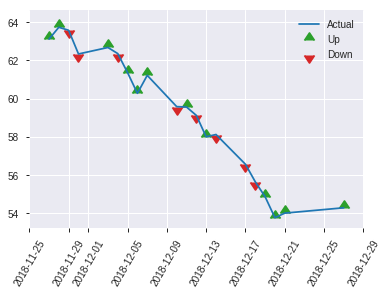


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.202897402647639
RMSE: 0.4504413420720161
LogLoss: 0.5901465292107282
Mean Per-Class Error: 0.2887096774193548
AUC: 0.758774193548387
pr_auc: 0.7267429038081445
Gini: 0.5175483870967741
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4552624269308753: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      75   50   0.4      (50.0/125.0)
1      22   102  0.1774   (22.0/124.0)
Total  97   152  0.2892   (72.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.455262     0.73913   151
max f2                       0.300913     0.860597  206
max f0point5                 0.455262     0.696721  151
max accuracy                 0.455262     0.710843  151
max precision                0.84746      1         0
max recall                   0.0960282    1         237
max specificity              0.84746      1         0
max absolute_mcc             0.455262     0.433279  151
max min_per_class_accuracy   0.492775     0.672     124
max mean_per_class_accuracy  0.455262     0.71129   151

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 46.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.781804           1.33871   1.33871            0.666667         0.818224  0.666667                    0.818224            0.016129        0.016129                   33.871    33.871
    2        0.0200803                   0.765517           2.00806   1.60645            1                0.773117  0.8                         0.800181            0.016129        0.0322581                  100.806   60.6452
    3        0.0321285                   0.722311           2.00806   1.75706            1                0.74665   0.875                       0.780107            0.0241935       0.0564516                  100.806   75.7056
    4        0.0401606                   0.706911           2.00806   1.80726            1                0.712652  0.9                         0.766616            0.016129        0.0725806                  100.806   80.7258
    5        0.0522088                   0.699484           2.00806   1.8536             1                0.703466  0.923077                    0.752043            0.0241935       0.0967742                  100.806   85.3598
    6        0.100402                    0.667746           1.50605   1.68677            0.75             0.684499  0.84                        0.719622            0.0725806       0.169355                   50.6048   68.6774
    7        0.15261                     0.629064           1.23573   1.53247            0.615385         0.650965  0.763158                    0.696134            0.0645161       0.233871                   23.5732   53.247
    8        0.200803                    0.595746           1.67339   1.56629            0.833333         0.615232  0.78                        0.676718            0.0806452       0.314516                   67.3387   56.629
    9        0.301205                    0.554979           1.44581   1.52613            0.72             0.577245  0.76                        0.64356             0.145161        0.459677                   44.5806   52.6129
    10       0.401606                    0.518698           1.12452   1.42573            0.56             0.532971  0.71                        0.615913            0.112903        0.572581                   12.4516   42.5726
    11       0.502008                    0.492775           1.04419   1.34942            0.52             0.504669  0.672                       0.593664            0.104839        0.677419                   4.41935   34.9419
    12       0.598394                    0.465044           1.25504   1.33422            0.625            0.48099   0.66443                     0.575515            0.120968        0.798387                   25.504    33.4217
    13       0.698795                    0.418159           0.883548  1.26947            0.44             0.440605  0.632184                    0.556131            0.0887097       0.887097                   -11.6452  26.9466
    14       0.799197                    0.346254           0.642581  1.19071            0.32             0.381491  0.592965                    0.534192            0.0645161       0.951613                   -35.7419  19.0712
    15       0.899598                    0.222303           0.32129   1.09368            0.16             0.279367  0.544643                    0.505751            0.0322581       0.983871                   -67.871   9.3678
    16       1                           0.032815           0.160645  1                  0.08             0.125182  0.497992                    0.467542            0

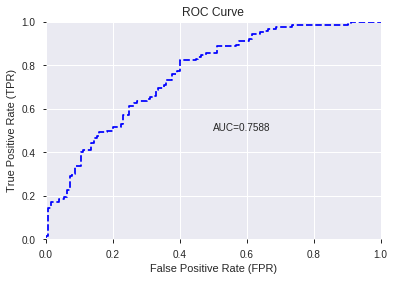

This function is available for GLM models only


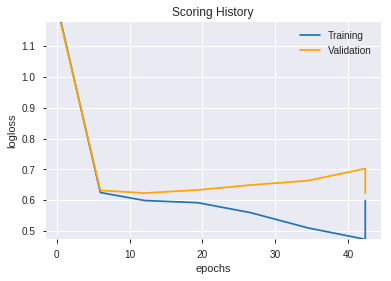

--2019-08-28 15:35:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.176.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.176.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_152856_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_152856_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_9b1a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'SAREXT',
 'DIV',
 'day',
 'SIN',
 'STOCH_slowd',
 'TRANGE',
 'STOCHF_fastk',
 'CORREL_8',
 'COS',
 'SUB',
 'aroondown_8',
 'weekday_name',
 'CDLCLOSINGMARUBOZU',
 'HT_TRENDMODE',
 'aroondown_14',
 'CDLSHORTLINE',
 'CDLSPINNINGTOP',
 'weekday',
 'dayofweek',
 'CDLLONGLINE',
 'aroonup_8',
 'DX_8',
 'STOCHRSI_fastk',
 'aroonup_30',
 'quarter',
 'TANH',
 'ULTOSC',
 'BETA_12',
 'CDLENGULFING',
 'week',
 'OBV',
 'CDLHAMMER',
 'CDLBELTHOLD',
 'EXP',
 'ADOSC',
 'CDLSTICKSANDWICH',
 'SINH',
 'CDLGAPSIDESIDEWHITE',
 'CDL3WHITESOLDIERS',
 'CDLUPSIDEGAP2CROWS',
 'CDLMORNINGSTAR',
 'CDLLADDERBOTTOM',
 'CDLONNECK',
 'CDL2CROWS',
 'CDLPIERCING',
 'CDLINNECK',
 'CDLEVENINGDOJISTAR',
 'is_quarter_start',
 'CDLDARKCLOUDCOVER']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_153540_model_1  0.769806  0.577612              0.308323  0.444086  0.197213

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.446075           1.000000    0.143873
1          STOCHF_fastk             0.151796           0.340292    0.048959
2                   DIV             0.142945           0.320450    0.046104
3                   SUB             0.133386           0.299021    0.043021
4                ULTOSC             0.123420           0.276680    0.039807
5           STOCH_slowd             0.123058           0.275868    0.039690
6             CDLHAMMER             0.101292           0.227074    0.032670
7                SAREXT             0.099062           0.222075    0.031951
8    CDLCLOSINGMARUBOZU             0.097482           0.218534    0.031441
9                  TANH             0.097426           0.218407    0.031423
10           aroonup_30             0.093840           0.210369    0.030266
11         CDLENGULFING             0.092988           0.208458    0.029991
12       STOCHRSI_fastk             0.075562           0.169392    0.024371
13            CDL2CROWS             0.071640           0.160600    0.023106
14      CDLLADDERBOTTOM             0.066086           0.148150    0.021315
15            aroonup_8             0.065736           0.147366    0.021202
16                  COS             0.065693           0.147270    0.021188
17                ADOSC             0.064670           0.144975    0.020858
18     CDLSTICKSANDWICH             0.064626           0.144877    0.020844
19   CDLUPSIDEGAP2CROWS             0.062407           0.139903    0.020128
20          CDLBELTHOLD             0.062021           0.139038    0.020004
21               TRANGE             0.057858           0.129706    0.018661
22                 week             0.055157           0.123649    0.017790
23    CDLDARKCLOUDCOVER             0.053854           0.120729    0.017370
24    CDL3WHITESOLDIERS             0.051669           0.115831    0.016665
25          aroondown_8             0.051553           0.115570    0.016627
26          CDLLONGLINE             0.051407           0.115243    0.016580
27   CDLEVENINGDOJISTAR             0.043922           0.098464    0.014166
28                 DX_8             0.042747           0.095830    0.013787
29       CDLSPINNINGTOP             0.041071           0.092071    0.013247
30     is_quarter_start             0.037710           0.084537    0.012163
31                  EXP             0.035501           0.079585    0.011450
32                 SINH             0.035351           0.079248    0.011402
33         weekday_name             0.035121           0.078734    0.011328
34                  SIN             0.028996           0.065002    0.009352
35          CDLPIERCING             0.028961           0.064924    0.009341
36                  OBV             0.025158           0.056398    0.008114
37  CDLGAPSIDESIDEWHITE             0.021965           0.049240    0.007084
38              BETA_12             0.019407           0.043506    0.006259
39              quarter             0.015759           0.035329    0.005083
40         HT_TRENDMODE             0.010648           0.023871    0.003434
41            CDLONNECK             0.010287           0.023061    0.003318
42         CDLSHORTLINE             0.007658           0.017167    0.002470
43             CORREL_8             0.007136           0.015998    0.002302
44            CDLINNECK             0.006876           0.015414    0.002218
45              weekday             0.006234           0.013975    0.002011
46            dayofweek             0.006211           0.013923    0.002003
47       CDLMORNINGSTAR             0.004828           0.010822    0.001557
48                  day             0.004532           0.010160    0.001462
49         aroondown_14             0.001700           0.003810    0.000548

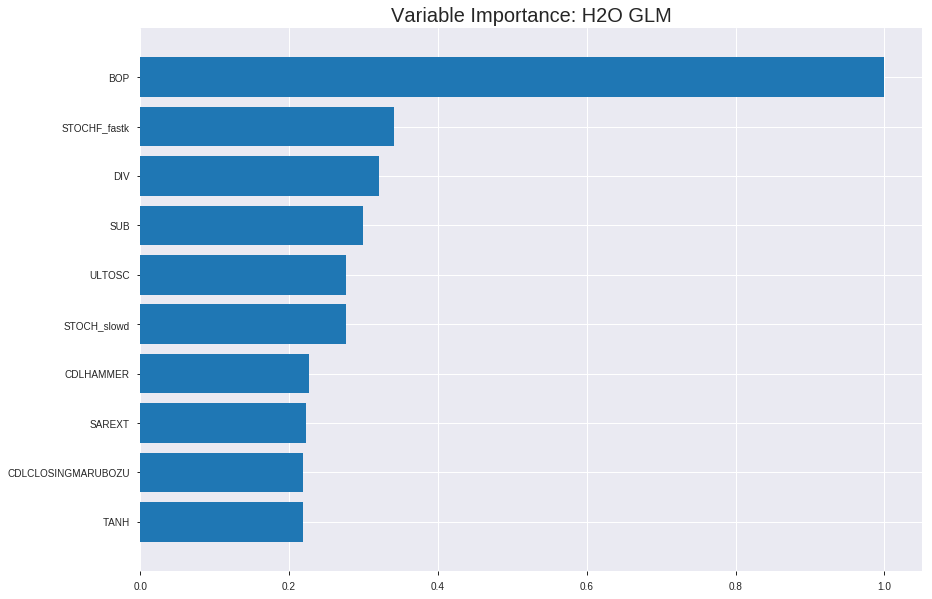

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_153540_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.21007753692520345
RMSE: 0.4583421614091414
LogLoss: 0.6075686291143457
Null degrees of freedom: 1740
Residual degrees of freedom: 1690
Null deviance: 2411.4007677758414
Residual deviance: 2115.5539665761517
AIC: 2217.5539665761517
AUC: 0.7287273399926009
pr_auc: 0.7156477473803365
Gini: 0.45745467998520173
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40705177146411414: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      366  474   0.5643   (474.0/840.0)
1      131  770   0.1454   (131.0/901.0)
Total  497  1244  0.3475   (605.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.407052     0.717949  256
max f2                       0.197885     0.853333  359
max f0point5                 0.531094     0.692049  183
max accuracy                 0.531094     0.680643  183
max precision                0.96153      1         0
max recall                   0.108633     1         389
max specificity              0.96153      1         0
max absolute_mcc             0.531094     0.360783  183
max min_per_class_accuracy   0.535872     0.675916  181
max mean_per_class_accuracy  0.531094     0.680452  183

Gains/Lift Table: Avg response rate: 51.75 %, avg score: 51.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.851753           1.61025   1.61025            0.833333         0.879032  0.833333                    0.879032            0.0166482       0.0166482                  61.0248   61.0248
    2        0.0201034                   0.832044           1.5913    1.60105            0.823529         0.841431  0.828571                    0.860769            0.0155383       0.0321865                  59.1304   60.1046
    3        0.0304423                   0.811427           1.5029    1.56771            0.777778         0.821625  0.811321                    0.847474            0.0155383       0.0477248                  50.2898   56.7713
    4        0.0402068                   0.793365           1.70497   1.60105            0.882353         0.803421  0.828571                    0.836776            0.0166482       0.0643729                  70.4968   60.1046
    5        0.0505457                   0.784802           1.39555   1.55901            0.722222         0.789523  0.806818                    0.82711             0.0144284       0.0788013                  39.5548   55.9013
    6        0.100517                    0.743646           1.48809   1.52375            0.770115         0.763965  0.788571                    0.795718            0.0743618       0.153163                   48.8091   52.3755
    7        0.150488                    0.709553           1.48809   1.51191            0.770115         0.726062  0.782443                    0.772588            0.0743618       0.227525                   48.8091   51.1912
    8        0.20046                     0.684248           1.35483   1.47275            0.701149         0.69595   0.762178                    0.753483            0.0677026       0.295228                   35.4829   47.2754
    9        0.300402                    0.635557           1.35483   1.43352            0.701149         0.659701  0.741874                    0.722282            0.135405        0.430633                   35.4829   43.3521
    10       0.400345                    0.590781           1.24378   1.38615            0.643678         0.611887  0.71736                     0.694723            0.124306        0.554939                   24.3778   38.6153
    11       0.500287                    0.536303           1.16604   1.34218            0.603448         0.563179  0.694604                    0.668445            0.116537        0.671476                   16.6042   34.2181
    12       0.60023                     0.47975            0.888413  1.26663            0.45977          0.510263  0.655502                    0.642106            0.0887902       0.760266                   -11.1587  26.6626
    13       0.700172                    0.416806           0.821782  1.20313            0.425287         0.447859  0.622642                    0.614379            0.082131        0.842397                   -17.8218  20.3129
    14       0.800115                    0.350861           0.68852   1.13885            0.356322         0.383727  0.589375                    0.585569            0.0688124       0.91121                    -31.148   13.8849
    15       0.900057                    0.260536           0.632994  1.08268            0.327586         0.304666  0.560306                    0.554377            0.063263        0.974473                   -36.7006  8.26785
    16       1                           0.0330596          0.255419  1                  0.132184         0.185581  0.517519                    0.517519         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21336648140962336
RMSE: 0.4619160978030787
LogLoss: 0.6141527884125699
Null degrees of freedom: 497
Residual degrees of freedom: 447
Null deviance: 690.4254926589902
Residual deviance: 611.6961772589195
AIC: 713.6961772589195
AUC: 0.7200451722190853
pr_auc: 0.7186952410449307
Gini: 0.4400903444381705
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36446670432583217: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      85   160  0.6531   (160.0/245.0)
1      17   236  0.0672   (17.0/253.0)
Total  102  396  0.3554   (177.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.364467     0.727273  311
max f2                       0.225815     0.845166  370
max f0point5                 0.625257     0.662589  137
max accuracy                 0.472542     0.660643  235
max precision                0.874869     1         0
max recall                   0.098674     1         390
max specificity              0.874869     1         0
max absolute_mcc             0.364467     0.346544  311
max min_per_class_accuracy   0.538211     0.640816  191
max mean_per_class_accuracy  0.472542     0.658974  235

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 52.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.841688           1.96838   1.96838            1                0.860938  1                           0.860938            0.0197628       0.0197628                  96.8379   96.8379
    2        0.0200803                   0.806              1.96838   1.96838            1                0.823705  1                           0.842321            0.0197628       0.0395257                  96.8379   96.8379
    3        0.0301205                   0.794214           1.96838   1.96838            1                0.800238  1                           0.828293            0.0197628       0.0592885                  96.8379   96.8379
    4        0.0401606                   0.790289           1.96838   1.96838            1                0.791954  1                           0.819209            0.0197628       0.0790514                  96.8379   96.8379
    5        0.0502008                   0.785358           0.393676  1.65344            0.2              0.788173  0.84                        0.813001            0.00395257      0.083004                   -60.6324  65.3439
    6        0.100402                    0.751459           1.73217   1.69281            0.88             0.767618  0.86                        0.79031             0.0869565       0.16996                    73.2174   69.2806
    7        0.150602                    0.718804           1.3385    1.5747             0.68             0.736402  0.8                         0.772341            0.0671937       0.237154                   33.8498   57.4704
    8        0.200803                    0.700897           1.25976   1.49597            0.64             0.709179  0.76                        0.75655             0.0632411       0.300395                   25.9763   49.5968
    9        0.301205                    0.652586           1.37787   1.4566             0.7              0.672781  0.74                        0.728627            0.13834         0.438735                   37.7866   45.6601
    10       0.399598                    0.608423           1.08462   1.36501            0.55102          0.630231  0.693467                    0.704399            0.106719        0.545455                   8.46172   36.5007
    11       0.5                         0.542057           0.905455  1.27273            0.46             0.572812  0.646586                    0.677976            0.0909091       0.636364                   -9.45455  27.2727
    12       0.600402                    0.475369           1.14166   1.25081            0.58             0.508441  0.635452                    0.649625            0.114625        0.750988                   14.166    25.081
    13       0.698795                    0.419928           1.00428   1.2161             0.510204         0.445447  0.617816                    0.620876            0.0988142       0.849802                   0.427523  21.6096
    14       0.799197                    0.359428           0.826719  1.16718            0.42             0.392952  0.592965                    0.592242            0.083004        0.932806                   -17.3281  16.718
    15       0.899598                    0.261463           0.314941  1.07206            0.16             0.312578  0.544643                    0.56103             0.0316206       0.964427                   -68.5059  7.20638
    16       1                           0.00358531         0.354308  1                  0.18             0.178926  0.508032                    0.522666           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 15:35:41  0.000 sec   2            17        51            1.37165           1.37278
    2019-08-28 15:35:41  0.013 sec   4            10        51            1.36453           1.36555
    2019-08-28 15:35:41  0.026 sec   6            6.5       51            1.35442           1.3553
    2019-08-28 15:35:41  0.040 sec   8            4         51            1.34091           1.34161
    2019-08-28 15:35:41  0.061 sec   10           2.5       51            1.32422           1.32471
    2019-08-28 15:35:41  0.073 sec   12           1.6       51            1.30541           1.30568
    2019-08-28 15:35:41  0.086 sec   14           0.97      51            1.28624           1.28636
    2019-08-28 15:35:41  0.097 sec   16           0.6       51            1.26853           1.26871
    2019-08-28 15:35:41  0.108 sec   18           0.37      51            1.25345           1.25409
    2019-08-28 15:35:41  0.119 sec   20           0.23      51            1.24138           1.24309
    2019-08-28 15:35:41  0.132 sec   22           0.14      51            1.23204           1.23555
    2019-08-28 15:35:41  0.146 sec   24           0.09      51            1.22483           1.23093
    2019-08-28 15:35:41  0.159 sec   26           0.056     51            1.21929           1.22867
    2019-08-28 15:35:41  0.175 sec   28           0.035     51            1.21514           1.22831
    2019-08-28 15:35:41  0.186 sec   30           0.021     51            1.2122            1.22943
    2019-08-28 15:35:41  0.199 sec   32           0.013     51            1.21027           1.2316
    2019-08-28 15:35:41  0.210 sec   34           0.0083    51            1.20908           1.23442
    2019-08-28 15:35:41  0.222 sec   36           0.0051    51            1.2084            1.23758
    2019-08-28 15:35:41  0.229 sec   37           0.0032    51            1.20804           1.24045

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7068273092369478)

('F1', 0.7475409836065573)

('auc', 0.7698064516129032)

('logloss', 0.5776122494833619)

('mean_per_class_error', 0.2925483870967742)

('rmse', 0.44408622299024614)

('mse', 0.1972125734497426)

glm prediction progress: |████████████████████████████████████████████████| 100%


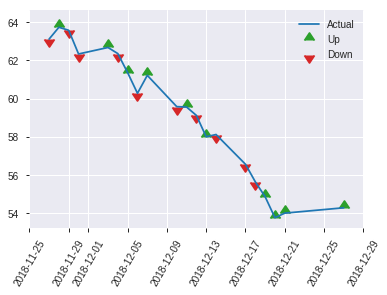


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1972125734497426
RMSE: 0.44408622299024614
LogLoss: 0.5776122494833619
Null degrees of freedom: 248
Residual degrees of freedom: 198
Null deviance: 345.5632631583502
Residual deviance: 287.6509002427142
AIC: 389.6509002427142
AUC: 0.7698064516129032
pr_auc: 0.7360437186204587
Gini: 0.5396129032258064
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3662452341698713: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      58   67   0.536    (67.0/125.0)
1      10   114  0.0806   (10.0/124.0)
Total  68   181  0.3092   (77.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.366245     0.747541  180
max f2                       0.249167     0.86014   218
max f0point5                 0.614165     0.702381  73
max accuracy                 0.408837     0.706827  162
max precision                0.872045     1         0
max recall                   0.212841     1         227
max specificity              0.872045     1         0
max absolute_mcc             0.408837     0.436284  162
max min_per_class_accuracy   0.504024     0.68      124
max mean_per_class_accuracy  0.408837     0.707452  162

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 48.77 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.82292            2.00806    2.00806            1                0.848903  1                           0.848903            0.0241935       0.0241935                  100.806   100.806
    2        0.0200803                   0.803992           2.00806    2.00806            1                0.809184  1                           0.833015            0.016129        0.0403226                  100.806   100.806
    3        0.0321285                   0.775652           2.00806    2.00806            1                0.790298  1                           0.816996            0.0241935       0.0645161                  100.806   100.806
    4        0.0401606                   0.750595           1.00403    1.80726            0.5              0.762349  0.9                         0.806067            0.00806452      0.0725806                  0.403226  80.7258
    5        0.0522088                   0.749051           0          1.3902             0                0.74967   0.692308                    0.793052            0               0.0725806                  -100      39.0199
    6        0.100402                    0.717046           1.84073    1.60645            0.916667         0.731542  0.8                         0.763527            0.0887097       0.16129                    84.0726   60.6452
    7        0.15261                     0.677299           1.69913    1.63816            0.846154         0.698074  0.815789                    0.741136            0.0887097       0.25                       69.9132   63.8158
    8        0.200803                    0.653734           1.84073    1.68677            0.916667         0.666253  0.84                        0.723164            0.0887097       0.33871                    84.0726   68.6774
    9        0.301205                    0.609843           1.36548    1.57968            0.68             0.630184  0.786667                    0.692171            0.137097        0.475806                   36.5484   57.9677
    10       0.401606                    0.551161           0.963871   1.42573            0.48             0.577475  0.71                        0.663497            0.0967742       0.572581                   -3.6129   42.5726
    11       0.502008                    0.504024           1.12452    1.36548            0.56             0.52946   0.68                        0.636689            0.112903        0.685484                   12.4516   36.5484
    12       0.598394                    0.448279           1.00403    1.30726            0.5              0.474297  0.651007                    0.610532            0.0967742       0.782258                   0.403226  30.7263
    13       0.698795                    0.382072           1.04419    1.26947            0.52             0.414721  0.632184                    0.582398            0.104839        0.887097                   4.41935   26.9466
    14       0.799197                    0.32369            0.722903   1.2008             0.36             0.35611   0.59799                     0.55397             0.0725806       0.959677                   -27.7097  20.0802
    15       0.899598                    0.227879           0.32129    1.10264            0.16             0.275804  0.549107                    0.522925            0.0322581       0.991935                   -67.871   10.2643
    16       1                           0.0625566          0.0803226  1                  0.04             0.171768  0.497992                   

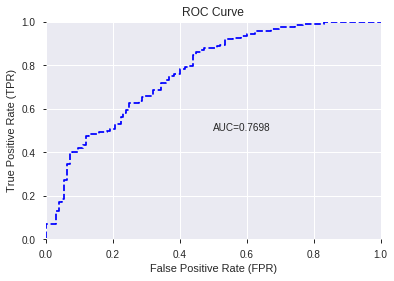

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


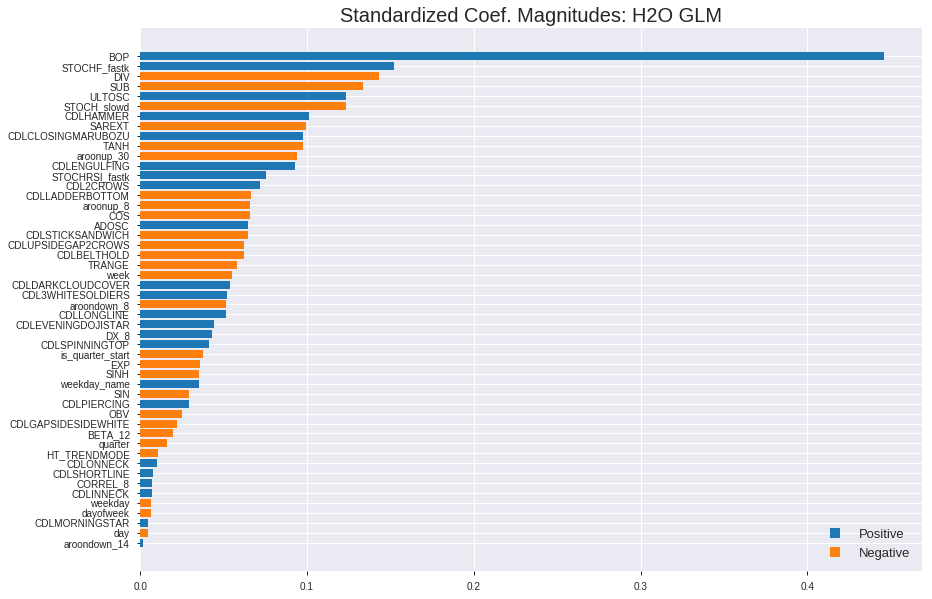

'log_likelihood'
--2019-08-28 15:35:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_153540_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_153540_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_9b1a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'STOCHF_fastk',
 'DIV',
 'SUB',
 'ULTOSC',
 'STOCH_slowd',
 'CDLHAMMER',
 'SAREXT',
 'CDLCLOSINGMARUBOZU',
 'TANH',
 'aroonup_30',
 'CDLENGULFING',
 'STOCHRSI_fastk',
 'CDL2CROWS',
 'CDLLADDERBOTTOM',
 'aroonup_8',
 'COS',
 'ADOSC',
 'CDLSTICKSANDWICH',
 'CDLUPSIDEGAP2CROWS',
 'CDLBELTHOLD',
 'TRANGE',
 'week',
 'CDLDARKCLOUDCOVER',
 'CDL3WHITESOLDIERS',
 'aroondown_8',
 'CDLLONGLINE',
 'CDLEVENINGDOJISTAR',
 'DX_8',
 'CDLSPINNINGTOP',
 'is_quarter_start',
 'EXP',
 'SINH',
 'weekday_name',
 'SIN',
 'CDLPIERCING',
 'OBV',
 'CDLGAPSIDESIDEWHITE',
 'BETA_12',
 'quarter',
 'HT_TRENDMODE',
 'CDLONNECK',
 'CDLSHORTLINE',
 'CORREL_8',
 'CDLINNECK',
 'weekday',
 'dayofweek',
 'CDLMORNINGSTAR',
 'day',
 'aroondown_14']

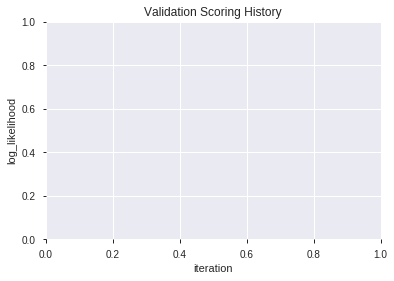

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_153552_model_4  0.760194  0.591073              0.328226  0.449711  0.202240
1  XGBoost_grid_1_AutoML_20190828_153552_model_2  0.759097  0.594209              0.288581  0.450678  0.203111
2               XGBoost_3_AutoML_20190828_153552  0.758839  0.593326              0.304387  0.450456  0.202911
3               XGBoost_2_AutoML_20190828_153552  0.756903  0.591314              0.296516  0.449526  0.202074
4  XGBoost_grid_1_AutoML_20190828_153552_model_6  0.756323  0.595100              0.304258  0.452031  0.204332
5  XGBoost_grid_1_AutoML_20190828_153552_model_7  0.745806  0.597046              0.276871  0.452892  0.205111
6  XGBoost_grid_1_AutoML_20190828_153552_model_3  0.745032  0.600388              0.332387  0.454271  0.206362
7  XGBoost_grid_1_AutoML_20190828_153552_model_1  0.744323  0.597780              0.360129  0.453733  0.205874
8               XGBoost_1_AutoML_20190828_153552  0.739742  0.599915              0.352129  0.454709  0.206760
9  XGBoost_grid_1_AutoML_20190828_153552_model_5  0.713032  0.623459              0.320516  0.465814  0.216983

variable  relative_importance  scaled_importance  percentage
0              BOP          1530.072754           1.000000    0.372303
1              DIV           315.925751           0.206478    0.076872
2              COS           212.445602           0.138847    0.051693
3     STOCHF_fastk           211.697784           0.138358    0.051511
4              SUB           210.284500           0.137434    0.051167
5   STOCHRSI_fastk           172.330795           0.112629    0.041932
6             DX_8           151.708313           0.099151    0.036914
7           SAREXT           137.112350           0.089612    0.033363
8         CORREL_8           124.761765           0.081540    0.030357
9            ADOSC           121.636307           0.079497    0.029597
10      aroonup_30           108.196877           0.070714    0.026327
11             OBV            97.563309           0.063764    0.023739
12         BETA_12            92.253075           0.060293    0.022447
13       aroonup_8            79.073692           0.051680    0.019241
14             EXP            74.581680           0.048744    0.018147
15          TRANGE            72.265823           0.047230    0.017584
16            week            71.879913           0.046978    0.017490
17     STOCH_slowd            70.740730           0.046234    0.017213
18          ULTOSC            60.182877           0.039333    0.014644
19             SIN            59.171059           0.038672    0.014398
20             day            58.456245           0.038205    0.014224
21    aroondown_14            35.275772           0.023055    0.008583
22     aroondown_8            25.849464           0.016894    0.006290
23    weekday_name             9.819901           0.006418    0.002389
24       dayofweek             3.888525           0.002541    0.000946
25         quarter             2.576296           0.001684    0.000627

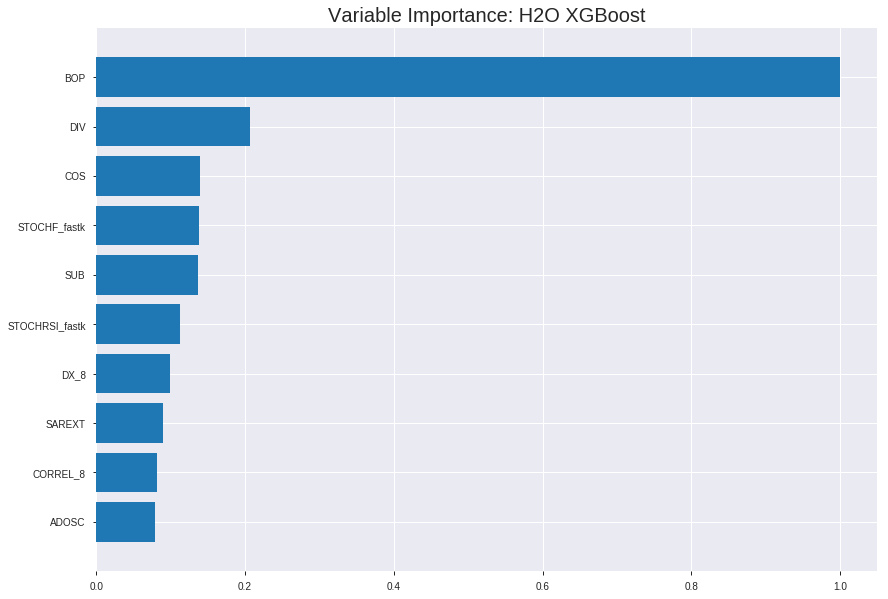

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_153552_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19214353634789258
RMSE: 0.43834180310334603
LogLoss: 0.5689711276807425
Mean Per-Class Error: 0.2794157285555732
AUC: 0.7907602663706992
pr_auc: 0.7956301127424328
Gini: 0.5815205327413984
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4210084180037181: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      422  418   0.4976   (418.0/840.0)
1      111  790   0.1232   (111.0/901.0)
Total  533  1208  0.3038   (529.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.421008     0.74917   251
max f2                       0.329245     0.858616  303
max f0point5                 0.56559      0.740144  162
max accuracy                 0.56559      0.718553  162
max precision                0.83281      1         0
max recall                   0.169027     1         386
max specificity              0.83281      1         0
max absolute_mcc             0.56559      0.443142  162
max min_per_class_accuracy   0.530226     0.713095  183
max mean_per_class_accuracy  0.56559      0.720584  162

Gains/Lift Table: Avg response rate: 51.75 %, avg score: 51.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.799292           1.9323    1.9323             1                0.812534  1                           0.812534            0.0199778       0.0199778                  93.2297   93.2297
    2        0.0201034                   0.791902           1.81863   1.87709            0.941176         0.795828  0.971429                    0.80442             0.017758        0.0377358                  81.8633   87.7089
    3        0.0304423                   0.783401           1.9323    1.89584            1                0.787492  0.981132                    0.798671            0.0199778       0.0577137                  93.2297   89.5839
    4        0.0402068                   0.77375            1.81863   1.87709            0.941176         0.777748  0.971429                    0.79359             0.017758        0.0754717                  81.8633   87.7089
    5        0.0505457                   0.768232           1.61025   1.82251            0.833333         0.770925  0.943182                    0.788954            0.0166482       0.0921199                  61.0248   82.2508
    6        0.100517                    0.739578           1.64356   1.73355            0.850575         0.753535  0.897143                    0.771346            0.082131        0.174251                   64.3563   73.3547
    7        0.150488                    0.715572           1.5103    1.65942            0.781609         0.727538  0.858779                    0.756799            0.0754717       0.249723                   51.0301   65.9416
    8        0.20046                     0.688711           1.64356   1.65546            0.850575         0.702138  0.856734                    0.743173            0.082131        0.331853                   64.3563   65.5464
    9        0.300402                    0.640265           1.4992    1.60347            0.775862         0.664161  0.829828                    0.716886            0.149834        0.481687                   49.9196   60.3474
    10       0.400345                    0.588793           1.18825   1.49982            0.614943         0.614846  0.776184                    0.691413            0.118757        0.600444                   18.8252   49.9818
    11       0.500287                    0.53484            1.0661    1.41317            0.551724         0.563612  0.731343                    0.665882            0.106548        0.706992                   6.60951   41.3173
    12       0.60023                     0.478474           0.866202  1.3221             0.448276         0.508922  0.684211                    0.639747            0.0865705       0.793563                   -13.3798  32.2098
    13       0.700172                    0.415536           0.855097  1.25544            0.442529         0.448668  0.649713                    0.612472            0.0854606       0.879023                   -14.4903  25.5439
    14       0.800115                    0.347836           0.677415  1.18324            0.350575         0.38253   0.612347                    0.58375             0.0677026       0.946726                   -32.2585  18.3237
    15       0.900057                    0.257948           0.32205   1.08761            0.166667         0.301063  0.562859                    0.552361            0.0321865       0.978912                   -67.795   8.76109
    16       1                           0.135629           0.210998  1                  0.109195         0.199639  0.517519                    0.517109         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2160696491638219
RMSE: 0.4648329260754039
LogLoss: 0.6217388785839975
Mean Per-Class Error: 0.33238686779059445
AUC: 0.7144793095103654
pr_auc: 0.7024612569876909
Gini: 0.42895861902073085
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36415648460388184: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      68   177  0.7224   (177.0/245.0)
1      13   240  0.0514   (13.0/253.0)
Total  81   417  0.3815   (190.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.364156     0.716418  324
max f2                       0.28072      0.845166  369
max f0point5                 0.559447     0.677221  176
max accuracy                 0.559447     0.666667  176
max precision                0.80828      1         0
max recall                   0.140418     1         396
max specificity              0.80828      1         0
max absolute_mcc             0.559447     0.337323  176
max min_per_class_accuracy   0.529021     0.656126  197
max mean_per_class_accuracy  0.559447     0.667613  176

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 52.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.784864           1.96838   1.96838            1                0.794871  1                           0.794871            0.0197628       0.0197628                  96.8379   96.8379
    2        0.0200803                   0.775635           1.18103   1.5747             0.6              0.779638  0.8                         0.787255            0.0118577       0.0316206                  18.1028   57.4704
    3        0.0301205                   0.770586           1.96838   1.70593            1                0.773205  0.866667                    0.782571            0.0197628       0.0513834                  96.8379   70.5929
    4        0.0401606                   0.763381           1.96838   1.77154            1                0.768488  0.9                         0.779051            0.0197628       0.0711462                  96.8379   77.1542
    5        0.0502008                   0.755911           1.5747    1.73217            0.8              0.760043  0.88                        0.775249            0.0158103       0.0869565                  57.4704   73.2174
    6        0.100402                    0.728194           1.41723   1.5747             0.72             0.740065  0.8                         0.757657            0.0711462       0.158103                   41.7233   57.4704
    7        0.150602                    0.698468           1.49597   1.54846            0.76             0.713636  0.786667                    0.742983            0.0750988       0.233202                   49.5968   54.8458
    8        0.200803                    0.669987           1.02356   1.41723            0.52             0.687367  0.72                        0.729079            0.0513834       0.284585                   2.35573   41.7233
    9        0.301205                    0.631724           1.4566    1.43036            0.74             0.651978  0.726667                    0.703379            0.146245        0.43083                    45.6601   43.0356
    10       0.399598                    0.58159            1.12479   1.35512            0.571429         0.60489   0.688442                    0.679128            0.110672        0.541502                   12.4788   35.5115
    11       0.5                         0.529727           1.10229   1.30435            0.56             0.556714  0.662651                    0.654547            0.110672        0.652174                   10.2292   30.4348
    12       0.600402                    0.486112           0.944822  1.24423            0.48             0.509543  0.632107                    0.630298            0.0948617       0.747036                   -5.51779  24.4226
    13       0.698795                    0.430949           0.80342   1.18216            0.408163         0.459925  0.600575                    0.606309            0.0790514       0.826087                   -19.658   18.2159
    14       0.799197                    0.382968           0.905455  1.1474             0.46             0.408604  0.582915                    0.581472            0.0909091       0.916996                   -9.45455  14.7397
    15       0.899598                    0.317753           0.511779  1.07646            0.26             0.353625  0.546875                    0.556043            0.0513834       0.968379                   -48.8221  7.64575
    16       1                           0.122339           0.314941  1                  0.16             0.238408  0.508032                    0.524151         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:35:59  3.180 sec   0                  0.5              0.693147            0.5             0                  1                0.482481                         0.5                0.693147              0.5               0                    1                  0.491968
    2019-08-28 15:35:59  3.288 sec   5                  0.484589         0.662673            0.743071        0.733497           1.85798          0.359563                         0.488728           0.670775              0.699718          0.675556             1.5747             0.385542
    2019-08-28 15:35:59  3.349 sec   10                 0.473545         0.640968            0.751235        0.744132           1.7176           0.324526                         0.480943           0.655328              0.704388          0.697138             1.96838            0.36747
    2019-08-28 15:35:59  3.416 sec   15                 0.464855         0.623772            0.760695        0.747767           1.7176           0.333716                         0.475399           0.644163              0.710866          0.706863             1.96838            0.39759
    2019-08-28 15:35:59  3.488 sec   20                 0.459355         0.612746            0.764749        0.75666            1.7176           0.341758                         0.47178            0.636783              0.711245          0.702619             1.96838            0.393574
    2019-08-28 15:36:00  3.557 sec   25                 0.454848         0.603502            0.767664        0.763019           1.9323           0.314187                         0.469511           0.632065              0.713947          0.705468             1.5747             0.373494
    2019-08-28 15:36:00  3.627 sec   30                 0.451647         0.596769            0.770477        0.768504           1.9323           0.336588                         0.468313           0.629462              0.713915          0.70556              1.96838            0.363454
    2019-08-28 15:36:00  3.698 sec   35                 0.448597         0.590407            0.774436        0.777152           1.9323           0.325101                         0.466822           0.626298              0.715367          0.699487             1.96838            0.355422
    2019-08-28 15:36:00  3.775 sec   40                 0.445873         0.5846              0.777601        0.780425           1.9323           0.323952                         0.466628           0.625726              0.713753          0.707373             1.96838            0.369478
    2019-08-28 15:36:00  3.843 sec   45                 0.442897         0.578498            0.782743        0.783049           1.82495          0.332567                         0.465462           0.623223              0.716206          0.70751              1.96838            0.361446
    2019-08-28 15:36:00  3.934 sec   50                 0.440565         0.573572            0.786724        0.79114            1.82495          0.332567                         0.465725           0.623576              0.713318          0.708371             1.96838            0.373494
    2019-08-28 15:36:00  4.017 sec   55                 0.438342         0.568971            0.79076         0.79563            1.9323           0.303848                         0.464833           0.621739              0.714479          0.7

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ---------------------
BOP           1530.07275390625       1.0                    0.3723030164373286
DIV           315.9257507324219      0.20647760044472968    0.07687223347231437
COS           212.4456024169922      0.13884673253256888    0.05169305734434237
STOCHF_fastk  211.69778442382812     0.13835798584307005    0.051511095477568186
SUB           210.2845001220703      0.13743431453518634    0.05116720986344647
---           ---                    ---                    ---
aroondown_14  35.27577209472656      0.023054963892839807   0.008583432601157957
aroondown_8   25.849464416503906     0.016894271432852236   0.006289788214961877
weekday_name  9.819900512695312      0.006417930446526331   0.002389414864526725
dayofweek     3.8885254859924316     0.0025413990779622024  0.0009461705426963737
quarter       2.576296329498291      0.001683773744039981   0.0006268740439040595


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7108433734939759)

('F1', 0.740506329113924)

('auc', 0.7601935483870969)

('logloss', 0.5910726576138824)

('mean_per_class_error', 0.2890645161290323)

('rmse', 0.44971054383627107)

('mse', 0.20223957323751468)

xgboost prediction progress: |████████████████████████████████████████████| 100%


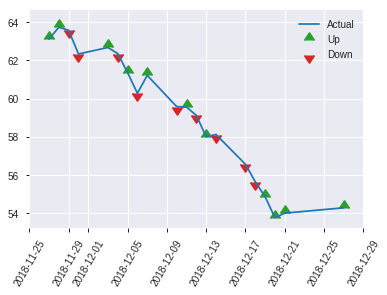


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20223957323751468
RMSE: 0.44971054383627107
LogLoss: 0.5910726576138824
Mean Per-Class Error: 0.2890645161290323
AUC: 0.7601935483870969
pr_auc: 0.7253762788193381
Gini: 0.5203870967741937
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3912353813648224: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      50   75   0.6      (75.0/125.0)
1      7    117  0.0565   (7.0/124.0)
Total  57   192  0.3293   (82.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.391235     0.740506  191
max f2                       0.353301     0.864286  203
max f0point5                 0.502835     0.706522  129
max accuracy                 0.502835     0.710843  129
max precision                0.843953     1         0
max recall                   0.198762     1         240
max specificity              0.843953     1         0
max absolute_mcc             0.502835     0.42228   129
max min_per_class_accuracy   0.513177     0.696     124
max mean_per_class_accuracy  0.502835     0.710935  129

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 51.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.808811           2.00806   2.00806            1                0.82494   1                           0.82494             0.0241935       0.0241935                  100.806   100.806
    2        0.0200803                   0.792755           1.00403   1.60645            0.5              0.801659  0.8                         0.815628            0.00806452      0.0322581                  0.403226  60.6452
    3        0.0321285                   0.779906           2.00806   1.75706            1                0.788586  0.875                       0.805487            0.0241935       0.0564516                  100.806   75.7056
    4        0.0401606                   0.769298           2.00806   1.80726            1                0.776515  0.9                         0.799693            0.016129        0.0725806                  100.806   80.7258
    5        0.0522088                   0.75694            2.00806   1.8536             1                0.765265  0.923077                    0.791748            0.0241935       0.0967742                  100.806   85.3598
    6        0.100402                    0.722365           1.33871   1.60645            0.666667         0.741265  0.8                         0.767516            0.0645161       0.16129                    33.871    60.6452
    7        0.15261                     0.702734           1.3902    1.53247            0.692308         0.712882  0.763158                    0.748826            0.0725806       0.233871                   39.0199   53.247
    8        0.200803                    0.681295           1.67339   1.56629            0.833333         0.689048  0.78                        0.734479            0.0806452       0.314516                   67.3387   56.629
    9        0.301205                    0.631626           1.52613   1.5529             0.76             0.65759   0.773333                    0.708849            0.153226        0.467742                   52.6129   55.2903
    10       0.401606                    0.575445           0.883548  1.38556            0.44             0.603028  0.69                        0.682394            0.0887097       0.556452                   -11.6452  38.5565
    11       0.502008                    0.513177           1.44581   1.39761            0.72             0.541727  0.696                       0.65426             0.145161        0.701613                   44.5806   39.7613
    12       0.598394                    0.464078           0.753024  1.29379            0.375            0.491099  0.644295                    0.627979            0.0725806       0.774194                   -24.6976  29.3787
    13       0.698795                    0.421244           0.883548  1.23484            0.44             0.444301  0.614943                    0.601589            0.0887097       0.862903                   -11.6452  23.4844
    14       0.799197                    0.367231           0.963871  1.2008             0.48             0.398466  0.59799                     0.576071            0.0967742       0.959677                   -3.6129   20.0802
    15       0.899598                    0.288191           0.240968  1.09368            0.12             0.3284    0.544643                    0.548429            0.0241935       0.983871                   -75.9032  9.3678
    16       1                           0.146042           0.160645  1                  0.08             0.217517  0.497992                    0.515205            

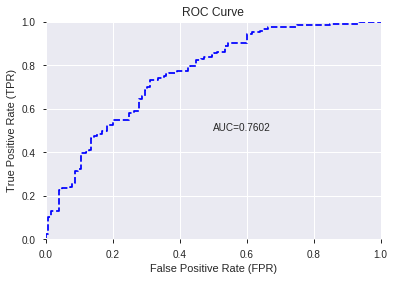

This function is available for GLM models only


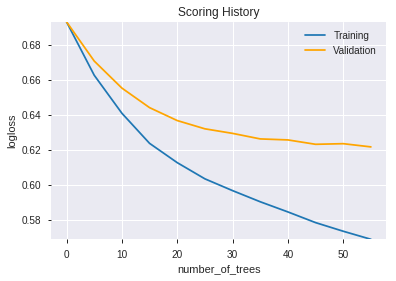

--2019-08-28 15:36:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_153552_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_153552_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_9b1a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'COS',
 'STOCHF_fastk',
 'SUB',
 'STOCHRSI_fastk',
 'DX_8',
 'SAREXT',
 'CORREL_8',
 'ADOSC',
 'aroonup_30',
 'OBV',
 'BETA_12',
 'aroonup_8',
 'EXP',
 'TRANGE',
 'week',
 'STOCH_slowd',
 'ULTOSC',
 'SIN',
 'day',
 'aroondown_14',
 'aroondown_8',
 'weekday_name',
 'dayofweek',
 'quarter']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

27

['BOP',
 'CCI_8',
 'CMO_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'CMO_14',
 'RSI_14',
 'WILLR_14',
 'WILLR_20',
 'WILLR_24',
 'WILLR_30',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'ULTOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_153620_model_6  0.768323  0.579146              0.312419  0.444266  0.197373
1  DeepLearning_grid_1_AutoML_20190828_153620_model_9  0.760516  0.593213              0.304484  0.450848  0.203264
2  DeepLearning_grid_1_AutoML_20190828_153620_model_4  0.760387  0.586847              0.348323  0.447335  0.200109
3  DeepLearning_grid_1_AutoML_20190828_153620_model_8  0.759419  0.586104              0.320387  0.448230  0.200910
4  DeepLearning_grid_1_AutoML_20190828_153620_model_3  0.758194  0.595203              0.296387  0.448719  0.201349
5  DeepLearning_grid_1_AutoML_20190828_153620_model_7  0.751677  0.627911              0.344355  0.468250  0.219258
6  DeepLearning_grid_1_AutoML_20190828_153620_model_5  0.750516  0.602011              0.316484  0.455278  0.207278
7               DeepLearning_1_AutoML_20190828_153620  0.747484  0.639059              0.324323  0.472361  0.223125
8  DeepLearning_grid_1_AutoML_20190828_153620_model_1  0.742258  0.649448              0.316677  0.464274  0.215550
9  DeepLearning_grid_1_AutoML_20190828_153620_model_2  0.742065  0.611558              0.340226  0.460300  0.211876

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.071574
1         CDLSHORTLINE             0.969369           0.969369    0.069381
2   CDLCLOSINGMARUBOZU             0.742111           0.742111    0.053116
3                  DIV             0.731331           0.731331    0.052344
4                  SUB             0.710098           0.710098    0.050824
5               TRANGE             0.673042           0.673042    0.048172
6          CDLMARUBOZU             0.593106           0.593106    0.042451
7          CDLLONGLINE             0.581741           0.581741    0.041637
8          CDLBELTHOLD             0.572801           0.572801    0.040997
9               ULTOSC             0.537332           0.537332    0.038459
10        STOCHF_fastk             0.520487           0.520487    0.037253
11              CCI_12             0.518764           0.518764    0.037130
12      STOCHRSI_fastk             0.503895           0.503895    0.036066
13               CCI_8             0.503190           0.503190    0.036015
14        CDLENGULFING             0.489838           0.489838    0.035059
15              CMO_14             0.398090           0.398090    0.028493
16             WILLR_8             0.385618           0.385618    0.027600
17            WILLR_30             0.381500           0.381500    0.027305
18              RSI_14             0.378906           0.378906    0.027120
19            WILLR_12             0.374492           0.374492    0.026804
20            WILLR_20             0.365504           0.365504    0.026160
21            WILLR_14             0.349531           0.349531    0.025017
22              CMO_12             0.346098           0.346098    0.024771
23               CMO_8             0.343380           0.343380    0.024577
24            WILLR_24             0.339587           0.339587    0.024305
25               RSI_8             0.339586           0.339586    0.024305
26              RSI_12             0.322233           0.322233    0.023063

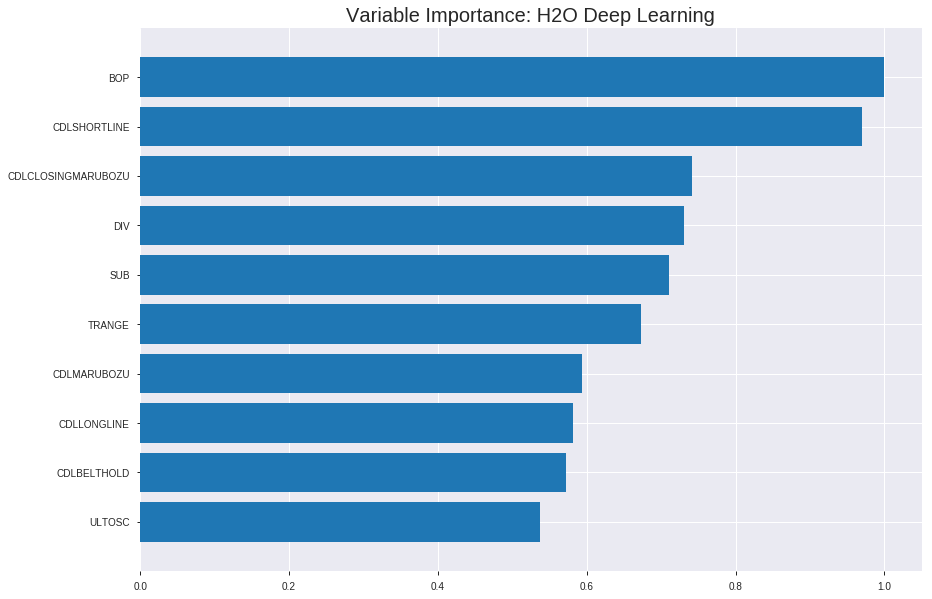

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_153620_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.21319312875225999
RMSE: 0.4617284144952095
LogLoss: 0.6165547560481098
Mean Per-Class Error: 0.3271649225728027
AUC: 0.7274866550393743
pr_auc: 0.7175813467665092
Gini: 0.4549733100787485
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29820000563248966: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      318  522   0.6214   (522.0/840.0)
1      97   804   0.1077   (97.0/901.0)
Total  415  1326  0.3555   (619.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.2982       0.722048  287
max f2                       0.0932573    0.851287  369
max f0point5                 0.499092     0.684398  192
max accuracy                 0.499092     0.673176  192
max precision                0.965456     1         0
max recall                   0.0428863    1         389
max specificity              0.965456     1         0
max absolute_mcc             0.499092     0.34563   192
max min_per_class_accuracy   0.504093     0.670366  188
max mean_per_class_accuracy  0.499092     0.672835  192

Gains/Lift Table: Avg response rate: 51.75 %, avg score: 47.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.881826           1.9323    1.9323             1                0.900047   1                           0.900047            0.0199778       0.0199778                  93.2297   93.2297
    2        0.0201034                   0.867423           1.25031   1.60105            0.647059         0.873185   0.828571                    0.887               0.0122087       0.0321865                  25.031    60.1046
    3        0.0304423                   0.855754           1.61025   1.60417            0.833333         0.862147   0.830189                    0.878559            0.0166482       0.0488346                  61.0248   60.4171
    4        0.0402068                   0.843775           1.47764   1.57344            0.764706         0.850431   0.814286                    0.871728            0.0144284       0.063263                   47.7639   57.3442
    5        0.0505457                   0.825652           1.61025   1.58097            0.833333         0.835722   0.818182                    0.864363            0.0166482       0.0799112                  61.0248   58.0971
    6        0.100517                    0.75111            1.53251   1.55688            0.793103         0.782269   0.805714                    0.823551            0.0765816       0.156493                   53.2512   55.688
    7        0.150488                    0.7116             1.37704   1.49716            0.712644         0.731383   0.774809                    0.792945            0.0688124       0.225305                   37.704    49.7162
    8        0.20046                     0.677253           1.5103    1.50044            0.781609         0.694635   0.776504                    0.768438            0.0754717       0.300777                   51.0301   50.0437
    9        0.300402                    0.603843           1.25488   1.41874            0.649425         0.640574   0.734226                    0.725898            0.125416        0.426193                   25.4883   41.8742
    10       0.400345                    0.559108           1.24378   1.37506            0.643678         0.579853   0.711621                    0.689439            0.124306        0.550499                   24.3778   37.5064
    11       0.500287                    0.506732           1.14383   1.32887            0.591954         0.533118   0.687715                    0.658211            0.114317        0.664817                   14.3831   32.887
    12       0.60023                     0.450116           0.932833  1.26293            0.482759         0.477209   0.653589                    0.628073            0.0932297       0.758047                   -6.71667  26.2927
    13       0.700172                    0.37258            0.888413  1.20947            0.45977          0.416795   0.625923                    0.597915            0.0887902       0.846837                   -11.1587  20.9469
    14       0.800115                    0.247723           0.666309  1.14162            0.344828         0.310766   0.590811                    0.562047            0.0665927       0.91343                    -33.3691  14.1623
    15       0.900057                    0.122662           0.588573  1.08021            0.304598         0.178463   0.55903                     0.519454            0.0588235       0.972253                   -41.1427  8.02122
    16       1                           0.0129873          0.277629  1                  0.143678         0.0790437  0.517519                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2094291163613473
RMSE: 0.4576342604759256
LogLoss: 0.6069456076491782
Mean Per-Class Error: 0.3259014277647818
AUC: 0.7313785593288699
pr_auc: 0.7262091061068332
Gini: 0.4627571186577397
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39048327842863567: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      103  142  0.5796   (142.0/245.0)
1      30   223  0.1186   (30.0/253.0)
Total  133  365  0.3454   (172.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.390483     0.721683  277
max f2                       0.182442     0.849381  346
max f0point5                 0.520722     0.679694  177
max accuracy                 0.485739     0.674699  207
max precision                0.91004      1         0
max recall                   0.0583604    1         398
max specificity              0.91004      1         0
max absolute_mcc             0.475588     0.350532  216
max min_per_class_accuracy   0.501655     0.661224  194
max mean_per_class_accuracy  0.485739     0.674099  207

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 48.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.858596           1.96838   1.96838            1                0.886432  1                           0.886432            0.0197628       0.0197628                  96.8379   96.8379
    2        0.0200803                   0.829349           1.18103   1.5747             0.6              0.847196  0.8                         0.866814            0.0118577       0.0316206                  18.1028   57.4704
    3        0.0301205                   0.792392           1.5747    1.5747             0.8              0.808621  0.8                         0.847416            0.0158103       0.0474308                  57.4704   57.4704
    4        0.0401606                   0.783638           1.96838   1.67312            1                0.787937  0.85                        0.832546            0.0197628       0.0671937                  96.8379   67.3123
    5        0.0502008                   0.770237           1.5747    1.65344            0.8              0.775294  0.84                        0.821096            0.0158103       0.083004                   57.4704   65.3439
    6        0.100402                    0.732746           1.73217   1.69281            0.88             0.754379  0.86                        0.787737            0.0869565       0.16996                    73.2174   69.2806
    7        0.150602                    0.683199           1.5747    1.65344            0.8              0.708066  0.84                        0.76118             0.0790514       0.249012                   57.4704   65.3439
    8        0.200803                    0.652763           1.5747    1.63375            0.8              0.668866  0.83                        0.738102            0.0790514       0.328063                   57.4704   63.3755
    9        0.301205                    0.600758           1.06292   1.44348            0.54             0.625621  0.733333                    0.700608            0.106719        0.434783                   6.29249   44.3478
    10       0.399598                    0.554665           1.12479   1.36501            0.571429         0.579103  0.693467                    0.67069             0.110672        0.545455                   12.4788   36.5007
    11       0.5                         0.504175           1.10229   1.31225            0.56             0.526779  0.666667                    0.641792            0.110672        0.656126                   10.2292   31.2253
    12       0.600402                    0.465189           1.06292   1.27056            0.54             0.482222  0.645485                    0.615108            0.106719        0.762846                   6.29249   27.0559
    13       0.698795                    0.425427           0.763249  1.19913            0.387755         0.44644   0.609195                    0.591359            0.0750988       0.837945                   -23.6751  19.9128
    14       0.799197                    0.300885           0.866087  1.15729            0.44             0.372944  0.58794                     0.56392             0.0869565       0.924901                   -13.3913  15.7288
    15       0.899598                    0.162866           0.511779  1.08524            0.26             0.233762  0.551339                    0.527072            0.0513834       0.976285                   -48.8221  8.52449
    16       1                           0.0104981          0.236206  1                  0.12             0.10812   0.508032                    0.485008         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:39:54  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 15:39:56  1 min 59.449 sec  1018 obs/sec      1         1             1741       0.503291         0.806401            -0.0144523     0.69956         0.683739           1.7176           0.379667                         0.493928           0.767011              0.0238891        0.72374           0.726999             1.96838            0.353414
    2019-08-28 15:40:01  2 min  4.732 sec  2390 obs/sec      9         9             15669      0.464678         0.625162            0.135234       0.71906         0.709557           1.7176           0.361861                         0.459242           0.608669              0.156169         0.726111          0.728729             1.96838            0.36747
    2019-08-28 15:40:06  2 min  9.985 sec  3218 obs/sec      21        21            36561      0.465389         0.625639            0.132587       0.721732        0.712723           1.82495          0.358989                         0.459745           0.608947              0.154321         0.724159          0.719583             1.96838            0.369478
    2019-08-28 15:40:11  2 min 15.055 sec  3593 obs/sec      33        33            57453      0.464177         0.622459            0.137099       0.724827        0.71369            1.61025          0.355543                         0.459241           0.609296              0.156174         0.728071          0.723459             1.96838            0.359438
    2019-08-28 15:40:17  2 min 20.352 sec  3761 obs/sec      45        45            78345      0.464824         0.623474            0.134692       0.722938        0.712988           1.7176           0.351522                         0.458831           0.609426              0.157678         0.731314          0.727809             1.96838            0.373494
    2019-08-28 15:40:22  2 min 25.509 sec  3958 obs/sec      58        58            100978     0.461728         0.616555            0.146179       0.727487        0.717581           1.9323           0.355543                         0.457634           0.606946              0.162067         0.731379          0.726209             1.96838            0.345382
    2019-08-28 15:40:27  2 min 30.589 sec  4102 obs/sec      71        71            123611     0.459674         0.612135            0.153761       0.731279        0.718823           1.7176           0.336014                         0.458799           0.608162              0.157795         0.725046          0.720983             1.96838            0.365462
    2019-08-28 15:40:27  2 min 31.051 sec  4099 obs/sec      71        71            123611     0.461728         0.616555            0.146179       0.727487        0.717581           1.9323           0.355543                         0.457634           0.606946              0.162067         0.731379          0.726209             1.96838            0.345382

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.07157360287311353
CDLSHORTLINE        0.9693691730499268     0.9693691730499268   0.06938124422931391
CDLCLOSINGMARUBOZU  0.7421107292175293     0.7421107292175293   0.053115538620892126
DIV                 0.7313312888145447     0.7313312888145447   0.05234401523429451
SUB                 0.7100978493690491     0.7100978493690491   0.0508242614717923
---                 ---                    ---                  ---
CMO_12              0.34609752893447876    0.34609752893447876  0.0247714470913223
CMO_8               0.3433797061443329     0.3433797061443329   0.0245769227222609
WILLR_24            0.33958712220191956    0.33958712220191956  0.02430547382530366
RSI_8               0.3395861089229584     0.3395861089229584   0.024305401301277695
RSI_12              0.3222328722476959     0.3222328722476959   0.02306336763091931


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7028112449799196)

('F1', 0.74)

('auc', 0.7683225806451613)

('logloss', 0.5791459579636804)

('mean_per_class_error', 0.2971935483870968)

('rmse', 0.44426641237984843)

('mse', 0.19737264516886155)

deeplearning prediction progress: |███████████████████████████████████████| 100%


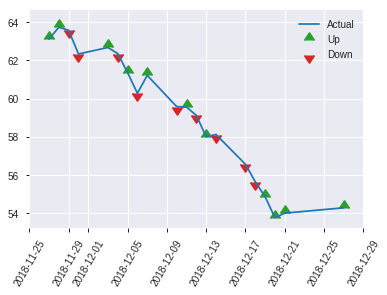


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19737264516886155
RMSE: 0.44426641237984843
LogLoss: 0.5791459579636804
Mean Per-Class Error: 0.2971935483870968
AUC: 0.7683225806451613
pr_auc: 0.7404169483019225
Gini: 0.5366451612903227
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41538120882342355: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   65   0.52     (65.0/125.0)
1      13   111  0.1048   (13.0/124.0)
Total  73   176  0.3133   (78.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.415381     0.74      175
max f2                       0.241516     0.854701  205
max f0point5                 0.538076     0.706897  113
max accuracy                 0.538076     0.702811  113
max precision                0.93688      1         0
max recall                   0.0804096    1         242
max specificity              0.93688      1         0
max absolute_mcc             0.454674     0.412961  156
max min_per_class_accuracy   0.518403     0.701613  123
max mean_per_class_accuracy  0.518403     0.702806  123

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 48.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.875949           2.00806   2.00806            1                0.905339   1                           0.905339            0.0241935       0.0241935                  100.806   100.806
    2        0.0200803                   0.850405           1.00403   1.60645            0.5              0.865397   0.8                         0.889362            0.00806452      0.0322581                  0.403226  60.6452
    3        0.0321285                   0.837793           2.00806   1.75706            1                0.843845   0.875                       0.872293            0.0241935       0.0564516                  100.806   75.7056
    4        0.0401606                   0.820329           1.00403   1.60645            0.5              0.830685   0.8                         0.863971            0.00806452      0.0645161                  0.403226  60.6452
    5        0.0522088                   0.794798           2.00806   1.69913            1                0.805669   0.846154                    0.850517            0.0241935       0.0887097                  100.806   69.9132
    6        0.100402                    0.739952           1.67339   1.68677            0.833333         0.766408   0.84                        0.810145            0.0806452       0.169355                   67.3387   68.6774
    7        0.15261                     0.688029           1.69913   1.691              0.846154         0.714357   0.842105                    0.777375            0.0887097       0.258065                   69.9132   69.1002
    8        0.200803                    0.66167            1.50605   1.64661            0.75             0.674902   0.82                        0.752782            0.0725806       0.330645                   50.6048   64.6613
    9        0.301205                    0.588809           1.28516   1.52613            0.64             0.626563   0.76                        0.710709            0.129032        0.459677                   28.5161   52.6129
    10       0.401606                    0.560317           1.12452   1.42573            0.56             0.573808   0.71                        0.676484            0.112903        0.572581                   12.4516   42.5726
    11       0.502008                    0.51738            1.28516   1.39761            0.64             0.538076   0.696                       0.648802            0.129032        0.701613                   28.5161   39.7613
    12       0.598394                    0.469959           0.836694  1.30726            0.416667         0.48747    0.651007                    0.622816            0.0806452       0.782258                   -16.3306  30.7263
    13       0.698795                    0.424064           0.963871  1.25793            0.48             0.447187   0.626437                    0.597582            0.0967742       0.879032                   -3.6129   25.7925
    14       0.799197                    0.280467           0.642581  1.18062            0.32             0.359801   0.58794                     0.56771             0.0645161       0.943548                   -35.7419  18.0621
    15       0.899598                    0.161991           0.32129   1.08471            0.16             0.221089   0.540179                    0.529024            0.0322581       0.975806                   -67.871   8.47134
    16       1                           0.0219186          0.240968  1                  0.12             0.0994241  0.497992                   

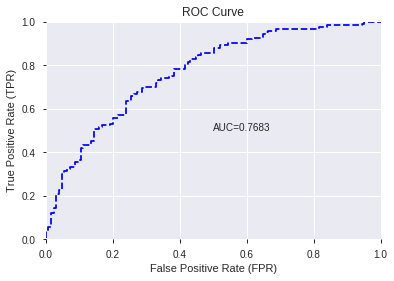

This function is available for GLM models only


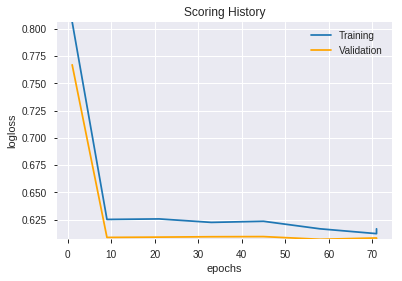

--2019-08-28 15:43:13--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.64.200
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.64.200|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_153620_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_153620_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_9b1a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLSHORTLINE',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'SUB',
 'TRANGE',
 'CDLMARUBOZU',
 'CDLLONGLINE',
 'CDLBELTHOLD',
 'ULTOSC',
 'STOCHF_fastk',
 'CCI_12',
 'STOCHRSI_fastk',
 'CCI_8',
 'CDLENGULFING',
 'CMO_14',
 'WILLR_8',
 'WILLR_30',
 'RSI_14',
 'WILLR_12',
 'WILLR_20',
 'WILLR_14',
 'CMO_12',
 'CMO_8',
 'WILLR_24',
 'RSI_8',
 'RSI_12']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_154319_model_1  0.763677  0.583395              0.320323  0.446885  0.199707

variable  relative_importance  scaled_importance  percentage
0               CMO_12             0.935373           1.000000    0.140497
1               CMO_14             0.934346           0.998903    0.140342
2                  BOP             0.726323           0.776506    0.109096
3               RSI_14             0.617412           0.660071    0.092738
4               RSI_12             0.493205           0.527281    0.074081
5               CCI_12             0.368747           0.394225    0.055387
6         STOCHF_fastk             0.295106           0.315496    0.044326
7                  SUB             0.283827           0.303437    0.042632
8                CCI_8             0.224236           0.239729    0.033681
9             WILLR_12             0.217062           0.232059    0.032604
10            WILLR_30             0.205218           0.219397    0.030825
11         CDLBELTHOLD             0.168191           0.179812    0.025263
12            WILLR_14             0.150130           0.160503    0.022550
13                 DIV             0.133737           0.142977    0.020088
14      STOCHRSI_fastk             0.128219           0.137078    0.019259
15              ULTOSC             0.120299           0.128611    0.018069
16            WILLR_20             0.119018           0.127241    0.017877
17            WILLR_24             0.097958           0.104726    0.014714
18               RSI_8             0.084306           0.090131    0.012663
19        CDLENGULFING             0.080872           0.086459    0.012147
20        CDLSHORTLINE             0.080050           0.085581    0.012024
21             WILLR_8             0.066284           0.070864    0.009956
22               CMO_8             0.047110           0.050365    0.007076
23         CDLMARUBOZU             0.026696           0.028540    0.004010
24         CDLLONGLINE             0.021960           0.023478    0.003299
25              TRANGE             0.017822           0.019053    0.002677
26  CDLCLOSINGMARUBOZU             0.014114           0.015089    0.002120

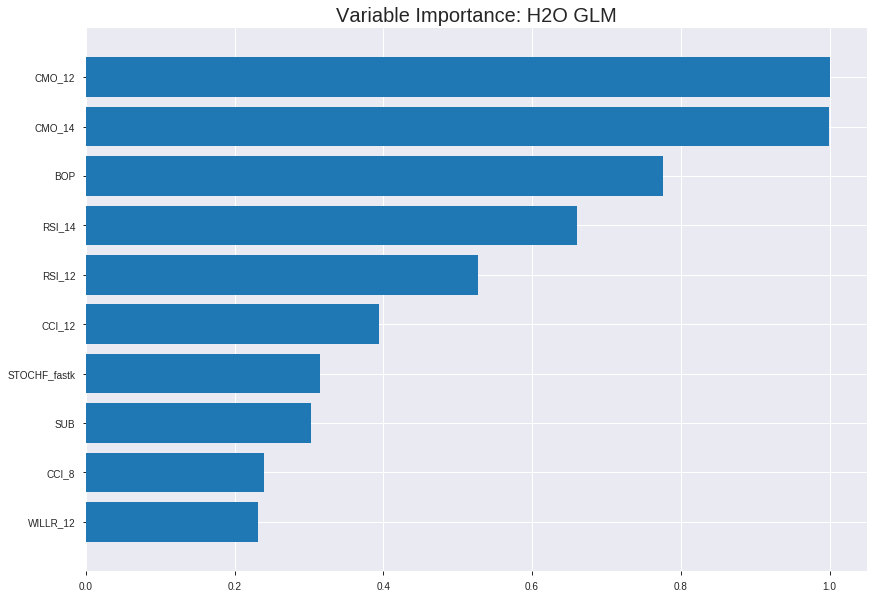

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_154319_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2114639023284883
RMSE: 0.45985204395380075
LogLoss: 0.6100901666693388
Null degrees of freedom: 1740
Residual degrees of freedom: 1713
Null deviance: 2411.4007677758414
Residual deviance: 2124.3339603426375
AIC: 2180.3339603426375
AUC: 0.7234765604354949
pr_auc: 0.7159455381035494
Gini: 0.4469531208709898
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3356339932265809: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      295  545   0.6488   (545.0/840.0)
1      88   813   0.0977   (88.0/901.0)
Total  383  1358  0.3636   (633.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.335634     0.719788  286
max f2                       0.212332     0.852349  347
max f0point5                 0.512355     0.683515  196
max accuracy                 0.512355     0.674899  196
max precision                0.896458     1         0
max recall                   0.123474     1         383
max specificity              0.896458     1         0
max absolute_mcc             0.512355     0.34828   196
max min_per_class_accuracy   0.53595      0.665476  183
max mean_per_class_accuracy  0.512355     0.673573  196

Gains/Lift Table: Avg response rate: 51.75 %, avg score: 51.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.863832           1.7176    1.7176             0.888889         0.876248  0.888889                    0.876248            0.017758        0.017758                   71.7598   71.7598
    2        0.0201034                   0.838926           1.36397   1.54584            0.705882         0.852837  0.8                         0.864877            0.0133185       0.0310766                  36.3975   54.5838
    3        0.0304423                   0.827743           1.7176    1.60417            0.888889         0.833798  0.830189                    0.854322            0.017758        0.0488346                  71.7598   60.4171
    4        0.0402068                   0.818796           1.47764   1.57344            0.764706         0.823666  0.814286                    0.846877            0.0144284       0.063263                   47.7639   57.3442
    5        0.0505457                   0.807221           1.7176    1.60293            0.888889         0.812994  0.829545                    0.839946            0.017758        0.0810211                  71.7598   60.2929
    6        0.100517                    0.759568           1.5103    1.55688            0.781609         0.780778  0.805714                    0.810531            0.0754717       0.156493                   51.0301   55.688
    7        0.150488                    0.735405           1.44367   1.51929            0.747126         0.74826   0.78626                     0.789853            0.0721421       0.228635                   44.3671   51.9287
    8        0.20046                     0.704891           1.46588   1.50597            0.758621         0.72029   0.77937                     0.772512            0.0732519       0.301887                   46.5881   50.5974
    9        0.300402                    0.656098           1.26599   1.42613            0.655172         0.678705  0.73805                     0.741303            0.126526        0.428413                   26.5988   42.6132
    10       0.400345                    0.597495           1.14383   1.35566            0.591954         0.625051  0.701578                    0.712282            0.114317        0.54273                    14.3831   35.5658
    11       0.500287                    0.539494           1.17715   1.32               0.609195         0.568609  0.683123                    0.68358             0.117647        0.660377                   17.7147   31.9997
    12       0.60023                     0.467429           0.977254  1.26293            0.505747         0.504989  0.653589                    0.653844            0.0976693       0.758047                   -2.27461  26.2927
    13       0.700172                    0.399188           0.788466  1.1952             0.408046         0.434661  0.61854                     0.622557            0.0788013       0.836848                   -21.1534  19.5203
    14       0.800115                    0.319204           0.744046  1.13885            0.385057         0.359904  0.589375                    0.589749            0.0743618       0.91121                    -25.5954  13.8849
    15       0.900057                    0.24222            0.566363  1.07528            0.293103         0.283329  0.556477                    0.555724            0.0566038       0.967814                   -43.3637  7.52798
    16       1                           0.0494571          0.32205   1                  0.166667         0.173447  0.517519                    0.517519          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21218774821369515
RMSE: 0.4606384137408594
LogLoss: 0.6136588698137254
Null degrees of freedom: 497
Residual degrees of freedom: 470
Null deviance: 690.4254926589902
Residual deviance: 611.2042343344705
AIC: 667.2042343344705
AUC: 0.7259014277647817
pr_auc: 0.7244131254969317
Gini: 0.45180285552956345
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40879853410585004: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      121  124  0.5061   (124.0/245.0)
1      44   209  0.1739   (44.0/253.0)
Total  165  333  0.3373   (168.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.408799     0.713311  261
max f2                       0.231074     0.840108  367
max f0point5                 0.544979     0.690537  180
max accuracy                 0.544979     0.680723  180
max precision                0.881476     1         0
max recall                   0.0729342    1         397
max specificity              0.881476     1         0
max absolute_mcc             0.544979     0.363779  180
max min_per_class_accuracy   0.524387     0.673469  195
max mean_per_class_accuracy  0.544979     0.681383  180

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 51.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.839662           1.96838   1.96838            1                0.855111  1                           0.855111            0.0197628       0.0197628                  96.8379   96.8379
    2        0.0200803                   0.830039           1.5747    1.77154            0.8              0.834631  0.9                         0.844871            0.0158103       0.0355731                  57.4704   77.1542
    3        0.0301205                   0.819347           1.96838   1.83715            1                0.825397  0.933333                    0.83838             0.0197628       0.055336                   96.8379   83.7154
    4        0.0401606                   0.807293           1.96838   1.86996            1                0.814439  0.95                        0.832395            0.0197628       0.0750988                  96.8379   86.996
    5        0.0502008                   0.796859           0.787352  1.65344            0.4              0.803741  0.84                        0.826664            0.00790514      0.083004                   -21.2648  65.3439
    6        0.100402                    0.769187           1.5747    1.61407            0.8              0.780151  0.82                        0.803407            0.0790514       0.162055                   57.4704   61.4071
    7        0.150602                    0.739421           1.65344   1.62719            0.84             0.754166  0.826667                    0.786994            0.083004        0.245059                   65.3439   62.7194
    8        0.200803                    0.709387           1.3385    1.55502            0.68             0.722919  0.79                        0.770975            0.0671937       0.312253                   33.8498   55.502
    9        0.301205                    0.651535           1.2204    1.44348            0.62             0.678874  0.733333                    0.740275            0.12253         0.434783                   22.0395   44.3478
    10       0.399598                    0.598328           1.2453    1.39468            0.632653         0.628402  0.708543                    0.712728            0.12253         0.557312                   24.5301   39.4681
    11       0.5                         0.524669           1.14166   1.34387            0.58             0.553896  0.682731                    0.680834            0.114625        0.671937                   14.166    34.3874
    12       0.600402                    0.462111           0.787352  1.25081            0.4              0.493244  0.635452                    0.649464            0.0790514       0.750988                   -21.2648  25.081
    13       0.698795                    0.388825           0.923933  1.20478            0.469388         0.423587  0.612069                    0.61766             0.0909091       0.841897                   -7.60668  20.4784
    14       0.799197                    0.329262           0.590514  1.12761            0.3              0.358057  0.572864                    0.585046            0.0592885       0.901186                   -40.9486  12.7614
    15       0.899598                    0.26151            0.590514  1.06767            0.3              0.295622  0.542411                    0.552745            0.0592885       0.960474                   -40.9486  6.76701
    16       1                           0.00232799         0.393676  1                  0.2              0.191209  0.508032                    0.516446            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 15:43:19  0.000 sec   2            .17E2     28            1.3673115185810676  1.3703138315558725
     2019-08-28 15:43:19  0.006 sec   4            .1E2      28            1.3593288292400805  1.3629777636659057
     2019-08-28 15:43:19  0.012 sec   6            .65E1     28            1.3491422280458378  1.353457080382105
     2019-08-28 15:43:19  0.018 sec   8            .4E1      28            1.3369752915221196  1.3417774486803598
     2019-08-28 15:43:19  0.024 sec   10           .25E1     28            1.3232042576669572  1.3280390279304404
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 15:43:19  0.162 sec   44           .11E-3    28            1.2201803333386776  1.2273177396274508
     2019-08-28 15:43:19  0.170 sec   45           .71E-4    28            1.220017115057917   1.2273542636868144
     2019-08-28 15:43:19  0.177 sec   46           .44E-4    28            1.219857528954964   1.227452352762408
     2019-08-28 15:43:19  0.182 sec   47           .27E-4    28            1.2197078654842854  1.2275938353784992
     2019-08-28 15:43:19  0.192 sec   48           .17E-4    28            1.219572223200635   1.2277683080785222


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6947791164658634)

('F1', 0.7402597402597402)

('auc', 0.7636774193548387)

('logloss', 0.5833949961791478)

('mean_per_class_error', 0.3046451612903225)

('rmse', 0.4468854156788254)

('mse', 0.19970657474643658)

glm prediction progress: |████████████████████████████████████████████████| 100%


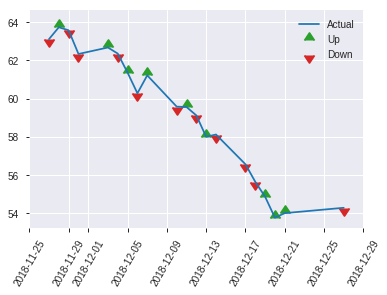


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19970657474643658
RMSE: 0.4468854156788254
LogLoss: 0.5833949961791478
Null degrees of freedom: 248
Residual degrees of freedom: 221
Null deviance: 345.5632631583502
Residual deviance: 290.5307080972156
AIC: 346.5307080972156
AUC: 0.7636774193548387
pr_auc: 0.7385849725254806
Gini: 0.5273548387096774
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37929312611104343: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      55   70   0.56     (70.0/125.0)
1      10   114  0.0806   (10.0/124.0)
Total  65   184  0.3213   (80.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.379293     0.74026   183
max f2                       0.25482      0.857538  226
max f0point5                 0.632892     0.691057  91
max accuracy                 0.495373     0.694779  141
max precision                0.872919     1         0
max recall                   0.25482      1         226
max specificity              0.872919     1         0
max absolute_mcc             0.408952     0.41291   170
max min_per_class_accuracy   0.561163     0.677419  122
max mean_per_class_accuracy  0.446889     0.695355  159

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 52.65 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.838548           2.00806    2.00806            1                0.862342  1                           0.862342            0.0241935       0.0241935                  100.806   100.806
    2        0.0200803                   0.817332           2.00806    2.00806            1                0.828656  1                           0.848867            0.016129        0.0403226                  100.806   100.806
    3        0.0321285                   0.810599           2.00806    2.00806            1                0.814018  1                           0.835799            0.0241935       0.0645161                  100.806   100.806
    4        0.0401606                   0.801124           2.00806    2.00806            1                0.80709   1                           0.830057            0.016129        0.0806452                  100.806   100.806
    5        0.0522088                   0.798796           2.00806    2.00806            1                0.800174  1                           0.823161            0.0241935       0.104839                   100.806   100.806
    6        0.100402                    0.770731           1.33871    1.68677            0.666667         0.779605  0.84                        0.802254            0.0645161       0.169355                   33.871    68.6774
    7        0.15261                     0.735945           1.23573    1.53247            0.615385         0.753368  0.763158                    0.78553             0.0645161       0.233871                   23.5732   53.247
    8        0.200803                    0.711862           1.50605    1.52613            0.75             0.72389   0.76                        0.770736            0.0725806       0.306452                   50.6048   52.6129
    9        0.301205                    0.653392           1.52613    1.52613            0.76             0.681661  0.76                        0.741045            0.153226        0.459677                   52.6129   52.6129
    10       0.401606                    0.605637           1.20484    1.44581            0.6              0.635802  0.72                        0.714734            0.120968        0.580645                   20.4839   44.5806
    11       0.502008                    0.559647           0.963871   1.34942            0.48             0.578292  0.672                       0.687446            0.0967742       0.677419                   -3.6129   34.9419
    12       0.598394                    0.469686           1.0877     1.30726            0.541667         0.510959  0.651007                    0.659018            0.104839        0.782258                   8.77016   30.7263
    13       0.698795                    0.399153           1.04419    1.26947            0.52             0.437367  0.632184                    0.627172            0.104839        0.887097                   4.41935   26.9466
    14       0.799197                    0.345726           0.722903   1.2008             0.36             0.371931  0.59799                     0.595106            0.0725806       0.959677                   -27.7097  20.0802
    15       0.899598                    0.268297           0.32129    1.10264            0.16             0.31489   0.549107                    0.563832            0.0322581       0.991935                   -67.871   10.2643
    16       1                           0.0743805          0.0803226  1                  0.04             0.192371  0.497992                    

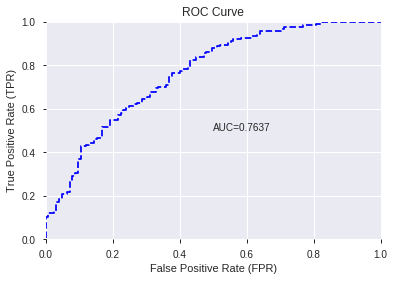

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


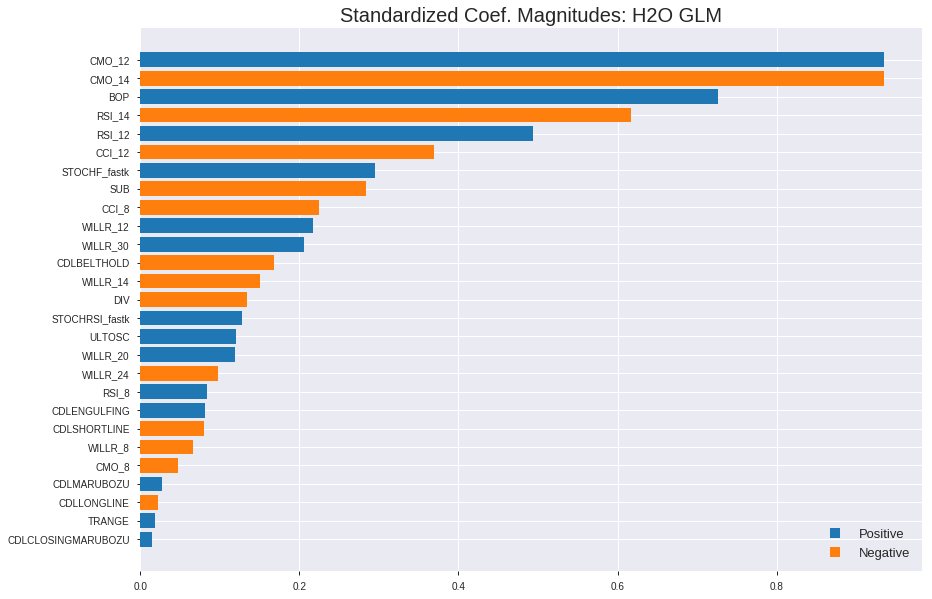

'log_likelihood'
--2019-08-28 15:43:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_154319_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_154319_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_9b1a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CMO_12',
 'CMO_14',
 'BOP',
 'RSI_14',
 'RSI_12',
 'CCI_12',
 'STOCHF_fastk',
 'SUB',
 'CCI_8',
 'WILLR_12',
 'WILLR_30',
 'CDLBELTHOLD',
 'WILLR_14',
 'DIV',
 'STOCHRSI_fastk',
 'ULTOSC',
 'WILLR_20',
 'WILLR_24',
 'RSI_8',
 'CDLENGULFING',
 'CDLSHORTLINE',
 'WILLR_8',
 'CMO_8',
 'CDLMARUBOZU',
 'CDLLONGLINE',
 'TRANGE',
 'CDLCLOSINGMARUBOZU']

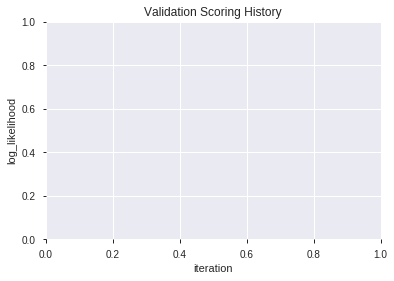

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190828_154330  0.774452  0.580215              0.268323  0.443921  0.197066
1  XGBoost_grid_1_AutoML_20190828_154330_model_6  0.769742  0.581042              0.304290  0.444645  0.197709
2  XGBoost_grid_1_AutoML_20190828_154330_model_1  0.766968  0.585902              0.280516  0.447424  0.200188
3  XGBoost_grid_1_AutoML_20190828_154330_model_2  0.766839  0.587844              0.284484  0.447845  0.200565
4  XGBoost_grid_1_AutoML_20190828_154330_model_4  0.763097  0.586619              0.308290  0.447516  0.200271
5  XGBoost_grid_1_AutoML_20190828_154330_model_3  0.763032  0.585003              0.308290  0.446910  0.199729
6               XGBoost_2_AutoML_20190828_154330  0.760387  0.593238              0.276677  0.449933  0.202440
7               XGBoost_3_AutoML_20190828_154330  0.756194  0.591232              0.284387  0.450013  0.202511
8  XGBoost_grid_1_AutoML_20190828_154330_model_7  0.753226  0.593551              0.304613  0.450592  0.203033
9  XGBoost_grid_1_AutoML_20190828_154330_model_5  0.728903  0.615452              0.308677  0.460807  0.212343

variable  relative_importance  scaled_importance  percentage
0                  BOP          1412.776001           1.000000    0.191360
1                  DIV           527.767334           0.373568    0.071486
2         STOCHF_fastk           514.992554           0.364525    0.069755
3               ULTOSC           452.676331           0.320416    0.061315
4       STOCHRSI_fastk           441.226440           0.312312    0.059764
5                  SUB           429.277954           0.303854    0.058145
6               CCI_12           415.026215           0.293766    0.056215
7               TRANGE           377.600983           0.267276    0.051146
8                CCI_8           369.870270           0.261804    0.050099
9                CMO_8           294.244446           0.208274    0.039855
10            WILLR_30           259.285614           0.183529    0.035120
11             WILLR_8           251.073456           0.177716    0.034008
12              CMO_14           249.529999           0.176624    0.033799
13            WILLR_20           248.289444           0.175746    0.033631
14            WILLR_24           209.102249           0.148008    0.028323
15            WILLR_12           189.117249           0.133862    0.025616
16              CMO_12           167.759216           0.118744    0.022723
17               RSI_8           142.128372           0.100602    0.019251
18            WILLR_14           139.232391           0.098552    0.018859
19              RSI_14            95.667923           0.067716    0.012958
20              RSI_12            73.755783           0.052206    0.009990
21  CDLCLOSINGMARUBOZU            45.477333           0.032190    0.006160
22         CDLLONGLINE            44.696850           0.031638    0.006054
23         CDLBELTHOLD            23.077265           0.016335    0.003126
24        CDLSHORTLINE             3.728848           0.002639    0.000505
25         CDLMARUBOZU             2.985315           0.002113    0.000404
26        CDLENGULFING             2.458621           0.001740    0.000333

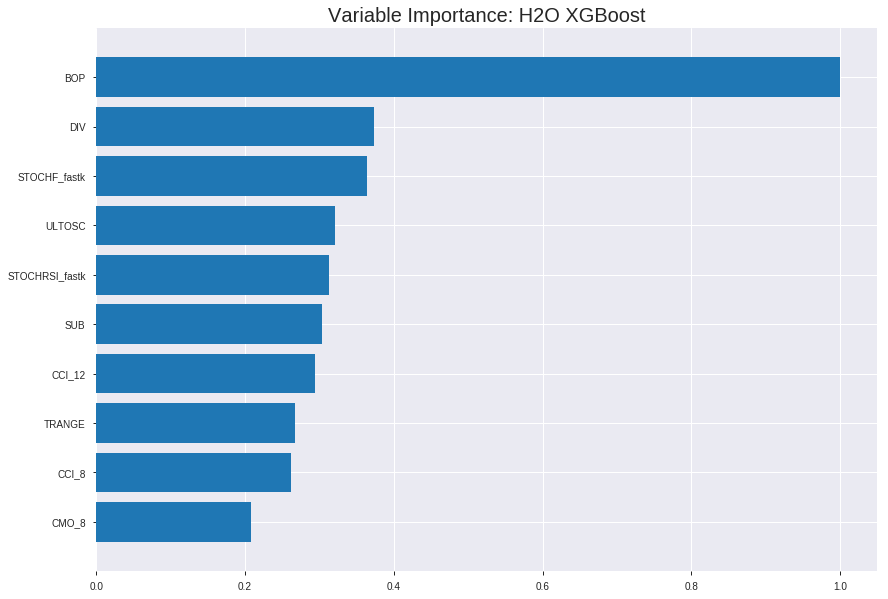

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190828_154330


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1495641563971957
RMSE: 0.38673525362603767
LogLoss: 0.4742791120216545
Mean Per-Class Error: 0.17913627715237035
AUC: 0.905116008667618
pr_auc: 0.9146937038630688
Gini: 0.810232017335236
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49825629591941833: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      652  188  0.2238   (188.0/840.0)
1      130  771  0.1443   (130.0/901.0)
Total  782  959  0.1827   (318.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.498256     0.829032  207
max f2                       0.348496     0.892276  283
max f0point5                 0.605795     0.846676  148
max accuracy                 0.519823     0.820793  195
max precision                0.877661     1         0
max recall                   0.211792     1         355
max specificity              0.877661     1         0
max absolute_mcc             0.536773     0.6414    185
max min_per_class_accuracy   0.523232     0.816667  193
max mean_per_class_accuracy  0.536773     0.820864  185

Gains/Lift Table: Avg response rate: 51.75 %, avg score: 51.65 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.836026           1.9323     1.9323             1                0.848887  1                           0.848887            0.0199778       0.0199778                  93.2297   93.2297
    2        0.0201034                   0.825276           1.9323     1.9323             1                0.83075   1                           0.840078            0.0188679       0.0388457                  93.2297   93.2297
    3        0.0304423                   0.816649           1.9323     1.9323             1                0.820915  1                           0.833569            0.0199778       0.0588235                  93.2297   93.2297
    4        0.0402068                   0.809756           1.9323     1.9323             1                0.813585  1                           0.828716            0.0188679       0.0776915                  93.2297   93.2297
    5        0.0505457                   0.801117           1.9323     1.9323             1                0.805717  1                           0.824012            0.0199778       0.0976693                  93.2297   93.2297
    6        0.100517                    0.772511           1.91009    1.92126            0.988506         0.785769  0.994286                    0.805               0.0954495       0.193119                   91.0087   92.1256
    7        0.150488                    0.749358           1.91009    1.91755            0.988506         0.760751  0.992366                    0.790306            0.0954495       0.288568                   91.0087   91.7547
    8        0.20046                     0.721455           1.84346    1.89908            0.954023         0.734876  0.982808                    0.776488            0.0921199       0.380688                   84.3456   89.9077
    9        0.300402                    0.665027           1.67688    1.82515            0.867816         0.694905  0.944551                    0.749346            0.167592        0.54828                    67.6879   82.5153
    10       0.400345                    0.60402            1.45478    1.73269            0.752874         0.635475  0.8967                      0.720919            0.145394        0.693674                   45.4776   73.2691
    11       0.500287                    0.531469           1.13273    1.61284            0.586207         0.568343  0.834673                    0.690439            0.113208        0.806881                   13.2726   61.2836
    12       0.60023                     0.456672           0.832887   1.48297            0.431034         0.495884  0.767464                    0.658044            0.0832408       0.890122                   -16.7113  48.2969
    13       0.700172                    0.386995           0.599679   1.35689            0.310345         0.420634  0.702215                    0.624156            0.0599334       0.950055                   -40.0321  35.6888
    14       0.800115                    0.311018           0.310944   1.22624            0.16092          0.350502  0.634602                    0.589974            0.0310766       0.981132                   -68.9056  22.6239
    15       0.900057                    0.23079            0.177683   1.10981            0.091954         0.271103  0.574346                    0.554566            0.017758        0.99889                    -82.2317  10.9807
    16       1                           0.0921576          0.0111052  1                  0.00574713       0.173254  0.517519                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2192965082527022
RMSE: 0.46829105079288263
LogLoss: 0.6282323259438968
Mean Per-Class Error: 0.33750100830846175
AUC: 0.700475921593934
pr_auc: 0.6960696253962997
Gini: 0.40095184318786803
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2978133410215378: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      54   191  0.7796   (191.0/245.0)
1      11   242  0.0435   (11.0/253.0)
Total  65   433  0.4056   (202.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.297813     0.705539  344
max f2                       0.252109     0.848093  365
max f0point5                 0.497788     0.667714  207
max accuracy                 0.497788     0.662651  207
max precision                0.868318     1         0
max recall                   0.118581     1         399
max specificity              0.868318     1         0
max absolute_mcc             0.497788     0.32505   207
max min_per_class_accuracy   0.507054     0.656126  203
max mean_per_class_accuracy  0.497788     0.662499  207

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 50.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.821041           1.96838   1.96838            1                0.846283  1                           0.846283            0.0197628       0.0197628                  96.8379   96.8379
    2        0.0200803                   0.812584           1.18103   1.5747             0.6              0.818807  0.8                         0.832545            0.0118577       0.0316206                  18.1028   57.4704
    3        0.0301205                   0.798621           1.96838   1.70593            1                0.805721  0.866667                    0.823604            0.0197628       0.0513834                  96.8379   70.5929
    4        0.0401606                   0.777564           1.96838   1.77154            1                0.791342  0.9                         0.815538            0.0197628       0.0711462                  96.8379   77.1542
    5        0.0502008                   0.770789           1.5747    1.73217            0.8              0.775452  0.88                        0.807521            0.0158103       0.0869565                  57.4704   73.2174
    6        0.100402                    0.732814           1.25976   1.49597            0.64             0.755815  0.76                        0.781668            0.0632411       0.150198                   25.9763   49.5968
    7        0.150602                    0.708694           1.65344   1.54846            0.84             0.722496  0.786667                    0.761944            0.083004        0.233202                   65.3439   54.8458
    8        0.200803                    0.674482           1.49597   1.53534            0.76             0.693322  0.78                        0.744789            0.0750988       0.3083                     49.5968   53.5336
    9        0.301205                    0.616902           1.02356   1.36474            0.52             0.641477  0.693333                    0.710351            0.102767        0.411067                   2.35573   36.4743
    10       0.399598                    0.562696           1.08462   1.29577            0.55102          0.592545  0.658291                    0.681344            0.106719        0.517787                   8.46172   29.5767
    11       0.5                         0.508704           1.3385    1.30435            0.68             0.533175  0.662651                    0.651591            0.134387        0.652174                   33.8498   30.4348
    12       0.600402                    0.450994           0.98419   1.25081            0.5              0.476796  0.635452                    0.622361            0.0988142       0.750988                   -1.58103  25.081
    13       0.698795                    0.409009           0.723078  1.1765             0.367347         0.42962   0.597701                    0.595222            0.0711462       0.822134                   -27.6922  17.6503
    14       0.799197                    0.34781            0.629881  1.10783            0.32             0.37812   0.562814                    0.567948            0.0632411       0.885375                   -37.0119  10.7832
    15       0.899598                    0.270406           0.826719  1.07646            0.42             0.313939  0.546875                    0.539599            0.083004        0.968379                   -17.3281  7.64575
    16       1                           0.118581           0.314941  1                  0.16             0.214363  0.508032                    0.506945          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:43:30  0.007 sec   0                  0.5              0.693147            0.5             0                  1                0.482481                         0.5                0.693147              0.5               0                    1                  0.491968
    2019-08-28 15:43:30  0.120 sec   5                  0.479467         0.652752            0.815046        0.812775           1.82495          0.277427                         0.488893           0.671097              0.704178          0.697277             1.5747             0.36747
    2019-08-28 15:43:30  0.207 sec   10                 0.462569         0.620155            0.833121        0.84003            1.9323           0.244113                         0.481312           0.65606               0.707445          0.698876             1.5747             0.355422
    2019-08-28 15:43:31  0.317 sec   15                 0.449657         0.595334            0.8442          0.85453            1.9323           0.241241                         0.476291           0.646069              0.713955          0.705048             1.5747             0.381526
    2019-08-28 15:43:31  0.423 sec   20                 0.438324         0.57347             0.851911        0.860389           1.9323           0.246984                         0.472054           0.637327              0.712576          0.703824             1.5747             0.409639
    2019-08-28 15:43:31  0.535 sec   25                 0.428041         0.553574            0.860198        0.869063           1.9323           0.22803                          0.469577           0.632072              0.710898          0.702978             1.5747             0.419679
    2019-08-28 15:43:31  0.623 sec   30                 0.419643         0.53724             0.86853         0.877576           1.9323           0.214245                         0.468415           0.629268              0.707486          0.712154             1.96838            0.413655
    2019-08-28 15:43:31  0.720 sec   35                 0.411856         0.522146            0.875536        0.882532           1.9323           0.216542                         0.466395           0.625107              0.712205          0.714369             1.96838            0.35743
    2019-08-28 15:43:31  0.809 sec   40                 0.405224         0.509285            0.882701        0.89258            1.9323           0.196439                         0.467277           0.626643              0.706776          0.709034             1.96838            0.411647
    2019-08-28 15:43:31  0.903 sec   45                 0.398377         0.496058            0.890393        0.901172           1.9323           0.190121                         0.466477           0.624852              0.70709           0.707316             1.96838            0.417671
    2019-08-28 15:43:31  0.992 sec   50                 0.392746         0.485208            0.89631         0.906774           1.9323           0.190121                         0.468227           0.628176              0.700323          0.701357             1.96838            0.415663
    2019-08-28 15:43:31  1.082 sec   55                 0.386735         0.474279            0.905116        0.914694           1.9323           0.182654                         0.468291           0.628232              0.700476          0.6

Variable Importances: 


variable        relative_importance    scaled_importance      percentage
--------------  ---------------------  ---------------------  ----------------------
BOP             1412.7760009765625     1.0                    0.19135982569979035
DIV             527.767333984375       0.3735675957261186     0.0714858300052398
STOCHF_fastk    514.9925537109375      0.3645252703577607     0.06975549219883005
ULTOSC          452.67633056640625     0.3204162091184305     0.06131478992829044
STOCHRSI_fastk  441.2264404296875      0.3123116758245438     0.05976390784979412
---             ---                    ---                    ---
CDLLONGLINE     44.69684982299805      0.031637605531309954   0.006054166680030196
CDLBELTHOLD     23.0772647857666       0.016334694792249266   0.0031258043483040933
CDLSHORTLINE    3.728848457336426      0.002639376981742972   0.0005050707191823739
CDLMARUBOZU     2.9853153228759766     0.002113084679250226   0.00040435951591022065
CDLENGULFING    2.4586212635040283     0.0017402767755146883  0.00033301906043188393


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7309236947791165)

('F1', 0.7728813559322033)

('auc', 0.7744516129032258)

('logloss', 0.5802145931507449)

('mean_per_class_error', 0.26832258064516123)

('rmse', 0.44392120655707534)

('mse', 0.19706603763108957)

xgboost prediction progress: |████████████████████████████████████████████| 100%


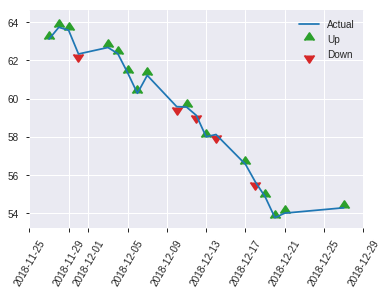


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19706603763108957
RMSE: 0.44392120655707534
LogLoss: 0.5802145931507449
Mean Per-Class Error: 0.26832258064516123
AUC: 0.7744516129032258
pr_auc: 0.7258362468445013
Gini: 0.5489032258064517
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4137674570083618: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      68   57   0.456    (57.0/125.0)
1      10   114  0.0806   (10.0/124.0)
Total  78   171  0.2691   (67.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.413767     0.772881  170
max f2                       0.311309     0.856941  209
max f0point5                 0.502125     0.71875   128
max accuracy                 0.413767     0.730924  170
max precision                0.848193     1         0
max recall                   0.1919       1         242
max specificity              0.848193     1         0
max absolute_mcc             0.413767     0.499499  170
max min_per_class_accuracy   0.512759     0.704     124
max mean_per_class_accuracy  0.413767     0.731677  170

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 51.45 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.827417           1.33871    1.33871            0.666667         0.83779   0.666667                    0.83779             0.016129        0.016129                   33.871    33.871
    2        0.0200803                   0.816844           2.00806    1.60645            1                0.822953  0.8                         0.831855            0.016129        0.0322581                  100.806   60.6452
    3        0.0321285                   0.807856           2.00806    1.75706            1                0.813241  0.875                       0.824875            0.0241935       0.0564516                  100.806   75.7056
    4        0.0401606                   0.800867           2.00806    1.80726            1                0.803319  0.9                         0.820564            0.016129        0.0725806                  100.806   80.7258
    5        0.0522088                   0.789151           1.33871    1.69913            0.666667         0.797178  0.846154                    0.815167            0.016129        0.0887097                  33.871    69.9132
    6        0.100402                    0.751276           1.50605    1.60645            0.75             0.771121  0.8                         0.794025            0.0725806       0.16129                    50.6048   60.6452
    7        0.15261                     0.727594           1.54467    1.58531            0.769231         0.735795  0.789474                    0.774104            0.0806452       0.241935                   54.4665   58.5314
    8        0.200803                    0.700878           1.33871    1.52613            0.666667         0.714211  0.76                        0.75973             0.0645161       0.306452                   33.871    52.6129
    9        0.301205                    0.635305           1.28516    1.44581            0.64             0.666045  0.72                        0.728501            0.129032        0.435484                   28.5161   44.5806
    10       0.401606                    0.572473           1.36548    1.42573            0.68             0.60353   0.71                        0.697259            0.137097        0.572581                   36.5484   42.5726
    11       0.502008                    0.512759           1.36548    1.41368            0.68             0.539528  0.704                       0.665713            0.137097        0.709677                   36.5484   41.3677
    12       0.598394                    0.468908           1.0877     1.36117            0.541667         0.489995  0.677852                    0.637409            0.104839        0.814516                   8.77016   36.1171
    13       0.698795                    0.408144           1.04419    1.31563            0.52             0.437811  0.655172                    0.608731            0.104839        0.919355                   4.41935   31.5628
    14       0.799197                    0.340625           0.32129    1.19071            0.16             0.372317  0.592965                    0.579031            0.0322581       0.951613                   -67.871   19.0712
    15       0.899598                    0.265235           0.401613   1.10264            0.2              0.303381  0.549107                    0.548266            0.0403226       0.991935                   -59.8387  10.2643
    16       1                           0.0943749          0.0803226  1                  0.04             0.212103  0.497992                    

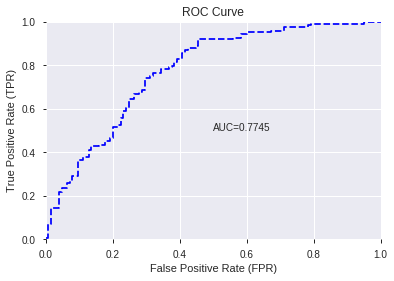

This function is available for GLM models only


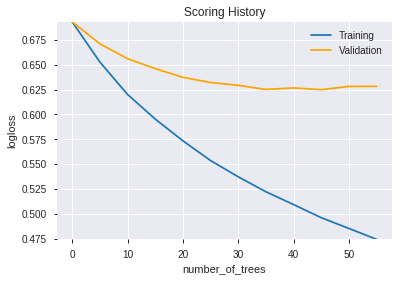

--2019-08-28 15:43:49--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190828_154330',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190828_154330',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_9b1a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_9b1a',
   'type

['BOP',
 'DIV',
 'STOCHF_fastk',
 'ULTOSC',
 'STOCHRSI_fastk',
 'SUB',
 'CCI_12',
 'TRANGE',
 'CCI_8',
 'CMO_8',
 'WILLR_30',
 'WILLR_8',
 'CMO_14',
 'WILLR_20',
 'WILLR_24',
 'WILLR_12',
 'CMO_12',
 'RSI_8',
 'WILLR_14',
 'RSI_14',
 'RSI_12',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLBELTHOLD',
 'CDLSHORTLINE',
 'CDLMARUBOZU',
 'CDLENGULFING']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

233

['BBANDS_middleband_14_3_5',
 'BBANDS_lowerband_14_3_5',
 'BBANDS_upperband_14_4_2',
 'BBANDS_middleband_14_4_2',
 'BBANDS_lowerband_14_4_2',
 'BBANDS_upperband_14_4_3',
 'BBANDS_middleband_14_4_3',
 'BBANDS_upperband_14_4_4',
 'BBANDS_middleband_14_4_4',
 'BBANDS_lowerband_14_4_4',
 'BBANDS_upperband_14_4_5',
 'BBANDS_lowerband_14_4_5',
 'MAVP_14_5',
 'BBANDS_upperband_14_5_2',
 'BBANDS_lowerband_14_5_2',
 'BBANDS_upperband_14_5_4',
 'BBANDS_middleband_14_5_5',
 'MA_14_6',
 'BBANDS_middleband_14_6_2',
 'BBANDS_lowerband_14_6_4',
 'BBANDS_middleband_14_6_5',
 'MAVP_14_7',
 'BBANDS_lowerband_14_7_2',
 'BBANDS_upperband_14_7_3',
 'BBANDS_middleband_14_7_4',
 'BBANDS_lowerband_14_7_4',
 'BBANDS_upperband_14_7_5',
 'BBANDS_middleband_14_7_5',
 'EMA_20',
 'MIDPOINT_20',
 'MIDPRICE_20',
 'BBANDS_middleband_20_0_3',
 'BBANDS_lowerband_20_0_3',
 'BBANDS_lowerband_20_0_4',
 'BBANDS_lowerband_20_0_5',
 'BBANDS_upperband_20_1_3',
 'BBANDS_upperband_20_1_5',
 'BBANDS_middleband_20_1_5',
 'MA_20_2'

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_154501_model_6  0.753871  0.618712              0.296645  0.452508  0.204763
1  DeepLearning_grid_1_AutoML_20190828_154501_model_8  0.752903  0.607277              0.292419  0.456867  0.208728
2  DeepLearning_grid_1_AutoML_20190828_154501_model_3  0.749032  0.607748              0.288645  0.452898  0.205116
3  DeepLearning_grid_1_AutoML_20190828_154501_model_5  0.748452  0.623734              0.336387  0.456746  0.208617
4  DeepLearning_grid_1_AutoML_20190828_154501_model_2  0.743355  0.620747              0.312548  0.458471  0.210196
5  DeepLearning_grid_1_AutoML_20190828_154501_model_9  0.740323  0.600662              0.304484  0.453583  0.205737
6               DeepLearning_1_AutoML_20190828_154501  0.735871  0.725288              0.312677  0.484037  0.234292
7  DeepLearning_grid_1_AutoML_20190828_154501_model_1  0.731032  0.966038              0.376161  0.518530  0.268874
8  DeepLearning_grid_1_AutoML_20190828_154501_model_7  0.729613  0.641936              0.336548  0.469626  0.220548
9  DeepLearning_grid_1_AutoML_20190828_154501_model_4  0.712516  0.786428              0.340516  0.498364  0.248367

variable  relative_importance  scaled_importance  percentage
0                         BOP             1.000000           1.000000    0.016288
1                      TRANGE             0.754815           0.754815    0.012294
2          CDLCLOSINGMARUBOZU             0.624536           0.624536    0.010172
3                 CDLLONGLINE             0.591668           0.591668    0.009637
4                CDLSHORTLINE             0.500764           0.500764    0.008156
..                        ...                  ...                ...         ...
228   BBANDS_lowerband_20_5_4             0.209800           0.209800    0.003417
229   BBANDS_lowerband_20_5_2             0.208084           0.208084    0.003389
230  BBANDS_middleband_14_3_5             0.207746           0.207746    0.003384
231  BBANDS_middleband_30_0_2             0.207474           0.207474    0.003379
232   BBANDS_lowerband_14_4_2             0.205873           0.205873    0.003353

[233 rows x 4 columns]

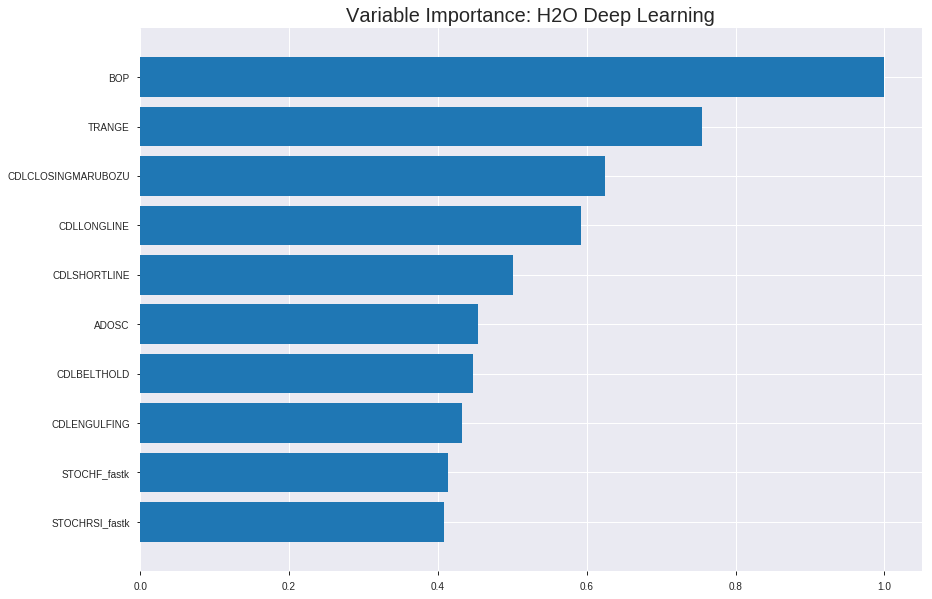

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_154501_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19816804318079492
RMSE: 0.44516069366105865
LogLoss: 0.5769625197050491
Mean Per-Class Error: 0.3019944770360974
AUC: 0.7669348871624122
pr_auc: 0.7752827161836107
Gini: 0.5338697743248244
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3714308801729626: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      353  487   0.5798   (487.0/840.0)
1      90   811   0.0999   (90.0/901.0)
Total  443  1298  0.3314   (577.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.371431     0.737608  268
max f2                       0.11851      0.853543  370
max f0point5                 0.534754     0.715972  170
max accuracy                 0.509277     0.696726  187
max precision                0.988613     1         0
max recall                   0.11851      1         370
max specificity              0.988613     1         0
max absolute_mcc             0.509277     0.396462  187
max min_per_class_accuracy   0.494761     0.693674  196
max mean_per_class_accuracy  0.509277     0.698006  187

Gains/Lift Table: Avg response rate: 51.75 %, avg score: 49.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.947625           1.9323    1.9323             1                0.966426  1                           0.966426            0.0199778       0.0199778                  93.2297   93.2297
    2        0.0201034                   0.922786           1.9323    1.9323             1                0.935678  1                           0.951491            0.0188679       0.0388457                  93.2297   93.2297
    3        0.0304423                   0.894789           1.7176    1.85938            0.888889         0.907213  0.962264                    0.936454            0.017758        0.0566038                  71.7598   85.9381
    4        0.0402068                   0.878285           1.9323    1.87709            1                0.887168  0.971429                    0.924484            0.0188679       0.0754717                  93.2297   87.7089
    5        0.0505457                   0.851151           1.61025   1.82251            0.833333         0.864341  0.943182                    0.912182            0.0166482       0.0921199                  61.0248   82.2508
    6        0.100517                    0.761436           1.57693   1.70042            0.816092         0.80569   0.88                        0.85924             0.0788013       0.170921                   57.6932   70.0422
    7        0.150488                    0.691504           1.55472   1.65204            0.804598         0.724516  0.854962                    0.814504            0.0776915       0.248613                   55.4722   65.2041
    8        0.20046                     0.646625           1.59914   1.63885            0.827586         0.66647   0.848138                    0.777601            0.0799112       0.328524                   59.9143   63.8854
    9        0.300402                    0.583839           1.31041   1.52958            0.678161         0.612584  0.791587                    0.722701            0.130966        0.459489                   31.0409   52.9582
    10       0.400345                    0.540142           1.23267   1.45546            0.637931         0.561798  0.753228                    0.682533            0.123196        0.582686                   23.2673   45.5461
    11       0.500287                    0.496993           1.0661    1.37768            0.551724         0.518006  0.712974                    0.649665            0.106548        0.689234                   6.60951   37.7677
    12       0.60023                     0.454497           0.899518  1.29806            0.465517         0.475911  0.67177                     0.620734            0.0899001       0.779134                   -10.0482  29.806
    13       0.700172                    0.399076           0.799571  1.22691            0.413793         0.42759   0.634947                    0.593165            0.0799112       0.859046                   -20.0429  22.6906
    14       0.800115                    0.336831           0.71073   1.16243            0.367816         0.367824  0.601579                    0.565017            0.0710322       0.930078                   -28.927   16.243
    15       0.900057                    0.213478           0.444206  1.08268            0.229885         0.280213  0.560306                    0.533393            0.0443951       0.974473                   -55.5794  8.26785
    16       1                           0.00952398         0.255419  1                  0.132184         0.127287  0.517519                    0.492805           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2102097389011026
RMSE: 0.4584863562867521
LogLoss: 0.6075018699688242
Mean Per-Class Error: 0.32463499233685567
AUC: 0.7250463821892393
pr_auc: 0.7138561432707271
Gini: 0.45009276437847867
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3188156017556856: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      76   169  0.6898   (169.0/245.0)
1      14   239  0.0553   (14.0/253.0)
Total  90   408  0.3675   (183.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.318816     0.723147  316
max f2                       0.128674     0.847344  378
max f0point5                 0.464109     0.675581  224
max accuracy                 0.464109     0.676707  224
max precision                0.969118     1         0
max recall                   0.10044      1         383
max specificity              0.969118     1         0
max absolute_mcc             0.464109     0.356034  224
max min_per_class_accuracy   0.494726     0.644269  195
max mean_per_class_accuracy  0.464109     0.675365  224

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 49.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.942838           1.96838   1.96838            1                0.957406  1                           0.957406            0.0197628       0.0197628                  96.8379   96.8379
    2        0.0200803                   0.918288           1.18103   1.5747             0.6              0.937191  0.8                         0.947299            0.0118577       0.0316206                  18.1028   57.4704
    3        0.0301205                   0.898677           1.5747    1.5747             0.8              0.909839  0.8                         0.934812            0.0158103       0.0474308                  57.4704   57.4704
    4        0.0401606                   0.891821           1.96838   1.67312            1                0.896916  0.85                        0.925338            0.0197628       0.0671937                  96.8379   67.3123
    5        0.0502008                   0.866934           1.18103   1.5747             0.6              0.879375  0.8                         0.916145            0.0118577       0.0790514                  18.1028   57.4704
    6        0.100402                    0.769927           1.73217   1.65344            0.88             0.815009  0.84                        0.865577            0.0869565       0.166008                   73.2174   65.3439
    7        0.150602                    0.717343           1.5747    1.62719            0.8              0.743096  0.826667                    0.82475             0.0790514       0.245059                   57.4704   62.7194
    8        0.200803                    0.667565           1.3385    1.55502            0.68             0.689096  0.79                        0.790836            0.0671937       0.312253                   33.8498   55.502
    9        0.301205                    0.589387           1.18103   1.43036            0.6              0.625927  0.726667                    0.735867            0.118577        0.43083                    18.1028   43.0356
    10       0.399598                    0.535259           0.923933  1.30566            0.469388         0.556482  0.663317                    0.691697            0.0909091       0.521739                   -7.60668  30.5659
    11       0.5                         0.494726           1.18103   1.28063            0.6              0.515423  0.650602                    0.6563              0.118577        0.640316                   18.1028   28.0632
    12       0.600402                    0.457196           1.25976   1.27714            0.64             0.477796  0.648829                    0.62645             0.126482        0.766798                   25.9763   27.7143
    13       0.698795                    0.401479           0.763249  1.20478            0.387755         0.433735  0.612069                    0.599315            0.0750988       0.841897                   -23.6751  20.4784
    14       0.799197                    0.339088           0.747984  1.1474             0.38             0.372074  0.582915                    0.570767            0.0750988       0.916996                   -25.2016  14.7397
    15       0.899598                    0.204096           0.551146  1.08085            0.28             0.270993  0.549107                    0.53731             0.055336        0.972332                   -44.8854  8.08512
    16       1                           0.000662667        0.275573  1                  0.14             0.124037  0.508032                    0.495817          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:49:20  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 15:49:22  2 min  9.171 sec  799 obs/sec       0.840322  1             1463       0.52939          0.887487            -0.122394      0.650166        0.657828           1.61025          0.448593                         0.517587           0.816841              -0.0718616       0.671429          0.66288              1.96838            0.373494
    2019-08-28 15:49:33  2 min 20.141 sec  1337 obs/sec      9.24756   11            16100      0.471109         0.633582            0.111135       0.714322        0.727198           1.82495          0.36301                          0.467446           0.625744              0.12575          0.708454          0.694209             1.5747             0.333333
    2019-08-28 15:49:42  2 min 28.381 sec  1504 obs/sec      16.8484   20            29333      0.458168         0.606273            0.159296       0.737211        0.746386           1.9323           0.333142                         0.464044           0.617195              0.138432         0.710511          0.701064             1.5747             0.393574
    2019-08-28 15:49:49  2 min 36.350 sec  1592 obs/sec      24.4319   29            42536      0.453965         0.596565            0.174649       0.751663        0.757668           1.9323           0.34463                          0.463048           0.613888              0.142123         0.719747          0.704107             1.96838            0.355422
    2019-08-28 15:49:57  2 min 44.101 sec  1653 obs/sec      32.019    38            55745      0.447496         0.582131            0.198004       0.762092        0.773678           1.9323           0.350373                         0.460076           0.611489              0.1531           0.726095          0.709208             1.5747             0.315261
    2019-08-28 15:50:05  2 min 51.709 sec  1700 obs/sec      39.6088   47            68959      0.445161         0.576963            0.206354       0.766935        0.775283           1.9323           0.331419                         0.458486           0.607502              0.158944         0.725046          0.713856             1.96838            0.36747
    2019-08-28 15:50:13  2 min 59.983 sec  1739 obs/sec      48.0425   57            83642      0.440718         0.567036            0.222116       0.774407        0.784761           1.9323           0.318208                         0.462947           0.620708              0.142498         0.723643          0.700513             1.5747             0.35743
    2019-08-28 15:50:14  3 min  0.770 sec  1738 obs/sec      48.0425   57            83642      0.445161         0.576963            0.206354       0.766935        0.775283           1.9323           0.331419                         0.458486           0.607502              0.158944         0.725046          0.713856             1.96838            0.36747

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.016287518909423288
TRANGE                    0.754814863204956      0.754814863204956    0.012294061357564475
CDLCLOSINGMARUBOZU        0.6245355010032654     0.6245355010032654   0.010172133782196831
CDLLONGLINE               0.5916675925254822     0.5916675925254822   0.009636797101351744
CDLSHORTLINE              0.5007640719413757     0.5007640719413757   0.008156204290904962
---                       ---                    ---                  ---
BBANDS_lowerband_20_5_4   0.20979991555213928    0.20979991555213928  0.0034171200917508778
BBANDS_lowerband_20_5_2   0.20808382332324982    0.20808382332324982  0.003389169207122526
BBANDS_middleband_14_3_5  0.20774604380130768    0.20774604380130768  0.0033836676167716775
BBANDS_middleband_30_0_2  0.207474485039711      0.207474485039711    0.003379244598307152
BBANDS_lowerband_14_4_2   0.2058734893798828     0.2058734893798828   0.003353168351223796


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7028112449799196)

('F1', 0.7375886524822695)

('auc', 0.7538709677419355)

('logloss', 0.6187119781140978)

('mean_per_class_error', 0.2966451612903226)

('rmse', 0.45250765352058475)

('mse', 0.20476317649470557)

deeplearning prediction progress: |███████████████████████████████████████| 100%


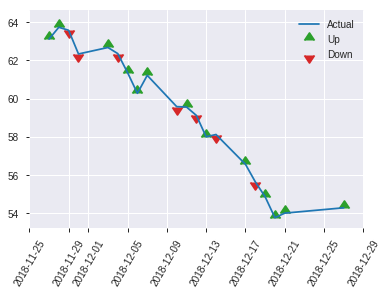


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20476317649470557
RMSE: 0.45250765352058475
LogLoss: 0.6187119781140978
Mean Per-Class Error: 0.2966451612903226
AUC: 0.7538709677419355
pr_auc: 0.7027992119919267
Gini: 0.507741935483871
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43443333152535596: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      71   54   0.432    (54.0/125.0)
1      20   104  0.1613   (20.0/124.0)
Total  91   158  0.2972   (74.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.434433     0.737589  157
max f2                       0.292098     0.858156  208
max f0point5                 0.553549     0.703704  103
max accuracy                 0.475069     0.702811  133
max precision                0.990391     1         0
max recall                   0.0111228    1         248
max specificity              0.990391     1         0
max absolute_mcc             0.434433     0.422281  157
max min_per_class_accuracy   0.495542     0.664     124
max mean_per_class_accuracy  0.434433     0.703355  157

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 51.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.973245           1.33871   1.33871            0.666667         0.985953  0.666667                    0.985953            0.016129        0.016129                   33.871    33.871
    2        0.0200803                   0.964409           2.00806   1.60645            1                0.965534  0.8                         0.977785            0.016129        0.0322581                  100.806   60.6452
    3        0.0321285                   0.954257           2.00806   1.75706            1                0.95928   0.875                       0.970846            0.0241935       0.0564516                  100.806   75.7056
    4        0.0401606                   0.948902           1.00403   1.60645            0.5              0.951618  0.8                         0.967               0.00806452      0.0645161                  0.403226  60.6452
    5        0.0522088                   0.915903           0.669355  1.3902             0.333333         0.938667  0.692308                    0.960462            0.00806452      0.0725806                  -33.0645  39.0199
    6        0.100402                    0.848392           1.67339   1.52613            0.833333         0.880129  0.76                        0.921902            0.0806452       0.153226                   67.3387   52.6129
    7        0.15261                     0.805307           1.3902    1.47963            0.692308         0.826895  0.736842                    0.889399            0.0725806       0.225806                   39.0199   47.9626
    8        0.200803                    0.757473           1.67339   1.52613            0.833333         0.788873  0.76                        0.865273            0.0806452       0.306452                   67.3387   52.6129
    9        0.301205                    0.648314           1.52613   1.52613            0.76             0.701155  0.76                        0.810567            0.153226        0.459677                   52.6129   52.6129
    10       0.401606                    0.55989            1.20484   1.44581            0.6              0.59799   0.72                        0.757423            0.120968        0.580645                   20.4839   44.5806
    11       0.502008                    0.495542           0.883548  1.33335            0.44             0.520393  0.664                       0.710017            0.0887097       0.669355                   -11.6452  33.3355
    12       0.598394                    0.454311           1.33871   1.33422            0.666667         0.471695  0.66443                     0.671629            0.129032        0.798387                   33.871    33.4217
    13       0.698795                    0.389471           0.803226  1.25793            0.4              0.422199  0.626437                    0.635792            0.0806452       0.879032                   -19.6774  25.7925
    14       0.799197                    0.317293           0.642581  1.18062            0.32             0.355275  0.58794                     0.600551            0.0645161       0.943548                   -35.7419  18.0621
    15       0.899598                    0.211462           0.401613  1.09368            0.2              0.27369   0.544643                    0.564071            0.0403226       0.983871                   -59.8387  9.3678
    16       1                           0.0111228          0.160645  1                  0.08             0.122744  0.497992                    0.519761           

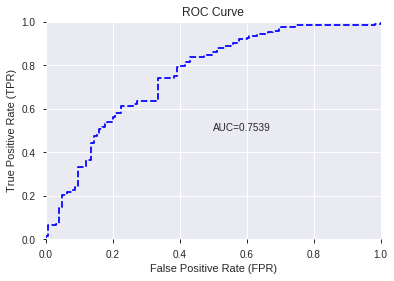

This function is available for GLM models only


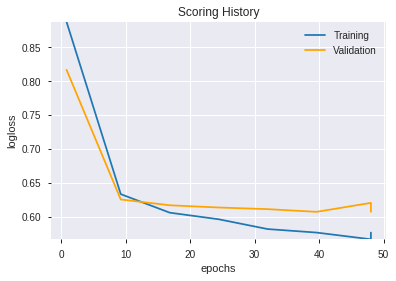

--2019-08-28 15:54:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.131.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.131.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_154501_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_154501_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_9b1a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'TRANGE',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'ADOSC',
 'CDLBELTHOLD',
 'CDLENGULFING',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'CORREL_8',
 'CDLLONGLEGGEDDOJI',
 'CORREL_12',
 'ULTOSC',
 'CORREL_14',
 'HT_DCPERIOD',
 'CDLHAMMER',
 'DX_8',
 'CDLHIKKAKE',
 'aroondown_24',
 'HT_TRENDMODE',
 'DX_24',
 'aroondown_20',
 'DX_30',
 'VAR_8',
 'CCI_8',
 'CDLGRAVESTONEDOJI',
 'DX_20',
 'CDLSPINNINGTOP',
 'CDLDRAGONFLYDOJI',
 'MINUS_DI_24',
 'BETA_12',
 'AROONOSC_30',
 'ADX_8',
 'DX_12',
 'CCI_12',
 'STOCHF_fastd',
 'WILLR_30',
 'aroonup_14',
 'ROCR_20',
 'LINEARREG_ANGLE_14',
 'STOCHRSI_fastd',
 'STOCH_slowk',
 'WILLR_20',
 'ADX_24',
 'MINUS_DI_20',
 'aroonup_20',
 'PLUS_DM_24',
 'ADX_12',
 'STDDEV_8',
 'STDDEV_12',
 'AROONOSC_24',
 'MACDFIX_hist_20',
 'WILLR_14',
 'STOCH_slowd',
 'LINEARREG_ANGLE_8',
 'aroondown_12',
 'HT_PHASOR_inphase',
 'MFI_24',
 'ROCR100_20',
 'RSI_8',
 'LINEARREG_SLOPE_12',
 'CMO_8',
 'ROC_20',
 'aroonup_24',
 'PLUS_DM_12',
 'PLUS_DM_14',
 'PLUS

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_155436_model_1  0.752323  0.590663              0.292194  0.449974  0.202477

variable  relative_importance  scaled_importance  percentage
0                         BOP             0.350892           1.000000    0.065176
1                      TRANGE             0.269999           0.769465    0.050150
2                STOCHF_fastk             0.143332           0.408480    0.026623
3              STOCHRSI_fastk             0.121921           0.347459    0.022646
4               CDLHIKKAKEMOD             0.100370           0.286042    0.018643
..                        ...                  ...                ...         ...
228                 MAVP_24_2             0.000268           0.000765    0.000050
229  BBANDS_middleband_30_0_2             0.000226           0.000644    0.000042
230                   MA_30_0             0.000173           0.000494    0.000032
231                    ADX_12             0.000043           0.000124    0.000008
232              LINEARREG_12             0.000012           0.000034    0.000002

[233 rows x 4 columns]

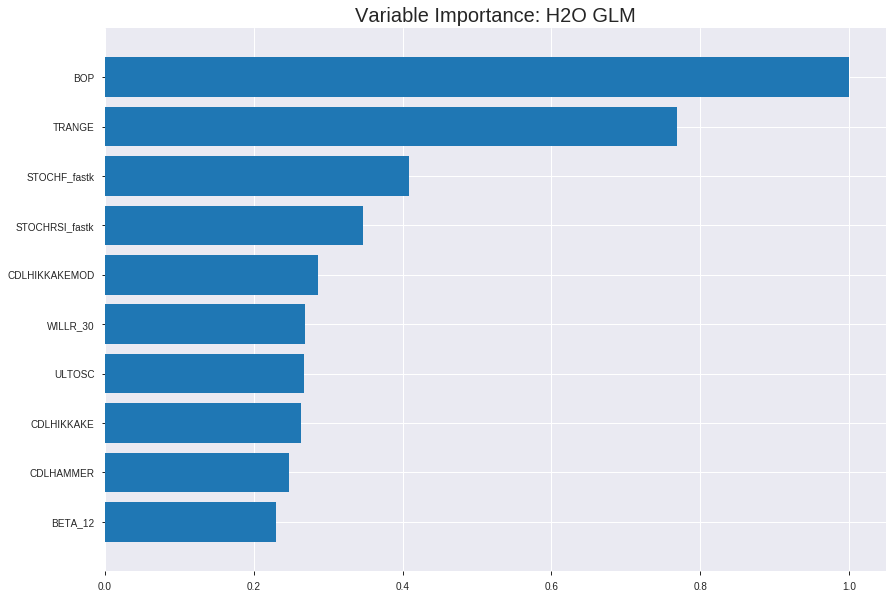

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_155436_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.20649549667716777
RMSE: 0.45441775567991155
LogLoss: 0.6001134129906903
Null degrees of freedom: 1740
Residual degrees of freedom: 1507
Null deviance: 2411.4007677758414
Residual deviance: 2089.5949040335836
AIC: 2557.5949040335836
AUC: 0.7419507425611753
pr_auc: 0.7297137077978632
Gini: 0.48390148512235065
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42675560528311: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      414  426   0.5071   (426.0/840.0)
1      148  753   0.1643   (148.0/901.0)
Total  562  1179  0.3297   (574.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.426756     0.724038  246
max f2                       0.201252     0.851044  362
max f0point5                 0.525215     0.704999  189
max accuracy                 0.525215     0.693854  189
max precision                0.897817     1         0
max recall                   0.168412     1         375
max specificity              0.897817     1         0
max absolute_mcc             0.525215     0.387258  189
max min_per_class_accuracy   0.526122     0.691454  188
max mean_per_class_accuracy  0.525215     0.693699  189

Gains/Lift Table: Avg response rate: 51.75 %, avg score: 51.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.840564           1.61025   1.61025            0.833333         0.855098  0.833333                    0.855098            0.0166482       0.0166482                  61.0248   61.0248
    2        0.0201034                   0.822483           1.36397   1.49063            0.705882         0.831571  0.771429                    0.843671            0.0133185       0.0299667                  36.3975   49.0629
    3        0.0304423                   0.810604           1.7176    1.56771            0.888889         0.816896  0.811321                    0.834578            0.017758        0.0477248                  71.7598   56.7713
    4        0.0402068                   0.799876           1.70497   1.60105            0.882353         0.804682  0.828571                    0.827317            0.0166482       0.0643729                  70.4968   60.1046
    5        0.0505457                   0.783126           1.61025   1.60293            0.833333         0.790678  0.829545                    0.819823            0.0166482       0.0810211                  61.0248   60.2929
    6        0.100517                    0.743037           1.55472   1.57896            0.804598         0.76084   0.817143                    0.7905              0.0776915       0.158713                   55.4722   57.8963
    7        0.150488                    0.710474           1.57693   1.57829            0.816092         0.725295  0.816794                    0.768848            0.0788013       0.237514                   57.6932   57.8289
    8        0.20046                     0.682996           1.35483   1.52258            0.701149         0.695376  0.787966                    0.750533            0.0677026       0.305216                   35.4829   52.2584
    9        0.300402                    0.637187           1.32151   1.45569            0.683908         0.661544  0.753346                    0.720927            0.132075        0.437292                   32.1514   45.5689
    10       0.400345                    0.592023           1.35483   1.43051            0.701149         0.615142  0.740316                    0.694518            0.135405        0.572697                   35.4829   43.051
    11       0.500287                    0.529625           1.09941   1.36437            0.568966         0.561225  0.706085                    0.66789             0.109878        0.682575                   9.94106   36.4366
    12       0.60023                     0.473688           0.855097  1.27957            0.442529         0.503594  0.662201                    0.640534            0.0854606       0.768036                   -14.4903  27.9569
    13       0.700172                    0.412249           0.799571  1.21105            0.413793         0.442903  0.626743                    0.612324            0.0799112       0.847947                   -20.0429  21.1054
    14       0.800115                    0.349027           0.666309  1.14301            0.344828         0.380166  0.591529                    0.583325            0.0665927       0.914539                   -33.3691  14.301
    15       0.900057                    0.260509           0.555258  1.07775            0.287356         0.309442  0.557754                    0.552913            0.0554939       0.970033                   -44.4742  7.7746
    16       1                           0.00919162         0.299839  1                  0.155172         0.198766  0.517519                    0.517519            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2148325522372128
RMSE: 0.46350032603787106
LogLoss: 0.6186576951108305
Null degrees of freedom: 497
Residual degrees of freedom: 264
Null deviance: 690.4254926589902
Residual deviance: 616.1830643303871
AIC: 1084.183064330387
AUC: 0.7159554730983302
pr_auc: 0.6984571048602134
Gini: 0.4319109461966604
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.311000389978554: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      70   175  0.7143   (175.0/245.0)
1      16   237  0.0632   (16.0/253.0)
Total  86   412  0.3835   (191.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.311        0.712782  318
max f2                       0.208226     0.843496  367
max f0point5                 0.485612     0.67033   216
max accuracy                 0.485612     0.668675  216
max precision                0.972521     1         0
max recall                   0.155097     1         389
max specificity              0.972521     1         0
max absolute_mcc             0.47531      0.338766  222
max min_per_class_accuracy   0.512297     0.656126  197
max mean_per_class_accuracy  0.485612     0.667783  216

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 49.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.829344           1.5747    1.5747             0.8              0.882629  0.8                         0.882629            0.0158103       0.0158103                  57.4704   57.4704
    2        0.0200803                   0.807146           1.5747    1.5747             0.8              0.819653  0.8                         0.851141            0.0158103       0.0316206                  57.4704   57.4704
    3        0.0301205                   0.791158           1.96838   1.70593            1                0.801859  0.866667                    0.834713            0.0197628       0.0513834                  96.8379   70.5929
    4        0.0401606                   0.779962           1.18103   1.5747             0.6              0.784986  0.8                         0.822282            0.0118577       0.0632411                  18.1028   57.4704
    5        0.0502008                   0.765035           1.18103   1.49597            0.6              0.774208  0.76                        0.812667            0.0118577       0.0750988                  18.1028   49.5968
    6        0.100402                    0.72202            1.65344   1.5747             0.84             0.741423  0.8                         0.777045            0.083004        0.158103                   65.3439   57.4704
    7        0.150602                    0.690225           1.73217   1.62719            0.88             0.707788  0.826667                    0.753959            0.0869565       0.245059                   73.2174   62.7194
    8        0.200803                    0.666412           1.10229   1.49597            0.56             0.675314  0.76                        0.734298            0.055336        0.300395                   10.2292   49.5968
    9        0.301205                    0.616192           1.37787   1.4566             0.7              0.638912  0.74                        0.702502            0.13834         0.438735                   37.7866   45.6601
    10       0.399598                    0.562296           1.04445   1.35512            0.530612         0.589772  0.688442                    0.674745            0.102767        0.541502                   4.44462   35.5115
    11       0.5                         0.512163           1.14166   1.31225            0.58             0.535003  0.666667                    0.646684            0.114625        0.656126                   14.166    31.2253
    12       0.600402                    0.461535           0.98419   1.25739            0.5              0.48658   0.638796                    0.619911            0.0988142       0.754941                   -1.58103  25.7393
    13       0.698795                    0.398478           0.723078  1.18216            0.367347         0.424442  0.600575                    0.592388            0.0711462       0.826087                   -27.6922  18.2159
    14       0.799197                    0.332982           0.787352  1.13256            0.4              0.364762  0.575377                    0.563792            0.0790514       0.905138                   -21.2648  13.256
    15       0.899598                    0.249806           0.629881  1.07646            0.32             0.294346  0.546875                    0.53372             0.0632411       0.968379                   -37.0119  7.64575
    16       1                           0.0160114          0.314941  1                  0.16             0.182428  0.508032                    0.498449          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 15:54:37  0.000 sec   2            .17E2     234           1.3669191905013556  1.3698309188148021
     2019-08-28 15:54:37  0.133 sec   4            .12E2     234           1.3621274074857699  1.3651541258397182
     2019-08-28 15:54:37  0.260 sec   6            .9E1      234           1.3562554846146186  1.3593369964733748
     2019-08-28 15:54:37  0.382 sec   8            .65E1     234           1.3491703848130918  1.3522883961936383
     2019-08-28 15:54:37  0.508 sec   10           .47E1     234           1.3407619117581127  1.3439075227304544
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 15:54:39  2.543 sec   40           .4E-1     234           1.1949609036416902  1.2377751205801661
     2019-08-28 15:54:40  2.677 sec   42           .29E-1    234           1.1903665819910463  1.2387286202849963
     2019-08-28 15:54:40  2.812 sec   44           .21E-1    234           1.1865132777415315  1.2401984983472278
     2019-08-28 15:54:40  2.955 sec   46           .16E-1    234           1.183133855176949   1.241675568331654
     2019-08-28 15:54:40  3.093 sec   48           .11E-1    234           1.1801864047437336  1.2431447470838666


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7108433734939759)

('F1', 0.7637540453074434)

('auc', 0.7523225806451613)

('logloss', 0.5906628729842467)

('mean_per_class_error', 0.2883870967741935)

('rmse', 0.4499744506952532)

('mse', 0.20247700627849488)

glm prediction progress: |████████████████████████████████████████████████| 100%


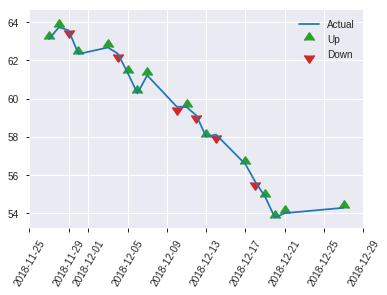


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20247700627849488
RMSE: 0.4499744506952532
LogLoss: 0.5906628729842467
Null degrees of freedom: 248
Residual degrees of freedom: 15
Null deviance: 345.5632631583502
Residual deviance: 294.15011074615484
AIC: 762.1501107461548
AUC: 0.7523225806451613
pr_auc: 0.7266295290408673
Gini: 0.5046451612903227
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3661234275036947: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      58   67   0.536    (67.0/125.0)
1      6    118  0.0484   (6.0/124.0)
Total  64   185  0.2932   (73.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.366123     0.763754  184
max f2                       0.366123     0.866373  184
max f0point5                 0.414232     0.689655  171
max accuracy                 0.414232     0.710843  171
max precision                0.849758     1         0
max recall                   0.148683     1         245
max specificity              0.849758     1         0
max absolute_mcc             0.366123     0.475531  184
max min_per_class_accuracy   0.513605     0.664     124
max mean_per_class_accuracy  0.414232     0.711613  171

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 49.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.835847           2.00806   2.00806            1                0.84599   1                           0.84599             0.0241935       0.0241935                  100.806   100.806
    2        0.0200803                   0.789024           2.00806   2.00806            1                0.819715  1                           0.83548             0.016129        0.0403226                  100.806   100.806
    3        0.0321285                   0.776672           1.33871   1.75706            0.666667         0.783501  0.875                       0.815988            0.016129        0.0564516                  33.871    75.7056
    4        0.0401606                   0.766894           2.00806   1.80726            1                0.774162  0.9                         0.807623            0.016129        0.0725806                  100.806   80.7258
    5        0.0522088                   0.756244           1.33871   1.69913            0.666667         0.759695  0.846154                    0.796562            0.016129        0.0887097                  33.871    69.9132
    6        0.100402                    0.721443           1.84073   1.7671             0.916667         0.73588   0.88                        0.767435            0.0887097       0.177419                   84.0726   76.7097
    7        0.15261                     0.690012           1.54467   1.691              0.769231         0.705429  0.842105                    0.746222            0.0806452       0.258065                   54.4665   69.1002
    8        0.200803                    0.662458           1.17137   1.56629            0.583333         0.674775  0.78                        0.729075            0.0564516       0.314516                   17.1371   56.629
    9        0.301205                    0.598485           1.20484   1.44581            0.6              0.635563  0.72                        0.697904            0.120968        0.435484                   20.4839   44.5806
    10       0.401606                    0.558701           1.20484   1.38556            0.6              0.580534  0.69                        0.668562            0.120968        0.556452                   20.4839   38.5565
    11       0.502008                    0.513605           1.12452   1.33335            0.56             0.534672  0.664                       0.641784            0.112903        0.669355                   12.4516   33.3355
    12       0.598394                    0.458323           1.00403   1.28031            0.5              0.490605  0.637584                    0.617433            0.0967742       0.766129                   0.403226  28.031
    13       0.698795                    0.398435           1.36548   1.29255            0.68             0.431857  0.643678                    0.590769            0.137097        0.903226                   36.5484   29.2547
    14       0.799197                    0.333446           0.562258  1.2008             0.28             0.365523  0.59799                     0.562472            0.0564516       0.959677                   -43.7742  20.0802
    15       0.899598                    0.249185           0.160645  1.08471            0.08             0.297831  0.540179                    0.532936            0.016129        0.975806                   -83.9355  8.47134
    16       1                           0.118636           0.240968  1                  0.12             0.188674  0.497992                    0.498372           

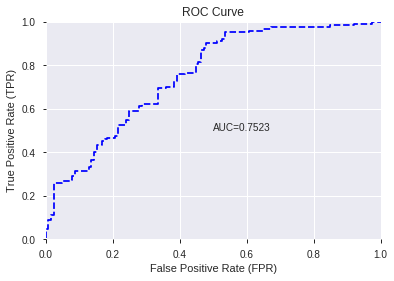

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


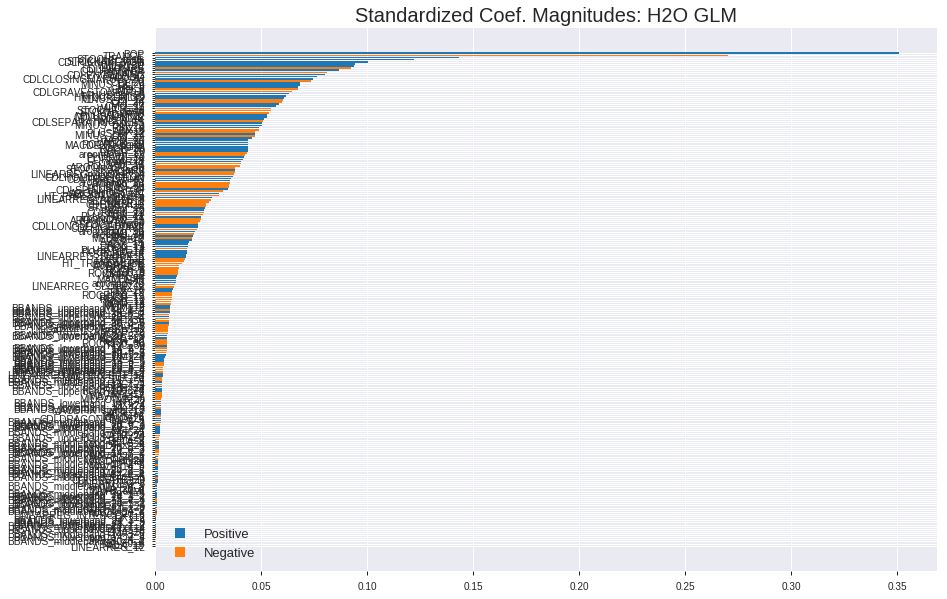

'log_likelihood'
--2019-08-28 15:54:49--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_155436_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_155436_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_9b1a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'CDLHIKKAKEMOD',
 'WILLR_30',
 'ULTOSC',
 'CDLHIKKAKE',
 'CDLHAMMER',
 'BETA_12',
 'CDLENGULFING',
 'ADOSC',
 'CDLCLOSINGMARUBOZU',
 'CCI_20',
 'MINUS_DI_24',
 'RSI_8',
 'CMO_8',
 'CCI_8',
 'CDLGRAVESTONEDOJI',
 'MINUS_DI_20',
 'HT_DCPERIOD',
 'MINUS_DI_12',
 'CCI_24',
 'CCI_30',
 'CMO_12',
 'WILLR_24',
 'STOCHF_fastd',
 'STOCH_slowk',
 'ADXR_8',
 'MINUS_DM_12',
 'CDLLONGLINE',
 'WILLR_14',
 'CDLSEPARATINGLINES',
 'MINUS_DM_20',
 'RSI_14',
 'DX_8',
 'ADX_8',
 'PLUS_DI_12',
 'MINUS_DM_24',
 'CCI_12',
 'MOM_20',
 'WILLR_20',
 'ROCR100_20',
 'MACDEXT_signal',
 'ROCR_20',
 'ROC_20',
 'ROCP_20',
 'aroondown_12',
 'PLUS_DI_30',
 'CORREL_14',
 'VAR_8',
 'VAR_14',
 'PLUS_DI_14',
 'AROONOSC_30',
 'STOCHRSI_fastd',
 'MOM_8',
 'LINEARREG_ANGLE_14',
 'PLUS_DI_20',
 'CDLHOMINGPIGEON',
 'CDLTHRUSTING',
 'aroondown_20',
 'aroonup_24',
 'CMO_30',
 'PLUS_DI_24',
 'CDLSPINNINGTOP',
 'AROONOSC_24',
 'CDLSHORTLINE',
 'HT_PHASOR_inphase',
 'LINEARREG_

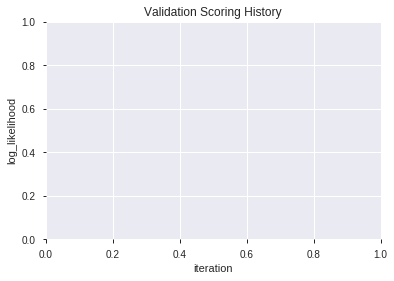

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_155454_model_4  0.761290  0.591526              0.280387  0.449659  0.202194
1               XGBoost_3_AutoML_20190828_155454  0.758645  0.598256              0.296645  0.452825  0.205050
2  XGBoost_grid_1_AutoML_20190828_155454_model_1  0.756000  0.597582              0.292387  0.452446  0.204708
3  XGBoost_grid_1_AutoML_20190828_155454_model_2  0.752903  0.598916              0.292452  0.453049  0.205253
4  XGBoost_grid_1_AutoML_20190828_155454_model_3  0.750968  0.602229              0.284677  0.454780  0.206825
5               XGBoost_1_AutoML_20190828_155454  0.750581  0.597830              0.288903  0.452820  0.205046
6  XGBoost_grid_1_AutoML_20190828_155454_model_6  0.742581  0.602204              0.284710  0.454897  0.206932
7  XGBoost_grid_1_AutoML_20190828_155454_model_5  0.736323  0.604334              0.324290  0.455695  0.207658
8               XGBoost_2_AutoML_20190828_155454  0.735871  0.610403              0.308677  0.458998  0.210679
9  XGBoost_grid_1_AutoML_20190828_155454_model_7  0.732000  0.612666              0.324516  0.460146  0.211735

variable  relative_importance  scaled_importance  percentage
0                  BOP          1473.984497           1.000000    0.324660
1               TRANGE           305.829620           0.207485    0.067362
2                ADOSC           157.894379           0.107121    0.034778
3         STOCHF_fastk           156.019394           0.105849    0.034365
4       STOCHRSI_fastk           141.750977           0.096169    0.031222
..                 ...                  ...                ...         ...
95  LINEARREG_ANGLE_12             5.410311           0.003671    0.001192
96              MOM_14             5.038978           0.003419    0.001110
97              RSI_14             4.762905           0.003231    0.001049
98          PLUS_DI_24             4.355364           0.002955    0.000959
99   MACDFIX_signal_12             4.037808           0.002739    0.000889

[100 rows x 4 columns]

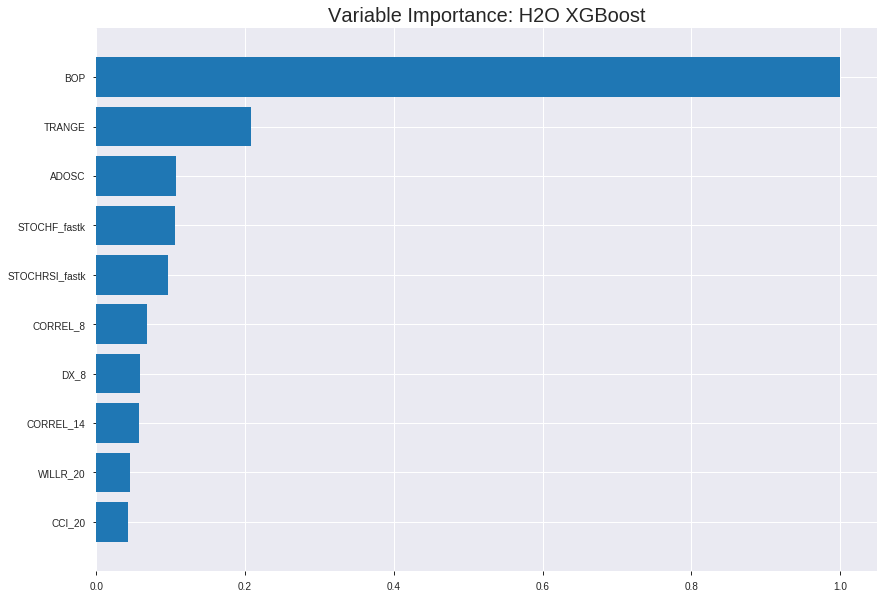

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_155454_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1873716328366202
RMSE: 0.4328644508811277
LogLoss: 0.559240879119161
Mean Per-Class Error: 0.26772171132603984
AUC: 0.8096526346387611
pr_auc: 0.8161670050932729
Gini: 0.6193052692775223
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40366291999816895: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      408  432   0.5143   (432.0/840.0)
1      93   808   0.1032   (93.0/901.0)
Total  501  1240  0.3016   (525.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.403663     0.754787  265
max f2                       0.339871     0.862964  303
max f0point5                 0.575819     0.754986  153
max accuracy                 0.528581     0.731763  182
max precision                0.864062     1         0
max recall                   0.16345      1         396
max specificity              0.864062     1         0
max absolute_mcc             0.556082     0.465715  166
max min_per_class_accuracy   0.530261     0.729762  181
max mean_per_class_accuracy  0.556082     0.732278  166

Gains/Lift Table: Avg response rate: 51.75 %, avg score: 51.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.802413           1.82495   1.82495            0.944444         0.818834  0.944444                    0.818834            0.0188679       0.0188679                  82.4948   82.4948
    2        0.0201034                   0.786258           1.9323    1.87709            1                0.795678  0.971429                    0.807587            0.0188679       0.0377358                  93.2297   87.7089
    3        0.0304423                   0.778746           1.9323    1.89584            1                0.782683  0.981132                    0.799129            0.0199778       0.0577137                  93.2297   89.5839
    4        0.0402068                   0.769955           1.9323    1.90469            1                0.774949  0.985714                    0.793257            0.0188679       0.0765816                  93.2297   90.4693
    5        0.0505457                   0.763501           1.7176    1.86642            0.888889         0.766213  0.965909                    0.787725            0.017758        0.0943396                  71.7598   86.6424
    6        0.100517                    0.732328           1.77683   1.82188            0.91954          0.747246  0.942857                    0.767601            0.0887902       0.18313                    77.6825   82.188
    7        0.150488                    0.708982           1.66577   1.77004            0.862069         0.720247  0.916031                    0.751877            0.0832408       0.266371                   66.5774   77.0043
    8        0.20046                     0.684              1.66577   1.74405            0.862069         0.697974  0.902579                    0.73844             0.0832408       0.349612                   66.5774   74.4051
    9        0.300402                    0.639253           1.34372   1.61086            0.695402         0.662456  0.833652                    0.71316             0.134295        0.483907                   34.3724   61.0864
    10       0.400345                    0.590694           1.2882    1.53031            0.666667         0.614807  0.791966                    0.688607            0.128746        0.612653                   28.8198   53.0313
    11       0.500287                    0.53364            1.0772    1.43979            0.557471         0.561377  0.745121                    0.66319             0.107658        0.720311                   7.72003   43.9795
    12       0.60023                     0.475012           0.888413  1.34799            0.45977          0.504053  0.697608                    0.636693            0.0887902       0.809101                   -11.1587  34.7985
    13       0.700172                    0.411692           0.744046  1.26178            0.385057         0.441751  0.652994                    0.608867            0.0743618       0.883463                   -25.5954  26.1779
    14       0.800115                    0.344676           0.73294   1.19572            0.37931          0.378075  0.618808                    0.580039            0.0732519       0.956715                   -26.706   19.5722
    15       0.900057                    0.267198           0.266524  1.09254            0.137931         0.305161  0.565412                    0.549516            0.0266371       0.983352                   -73.3476  9.25434
    16       1                           0.148945           0.166577  1                  0.0862069        0.218319  0.517519                    0.516415          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.216427225630606
RMSE: 0.46521739609628315
LogLoss: 0.6228222851605729
Mean Per-Class Error: 0.336533032185206
AUC: 0.7137210615471484
pr_auc: 0.6863919866502859
Gini: 0.42744212309429686
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39000169932842255: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      103  142  0.5796   (142.0/245.0)
1      28   225  0.1107   (28.0/253.0)
Total  131  367  0.3414   (170.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.390002     0.725806  288
max f2                       0.292846     0.844687  361
max f0point5                 0.532758     0.67216   178
max accuracy                 0.532758     0.662651  178
max precision                0.831761     1         0
max recall                   0.179626     1         394
max specificity              0.831761     1         0
max absolute_mcc             0.390002     0.351695  288
max min_per_class_accuracy   0.518488     0.652174  192
max mean_per_class_accuracy  0.532758     0.663467  178

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 50.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.771567           1.5747    1.5747             0.8              0.794193  0.8                         0.794193            0.0158103       0.0158103                  57.4704   57.4704
    2        0.0200803                   0.762054           1.5747    1.5747             0.8              0.765244  0.8                         0.779718            0.0158103       0.0316206                  57.4704   57.4704
    3        0.0301205                   0.756419           1.5747    1.5747             0.8              0.759744  0.8                         0.77306             0.0158103       0.0474308                  57.4704   57.4704
    4        0.0401606                   0.749254           1.96838   1.67312            1                0.755034  0.85                        0.768554            0.0197628       0.0671937                  96.8379   67.3123
    5        0.0502008                   0.741484           0.787352  1.49597            0.4              0.746973  0.76                        0.764238            0.00790514      0.0750988                  -21.2648  49.5968
    6        0.100402                    0.70379            1.41723   1.4566             0.72             0.722551  0.74                        0.743394            0.0711462       0.146245                   41.7233   45.6601
    7        0.150602                    0.678427           1.5747    1.49597            0.8              0.689036  0.76                        0.725275            0.0790514       0.225296                   57.4704   49.5968
    8        0.200803                    0.653269           1.41723   1.47628            0.72             0.665804  0.75                        0.710407            0.0711462       0.296443                   41.7233   47.6285
    9        0.301205                    0.607724           1.18103   1.37787            0.6              0.62987   0.7                         0.683561            0.118577        0.41502                    18.1028   37.7866
    10       0.399598                    0.55771            1.2453    1.34522            0.632653         0.586404  0.683417                    0.659638            0.12253         0.537549                   24.5301   34.5224
    11       0.5                         0.51114            1.14166   1.30435            0.58             0.534758  0.662651                    0.634562            0.114625        0.652174                   14.166    30.4348
    12       0.600402                    0.463011           0.98419   1.25081            0.5              0.488444  0.635452                    0.610128            0.0988142       0.750988                   -1.58103  25.081
    13       0.698795                    0.406085           0.923933  1.20478            0.469388         0.433996  0.612069                    0.585327            0.0909091       0.841897                   -7.60668  20.4784
    14       0.799197                    0.351043           0.826719  1.15729            0.42             0.381461  0.58794                     0.559716            0.083004        0.924901                   -17.3281  15.7288
    15       0.899598                    0.306515           0.433043  1.07646            0.22             0.329778  0.546875                    0.534053            0.0434783       0.968379                   -56.6957  7.64575
    16       1                           0.156148           0.314941  1                  0.16             0.244736  0.508032                    0.505005          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:55:06  4.563 sec   0                  0.5              0.693147            0.5             0                  1                0.482481                         0.5                0.693147              0.5               0                    1                  0.491968
    2019-08-28 15:55:07  4.894 sec   5                  0.484036         0.661595            0.747095        0.733323           1.6272           0.319931                         0.488475           0.670273              0.700637          0.684228             1.5747             0.409639
    2019-08-28 15:55:07  5.010 sec   10                 0.473072         0.640078            0.756018        0.750871           1.7289           0.317634                         0.480742           0.654963              0.709962          0.697561             1.96838            0.379518
    2019-08-28 15:55:07  5.148 sec   15                 0.464834         0.623872            0.765122        0.758455           1.61025          0.331419                         0.475328           0.644109              0.71285           0.704625             1.96838            0.363454
    2019-08-28 15:55:07  5.256 sec   20                 0.458514         0.611354            0.773041        0.772149           1.7176           0.327398                         0.471457           0.636298              0.717117          0.710503             1.96838            0.369478
    2019-08-28 15:55:07  5.361 sec   25                 0.453258         0.600767            0.777736        0.779357           1.82495          0.345204                         0.469007           0.631166              0.716246          0.707853             1.96838            0.35743
    2019-08-28 15:55:07  5.501 sec   30                 0.448866         0.591772            0.783313        0.787139           1.82495          0.330844                         0.467393           0.627708              0.716819          0.703667             1.96838            0.359438
    2019-08-28 15:55:07  5.615 sec   35                 0.444983         0.58388             0.789212        0.795109           1.82495          0.336014                         0.466533           0.625797              0.716117          0.696559             1.96838            0.369478
    2019-08-28 15:55:07  5.723 sec   40                 0.441752         0.577241            0.794564        0.802416           1.82495          0.332567                         0.466027           0.624687              0.713858          0.688059             1.5747             0.36747
    2019-08-28 15:55:08  5.833 sec   45                 0.439059         0.571677            0.798418        0.805174           1.82495          0.327972                         0.465119           0.622785              0.71631           0.687156             1.5747             0.349398
    2019-08-28 15:55:08  5.965 sec   50                 0.436068         0.565619            0.804009        0.811969           1.82495          0.321654                         0.465582           0.62354               0.71381           0.685525             1.5747             0.359438
    2019-08-28 15:55:08  6.082 sec   55                 0.432864         0.559241            0.809653        0.816167           1.82495          0.301551                         0.465217           0.622822              0.713721          0.6

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ---------------------
BOP                 1473.9844970703125     1.0                    0.32465982664197185
TRANGE              305.8296203613281      0.2074849640340141     0.06736203245409877
ADOSC               157.89437866210938     0.10712078653197493    0.03477781598522265
STOCHF_fastk        156.01939392089844     0.10584873465833743    0.0343648318444479
STOCHRSI_fastk      141.7509765625         0.09616856679581355    0.031222070224335718
---                 ---                    ---                    ---
LINEARREG_ANGLE_12  5.410310745239258      0.0036705343617879135  0.0011916750495814647
MOM_14              5.038978099822998      0.003418609971704897   0.001109885320770228
RSI_14              4.762905120849609      0.003231312900723411   0.0010490774861748296
PLUS_DI_24          4.355363845825195      0.00295482337465686    0.0009593124445737423
MACDFIX_signal_12   4.037808418273926      0.002739383233880317   0.000889367685817508


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7188755020080321)

('F1', 0.761904761904762)

('auc', 0.7612903225806451)

('logloss', 0.5915258532583612)

('mean_per_class_error', 0.2803870967741935)

('rmse', 0.4496593870777901)

('mse', 0.20219356438717384)

xgboost prediction progress: |████████████████████████████████████████████| 100%


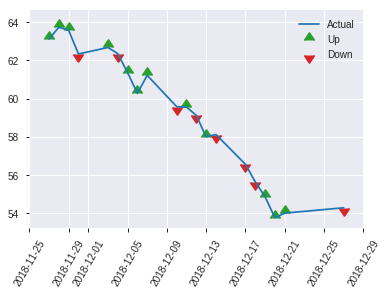


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20219356438717384
RMSE: 0.4496593870777901
LogLoss: 0.5915258532583612
Mean Per-Class Error: 0.2803870967741935
AUC: 0.7612903225806451
pr_auc: 0.726230595690392
Gini: 0.5225806451612902
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42009028792381287: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      67   58   0.464    (58.0/125.0)
1      12   112  0.0968   (12.0/124.0)
Total  79   170  0.2811   (70.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.42009      0.761905  169
max f2                       0.359781     0.856115  198
max f0point5                 0.48241      0.702663  137
max accuracy                 0.42009      0.718876  169
max precision                0.834652     1         0
max recall                   0.265589     1         230
max specificity              0.834652     1         0
max absolute_mcc             0.42009      0.471863  169
max min_per_class_accuracy   0.511363     0.688     124
max mean_per_class_accuracy  0.42009      0.719613  169

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 51.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.794048           2.00806   2.00806            1                0.815145  1                           0.815145            0.0241935       0.0241935                  100.806   100.806
    2        0.0200803                   0.770768           2.00806   2.00806            1                0.785547  1                           0.803306            0.016129        0.0403226                  100.806   100.806
    3        0.0321285                   0.759564           2.00806   2.00806            1                0.76491   1                           0.788907            0.0241935       0.0645161                  100.806   100.806
    4        0.0401606                   0.75653            1.00403   1.80726            0.5              0.758272  0.9                         0.78278             0.00806452      0.0725806                  0.403226  80.7258
    5        0.0522088                   0.751868           2.00806   1.8536             1                0.754767  0.923077                    0.776316            0.0241935       0.0967742                  100.806   85.3598
    6        0.100402                    0.728491           1.17137   1.52613            0.583333         0.738544  0.76                        0.758185            0.0564516       0.153226                   17.1371   52.6129
    7        0.15261                     0.700648           1.54467   1.53247            0.769231         0.713877  0.763158                    0.743027            0.0806452       0.233871                   54.4665   53.247
    8        0.200803                    0.681155           1.50605   1.52613            0.75             0.69169   0.76                        0.730706            0.0725806       0.306452                   50.6048   52.6129
    9        0.301205                    0.630334           1.20484   1.41903            0.6              0.654813  0.706667                    0.705408            0.120968        0.427419                   20.4839   41.9032
    10       0.401606                    0.568607           1.44581   1.42573            0.72             0.602801  0.71                        0.679757            0.145161        0.572581                   44.5806   42.5726
    11       0.502008                    0.511363           1.20484   1.38155            0.6              0.542424  0.688                       0.65229             0.120968        0.693548                   20.4839   38.1548
    12       0.598394                    0.459276           1.0877    1.33422            0.541667         0.483079  0.66443                     0.625034            0.104839        0.798387                   8.77016   33.4217
    13       0.698795                    0.415227           1.12452   1.30409            0.56             0.435042  0.649425                    0.597737            0.112903        0.91129                    12.4516   30.4088
    14       0.799197                    0.359607           0.481935  1.2008             0.24             0.389469  0.59799                     0.571573            0.0483871       0.959677                   -51.8065  20.0802
    15       0.899598                    0.282045           0.240968  1.09368            0.12             0.318241  0.544643                    0.543299            0.0241935       0.983871                   -75.9032  9.3678
    16       1                           0.160164           0.160645  1                  0.08             0.238797  0.497992                    0.512726           

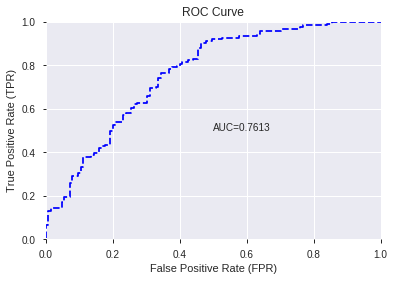

This function is available for GLM models only


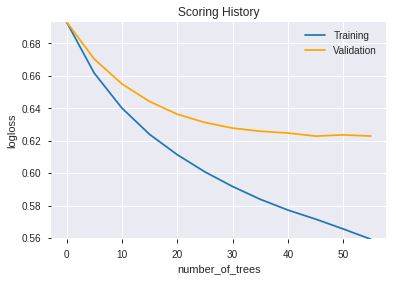

--2019-08-28 15:55:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.120.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.120.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_155454_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_155454_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_9b1a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'ADOSC',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'CORREL_8',
 'DX_8',
 'CORREL_14',
 'WILLR_20',
 'CCI_20',
 'ROC_14',
 'ADXR_14',
 'CCI_12',
 'MFI_12',
 'DX_20',
 'ROC_20',
 'CORREL_12',
 'CCI_8',
 'PLUS_DI_12',
 'MINUS_DM_12',
 'CMO_8',
 'DX_24',
 'ADXR_8',
 'DX_30',
 'PLUS_DM_20',
 'PLUS_DM_12',
 'MACDFIX_hist_20',
 'ADXR_12',
 'LINEARREG_ANGLE_8',
 'PLUS_DI_30',
 'HT_DCPERIOD',
 'PLUS_DI_20',
 'ADX_24',
 'PLUS_DM_14',
 'BETA_12',
 'ULTOSC',
 'MACD_hist',
 'ATR_30',
 'MFI_24',
 'aroondown_24',
 'ATR_12',
 'WILLR_30',
 'MFI_20',
 'ADX_8',
 'MFI_30',
 'MINUS_DI_24',
 'ADX_12',
 'BETA_8',
 'MOM_8',
 'aroonup_14',
 'CCI_24',
 'aroonup_24',
 'STOCH_slowd',
 'ROC_12',
 'AROONOSC_30',
 'ROCP_8',
 'CCI_30',
 'MINUS_DM_24',
 'LINEARREG_ANGLE_14',
 'NATR_8',
 'MINUS_DM_20',
 'WILLR_14',
 'MOM_30',
 'PLUS_DM_24',
 'STDDEV_8',
 'CMO_30',
 'MINUS_DI_12',
 'STDDEV_14',
 'NATR_20',
 'BBANDS_lowerband_20_0_4',
 'HT_PHASOR_inphase',
 'DX_12',
 'CMO_20',
 'PLUS_DI_14',
 'TRIX_8',
 'M

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.719
GLM             0.715
XGBoost         0.735
dtype: float64

DeepLearning    GLM  XGBoost
All          0.695  0.715    0.735
DLF          0.719  0.707    0.707
Fwe          0.703  0.695    0.731
RFE          0.703  0.711    0.719
XGBF         0.711  0.707    0.711





F1


DeepLearning    0.748
GLM             0.766
XGBoost         0.773
dtype: float64

DeepLearning    GLM  XGBoost
All          0.748  0.766    0.756
DLF          0.741  0.748    0.745
Fwe          0.740  0.740    0.773
RFE          0.738  0.764    0.762
XGBF         0.739  0.748    0.741





auc


DeepLearning    0.769
GLM             0.770
XGBoost         0.774
dtype: float64

DeepLearning    GLM  XGBoost
All          0.753  0.753    0.766
DLF          0.769  0.770    0.761
Fwe          0.768  0.764    0.774
RFE          0.754  0.752    0.761
XGBF         0.759  0.770    0.760





logloss


DeepLearning    0.619
GLM             0.597
XGBoost         0.592
dtype: float64

DeepLearning    GLM  XGBoost
All          0.611  0.597    0.592
DLF          0.575  0.578    0.589
Fwe          0.579  0.583    0.580
RFE          0.619  0.591    0.592
XGBF         0.590  0.578    0.591





mean_per_class_error


DeepLearning    0.305
GLM             0.305
XGBoost         0.293
dtype: float64

DeepLearning    GLM  XGBoost
All          0.305  0.284    0.265
DLF          0.281  0.293    0.293
Fwe          0.297  0.305    0.268
RFE          0.297  0.288    0.280
XGBF         0.289  0.293    0.289





rmse


DeepLearning    0.457
GLM             0.453
XGBoost         0.450
dtype: float64

DeepLearning    GLM  XGBoost
All          0.457  0.453    0.450
DLF          0.442  0.444    0.449
Fwe          0.444  0.447    0.444
RFE          0.453  0.450    0.450
XGBF         0.450  0.444    0.450





mse


DeepLearning    0.209
GLM             0.205
XGBoost         0.202
dtype: float64

DeepLearning    GLM  XGBoost
All          0.209  0.205    0.202
DLF          0.196  0.197    0.201
Fwe          0.197  0.200    0.197
RFE          0.205  0.202    0.202
XGBF         0.203  0.197    0.202

{'F1':       DeepLearning    GLM  XGBoost
 All          0.748    NaN      NaN
 DLF          0.741    NaN      NaN
 DLF            NaN  0.748      NaN
 DLF            NaN    NaN    0.745
 All            NaN  0.766      NaN
 All            NaN    NaN    0.756
 XGBF         0.739    NaN      NaN
 XGBF           NaN  0.748      NaN
 XGBF           NaN    NaN    0.741
 Fwe          0.740    NaN      NaN
 Fwe            NaN  0.740      NaN
 Fwe            NaN    NaN    0.773
 RFE          0.738    NaN      NaN
 RFE            NaN  0.764      NaN
 RFE            NaN    NaN    0.762,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.695    NaN      NaN
 DLF          0.719    NaN      NaN
 DLF            NaN  0.707      NaN
 DLF            NaN    NaN    0.707
 All            NaN  0.715      NaN
 All            NaN    NaN    0.735
 XGBF         0.711    NaN      NaN
 XGBF           NaN  0.707      NaN
 XGBF           NaN    NaN    0.711
 Fwe          0.703    NaN      NaN
 Fwe     